In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import platform

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    pass

import warnings

# 특정 FutureWarning 메시지를 무시하도록 설정
warnings.filterwarnings(
    action='ignore', # 경고를 무시함
    message="Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated", # 정확한 경고 메시지 문자열
    category=FutureWarning, # FutureWarning 카테고리
)
# clip, where, mask 관련 FutureWarning 메시지를 무시하도록 설정
warnings.filterwarnings(
    action='ignore',
    message="Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated.", # 정확한 경고 메시지
    category=FutureWarning
)

# Load the Dataset

In [4]:
dataset = pd.read_excel('final_dataset.xlsx')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   조사연월                     13478 non-null  int64 
 1   가구구분코드                   13478 non-null  int64 
 2   가구원수                     13478 non-null  int64 
 3   취업인원수                    13478 non-null  int64 
 4   노인가구여부                   13478 non-null  int64 
 5   가구주_연령                   13478 non-null  int64 
 6   가구주_학력코드                 13478 non-null  int64 
 7   가구주_취업여부                 13478 non-null  int64 
 8   가구주_10차산업분류코드            13478 non-null  object
 9   거처구분코드                   13478 non-null  int64 
 10  입주형태코드                   13478 non-null  int64 
 11  전국전체가구_1인이상소득10분위코드      13478 non-null  int64 
 12  소득구간코드                   13478 non-null  int64 
 13  가계지출금액                   13478 non-null  int64 
 14  가계지출_소비지출금액              13478 non-nul

# 결측치 처리

### - 해당 데이터셋은 국가 통계 포털인 KOSIS로부터 가져온 데이터이기 때문에 결측치가 존재하지 않음
### - 따라서 결측치를 무작위로 생성

In [6]:
# 원본 데이터를 보존
df_nan = dataset.copy()

# 항상 같은 결과가 나오도록 시드를 고정
np.random.seed(42)
# 결측치 비율을 전체 데이터의 1%로 설정
missing_rate = 0.01

# 전체 셀 개수 계산
tot_cells = df_nan.size
num_missing = int(tot_cells * missing_rate)


# 무작위 (행, 열) 인덱스 생성
rows = np.random.randint(0, df_nan.shape[0], num_missing)
cols = np.random.randint(0, df_nan.shape[1], num_missing)

# 무작위 위치에 결측치 삽입
for row, col in zip(rows, cols):
    df_nan.iat[row, col] = np.nan

# 각 열마다 결측치의 개수 세어주는 코드.
print(df_nan.isnull().sum())

조사연월                       112
가구구분코드                     121
가구원수                       132
취업인원수                      137
노인가구여부                     122
가구주_연령                     131
가구주_학력코드                   112
가구주_취업여부                   140
가구주_10차산업분류코드              118
거처구분코드                     128
입주형태코드                     143
전국전체가구_1인이상소득10분위코드        129
소득구간코드                     162
가계지출금액                     116
가계지출_소비지출금액                154
가계지출_소비지출_식료품비주류음료구입비      126
가계지출_소비지출_주류담배구입비          162
가계지출_소비지출_의류신발구입비          119
가계지출_소비지출_주거수도광열비          132
가계지출_소비지출_가정용품가사서비스이용금액    131
가계지출_소비지출_보건제품구입비          124
가계지출_소비지출_교통비              165
가계지출_소비지출_통신비              143
가계지출_소비지출_오락문화비            124
가계지출_소비지출_교육비              136
가계지출_소비지출_음식숙박비            139
가계지출_소비지출_기타상품서비스이용금액      149
도시읍면부구분코드                  142
dtype: int64


### - 각 열마다 결측치를 처리
### - 이미 완벽하게 정렬된 데이터이기 때문에 결측치를 바로 앞의 행 값으로 처리

In [7]:
# Nan 값을 모두 처리한 이후의 데이터를 저장할 df를 생성

df_full = df_nan.copy()

# 조사연월은 다른 행의 값과 똑같이 처리(202400으로)
df_full['조사연월'] = df_nan['조사연월'].fillna(202400)

# 가구구분코드 
df_full['가구구분코드'] = df_nan['가구구분코드'].ffill()

# 가구원수
df_full['가구원수'] = df_nan['가구원수'].ffill()

# 취업인원수
df_full['취업인원수'] = df_nan['취업인원수'].ffill()

# 가구주연령 (노인가구여부 다음 열이긴 하지만 이걸 먼저 채워야 노인가구여부를 채울 수 있음)
df_full['가구주_연령'] = df_nan['가구주_연령'].ffill()

# 노인가구여부 가구주_연령이 65세 이상인 경우 노인가구여부를 1로 설정
df_full.loc[df_nan['가구주_연령'] >= 65, '노인가구여부'] = 1
# 나머지 NaN인 노인가구여부는 0으로 채움
df_full['노인가구여부'] = df_nan['노인가구여부'].fillna(0)

# 가구주_학력코드
df_full['가구주_학력코드'] = df_nan['가구주_학력코드'].ffill()

# 가구주_취업여부
df_full['가구주_취업여부'] = df_nan['가구주_취업여부'].ffill()

# 가구주_10차산업분류코드
df_full['가구주_10차산업분류코드'] = df_nan['가구주_10차산업분류코드'].ffill()

# 거처구분코드
df_full['거처구분코드'] = df_nan['거처구분코드'].ffill()

# 입주형태코드
df_full['입주형태코드'] = df_nan['입주형태코드'].ffill()

# 12개의 소비품목, 가계지출_소비지출금액 결측치 채워넣기
# 소비지출 항목 12개
item_columns = [
    '가계지출_소비지출_식료품비주류음료구입비',
    '가계지출_소비지출_주류담배구입비',
    '가계지출_소비지출_의류신발구입비',
    '가계지출_소비지출_주거수도광열비',
    '가계지출_소비지출_가정용품가사서비스이용금액',
    '가계지출_소비지출_보건제품구입비',
    '가계지출_소비지출_교통비',
    '가계지출_소비지출_통신비',
    '가계지출_소비지출_오락문화비',
    '가계지출_소비지출_교육비',
    '가계지출_소비지출_음식숙박비',
    '가계지출_소비지출_기타상품서비스이용금액'
]

total_column = '가계지출_소비지출금액'

# 평균값들 미리 계산
group_item_mean = df_full.groupby('가구원수')[item_columns].mean()
global_item_mean = df_full[item_columns].mean()

def smart_fill(row):
    items = row[item_columns]
    total = row[total_column]
    size = row['가구원수']

    # 1. 총합이 있고, 일부 항목만 결측 → 남은 금액 균등 분배
    if pd.notna(total) and items.isna().any() and items.notna().sum() > 0:
        known_sum = items.sum(skipna=True)
        remaining = total - known_sum
        missing_count = items.isna().sum()
        if missing_count > 0:
            if remaining < 0:
                each = 0
            else:
                each = remaining / missing_count
            each = max(0, each)
            filled_items = items.fillna(each)
            for col_name, val in filled_items.items():
                row[col_name] = val

    # 2. 총합이 결측이고, 항목이 모두 채워짐 → 항목 합으로 총합 계산
    elif pd.isna(total) and items.notna().all():
        row[total_column] = items.sum()

    # 3. 총합과 항목 일부가 모두 결측 → 항목은 그룹 평균으로 채우고 총합은 항목합
    elif pd.isna(total) and items.isna().any():
        if size in group_item_mean.index:
            group_mean_for_size = group_item_mean.loc[size]
            # items.fillna(group_mean_for_size)는 items의 NaN을 group_mean_for_size 값으로 채움
            # 그 결과에 다시 global_item_mean으로 채움
            filled_items = items.fillna(group_mean_for_size).fillna(global_item_mean)
        else:
            filled_items = items.fillna(global_item_mean)
        row[item_columns] = filled_items.infer_objects(copy=False)
        row[total_column] = row[item_columns].sum()

    # 4. 총합은 있지만 항목이 전부 NaN → 12개 항목에 균등 분배
    elif pd.notna(total) and items.isna().all():
        if len(item_columns) > 0: # 혹시 모를 ZeroDivisionError 방지
            value_to_fill = total / len(item_columns)
            # items.index를 사용하여 채워질 Series의 인덱스를 명확히 함
            filled_items = pd.Series([value_to_fill] * len(item_columns), index=items.index)
            row[item_columns] = filled_items.infer_objects(copy=False)

    return row

# 적용
df_full = df_full.apply(smart_fill, axis=1)

In [8]:
df_full.isna().sum()

조사연월                         0
가구구분코드                       0
가구원수                         0
취업인원수                        0
노인가구여부                       0
가구주_연령                       0
가구주_학력코드                     0
가구주_취업여부                     0
가구주_10차산업분류코드                0
거처구분코드                       0
입주형태코드                       0
전국전체가구_1인이상소득10분위코드        129
소득구간코드                     162
가계지출금액                     116
가계지출_소비지출금액                  0
가계지출_소비지출_식료품비주류음료구입비        0
가계지출_소비지출_주류담배구입비            0
가계지출_소비지출_의류신발구입비            0
가계지출_소비지출_주거수도광열비            0
가계지출_소비지출_가정용품가사서비스이용금액      0
가계지출_소비지출_보건제품구입비            0
가계지출_소비지출_교통비                0
가계지출_소비지출_통신비                0
가계지출_소비지출_오락문화비              0
가계지출_소비지출_교육비                0
가계지출_소비지출_음식숙박비              0
가계지출_소비지출_기타상품서비스이용금액        0
도시읍면부구분코드                  142
dtype: int64

In [9]:
# 가계지출금액 (소비지출 + 비소비지출)
# 1. 소비지출금액이 존재할 경우 → 110%로 보정
def fill_total_expenditure(row):
    if pd.isna(row['가계지출금액']):
        consumption = row['가계지출_소비지출금액']
        size = row['가구원수']

        if pd.notna(consumption):
            # 소비지출에 비소비지출 약간 더한 가정
            return consumption * 1.1

        elif size in df_full.groupby('가구원수')['가계지출금액'].mean():
            return df_full.groupby('가구원수')['가계지출금액'].mean().loc[size]

        else:
            return df_full['가계지출금액'].mean()

    else:
        return row['가계지출금액']

# 적용
df_full['가계지출금액'] = df_full.apply(fill_total_expenditure, axis=1)

In [10]:
# 전국전체가구_1인이상소득10분위코드 (상대적). 다른 feature들 먼저 채우고 나중에 채우기.
# 소득구간코드 (절대적), feature selection 과정에서 drop시킬듯. 다른 feature들 먼저 채우고 나중에 채우기.
# 미리 그룹 평균 계산
group_decile_by_income = df_full.groupby('소득구간코드')['전국전체가구_1인이상소득10분위코드'].mean()
group_income_by_decile = df_full.groupby('전국전체가구_1인이상소득10분위코드')['소득구간코드'].mean()
group_income_by_size = df_full.groupby('가구원수')['소득구간코드'].mean()

# 중앙값 (최후의 fallback)
decile_median = df_full['전국전체가구_1인이상소득10분위코드'].median()
income_median = df_full['소득구간코드'].median()

def fill_income_and_decile(row):
    income = row['소득구간코드']
    decile = row['전국전체가구_1인이상소득10분위코드']
    size = row['가구원수']

    # 1. 소득구간코드가 존재하고 분위가 결측
    if pd.notna(income) and pd.isna(decile):
        if income in group_decile_by_income.index:
            row['전국전체가구_1인이상소득10분위코드'] = round(group_decile_by_income.loc[income])

    # 2. 분위가 존재하고 소득구간이 결측
    elif pd.notna(decile) and pd.isna(income):
        if decile in group_income_by_decile.index:
            row['소득구간코드'] = round(group_income_by_decile.loc[decile])

    # 3. 둘 다 결측
    elif pd.isna(income) and pd.isna(decile):
        # 가구원수 기반으로 소득구간 예측
        if pd.notna(size) and size in group_income_by_size.index:
            row['소득구간코드'] = round(group_income_by_size.loc[size])
        else:
            row['소득구간코드'] = income_median

        # 분위는 보수적으로 중앙값 사용
        row['전국전체가구_1인이상소득10분위코드'] = decile_median

    return row

# 적용
df_full = df_full.apply(fill_income_and_decile, axis=1)

In [11]:
# 도시읍면부구분코드
# 최빈값 계산
mode_city = df_full['도시읍면부구분코드'].mode().iloc[0]
# 결측치 채우기
df_full['도시읍면부구분코드'] = df_full['도시읍면부구분코드'].fillna(mode_city)

# 결측치 처리가 잘 되었는지 확인
print(df_full.isnull().sum())



# EDA 결과와 확인하기 위해 12가지 소비 품목의 max값 각각 출력해보기.
print(df_full[item_columns].max())

조사연월                       0
가구구분코드                     0
가구원수                       0
취업인원수                      0
노인가구여부                     0
가구주_연령                     0
가구주_학력코드                   0
가구주_취업여부                   0
가구주_10차산업분류코드              0
거처구분코드                     0
입주형태코드                     0
전국전체가구_1인이상소득10분위코드        0
소득구간코드                     0
가계지출금액                     0
가계지출_소비지출금액                0
가계지출_소비지출_식료품비주류음료구입비      0
가계지출_소비지출_주류담배구입비          0
가계지출_소비지출_의류신발구입비          0
가계지출_소비지출_주거수도광열비          0
가계지출_소비지출_가정용품가사서비스이용금액    0
가계지출_소비지출_보건제품구입비          0
가계지출_소비지출_교통비              0
가계지출_소비지출_통신비              0
가계지출_소비지출_오락문화비            0
가계지출_소비지출_교육비              0
가계지출_소비지출_음식숙박비            0
가계지출_소비지출_기타상품서비스이용금액      0
도시읍면부구분코드                  0
dtype: int64
가계지출_소비지출_식료품비주류음료구입비       2236470.0
가계지출_소비지출_주류담배구입비            674620.0
가계지출_소비지출_의류신발구입비           3833847.0
가계지출_소비지출_주거수도광열비          26711138.0
가계지출_소비지출_가정용품가사서비스이용금액

# EDA 진행

In [12]:
# EDA - 한글 폰트 설정
# AppleGothic 폰트는 윈도우에서 사용불가
# https://fonts.google.com/noto/specimen/Noto+Sans+KR
# 해당 웹사이트에서 폰트를 다운받아 사용
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False

In [13]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   조사연월                     13478 non-null  float64
 1   가구구분코드                   13478 non-null  float64
 2   가구원수                     13478 non-null  float64
 3   취업인원수                    13478 non-null  float64
 4   노인가구여부                   13478 non-null  float64
 5   가구주_연령                   13478 non-null  float64
 6   가구주_학력코드                 13478 non-null  float64
 7   가구주_취업여부                 13478 non-null  float64
 8   가구주_10차산업분류코드            13478 non-null  object 
 9   거처구분코드                   13478 non-null  float64
 10  입주형태코드                   13478 non-null  float64
 11  전국전체가구_1인이상소득10분위코드      13478 non-null  float64
 12  소득구간코드                   13478 non-null  float64
 13  가계지출금액                   13478 non-null  float64
 14  가계지출_소비지출금액           

In [14]:
df_full.describe()

조사연월        가구구분코드          가구원수         취업인원수        노인가구여부  \
count   13478.0  13478.000000  13478.000000  13478.000000  13478.000000   
mean   202400.0      1.429589      2.140006      1.206039      0.249369   
std         0.0      0.495036      1.076257      0.788770      0.432664   
min    202400.0      1.000000      1.000000      0.000000      0.000000   
25%    202400.0      1.000000      1.000000      1.000000      0.000000   
50%    202400.0      1.000000      2.000000      1.000000      0.000000   
75%    202400.0      2.000000      3.000000      2.000000      0.000000   
max    202400.0      2.000000      8.000000      5.000000      1.000000   

             가구주_연령      가구주_학력코드      가구주_취업여부        거처구분코드        입주형태코드  \
count  13478.000000  13478.000000  13478.000000  13478.000000  13478.000000   
mean      55.673987      4.541030      1.202478      1.964832      2.558614   
std       16.029508      1.510391      0.401862      1.097777      2.110883   
min       17.000000      1.000000      1.000000      1.000000      1.000000   
25%       43.000000      4.000000      1.000000      1.000000      1.000000   
50%       57.000000      4.000000      1.000000      2.000000      1.000000   
75%       68.000000      6.000000      1.000000      2.000000      4.000000   
max      100.000000      8.000000      2.000000      7.000000      7.000000   

       ...  가계지출_소비지출_주거수도광열비  가계지출_소비지출_가정용품가사서비스이용금액  가계지출_소비지출_보건제품구입비  \
count  ...       1.347800e+04             1.347800e+04       1.347800e+04   
mean   ...       3.411556e+05             1.204239e+05       2.527501e+05   
std    ...       5.083265e+05             2.988208e+05       3.927913e+05   
min    ...       0.000000e+00             0.000000e+00       0.000000e+00   
25%    ...       1.694008e+05             1.835125e+04       5.577225e+04   
50%    ...       2.620995e+05             4.988750e+04       1.387160e+05   
75%    ...       3.912428e+05             1.160412e+05       3.004358e+05   
max    ...       2.671114e+07             1.360995e+07       1.072197e+07   

       가계지출_소비지출_교통비  가계지출_소비지출_통신비  가계지출_소비지출_오락문화비  가계지출_소비지출_교육비  \
count   1.347800e+04   1.347800e+04     1.347800e+04   1.347800e+04   
mean    3.156840e+05   1.167453e+05     1.939867e+05   1.710337e+05   
std     9.523962e+05   1.252759e+05     3.454341e+05   4.229538e+05   
min     0.000000e+00   0.000000e+00     0.000000e+00   0.000000e+00   
25%     7.500000e+04   4.775800e+04     2.870000e+04   0.000000e+00   
50%     1.722125e+05   8.758150e+04     8.053550e+04   0.000000e+00   
75%     3.051028e+05   1.457185e+05     2.159792e+05   6.666700e+04   
max     2.488032e+07   2.627897e+06     6.940205e+06   6.750000e+06   

       가계지출_소비지출_음식숙박비  가계지출_소비지출_기타상품서비스이용금액     도시읍면부구분코드  
count     1.347800e+04           1.347800e+04  13478.000000  
mean      4.066752e+05           2.235033e+05      0.799451  
std       3.421968e+05           4.431615e+05      0.400426  
min       0.000000e+00           0.000000e+00      0.000000  
25%       1.463770e+05           7.416625e+04      1.000000  
50%       3.273725e+05           1.558590e+05      1.000000  
75%       5.791882e+05           2.725402e+05      1.000000  
max       2.837050e+06           2.374638e+07      1.000000  

[8 rows x 27 columns]

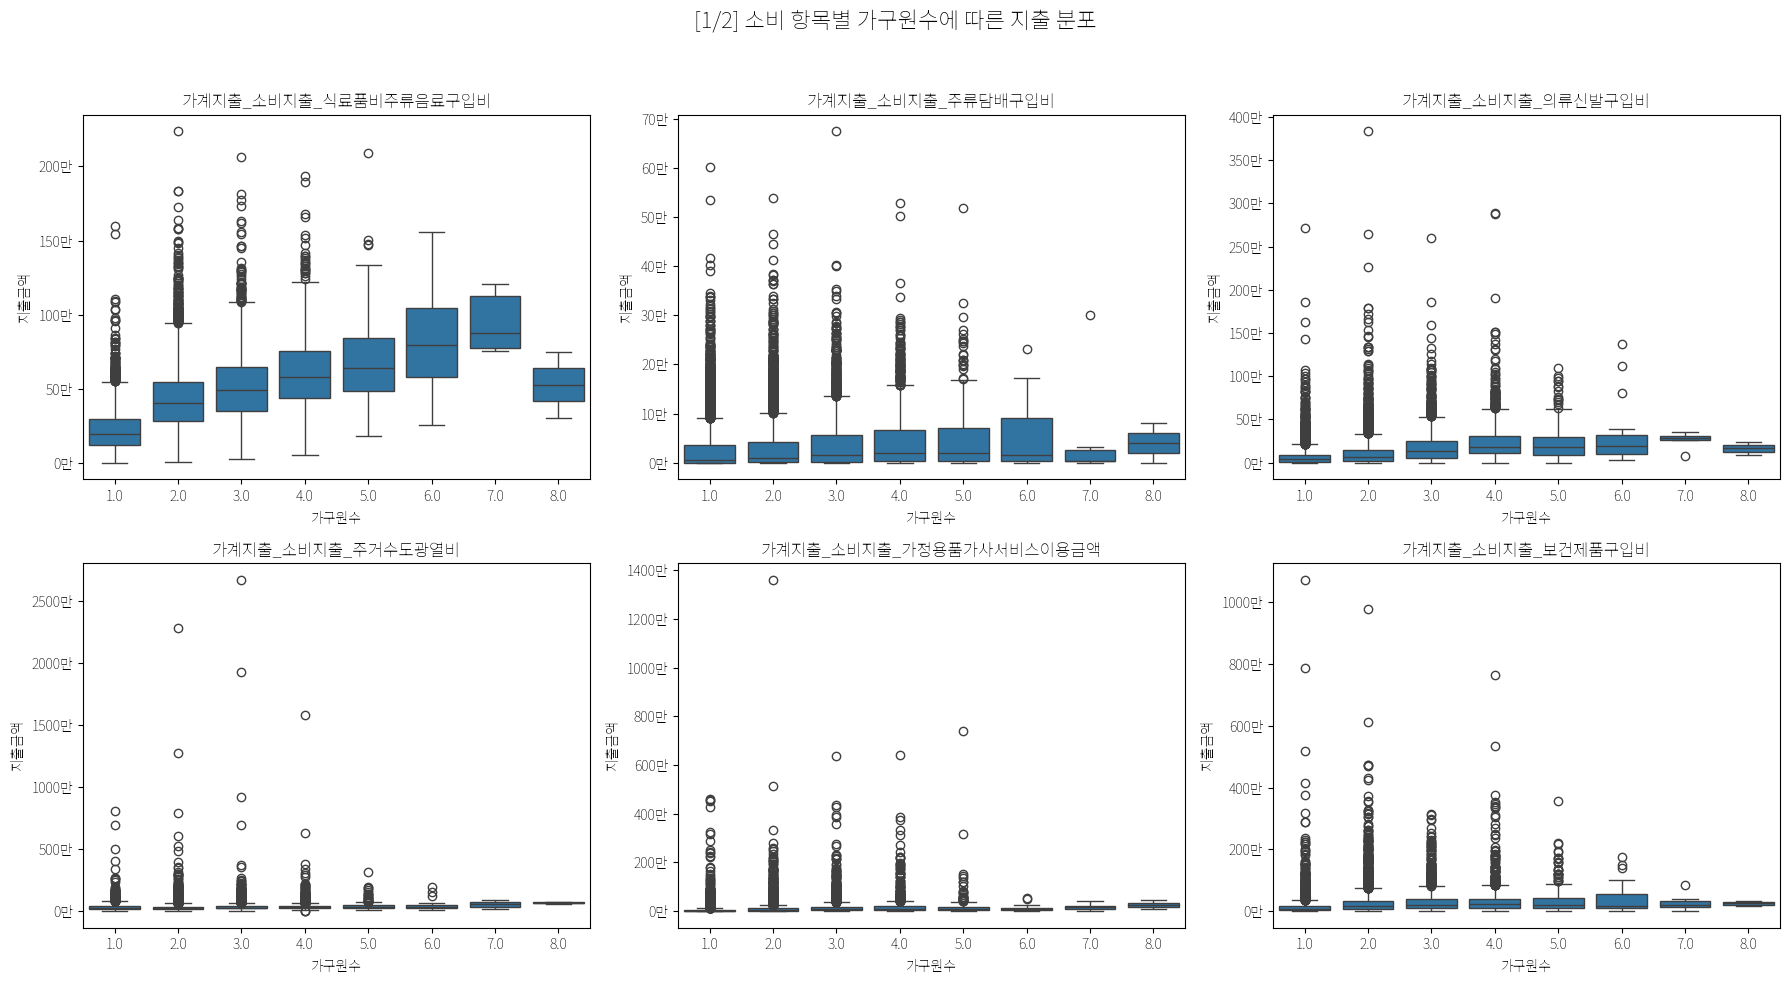

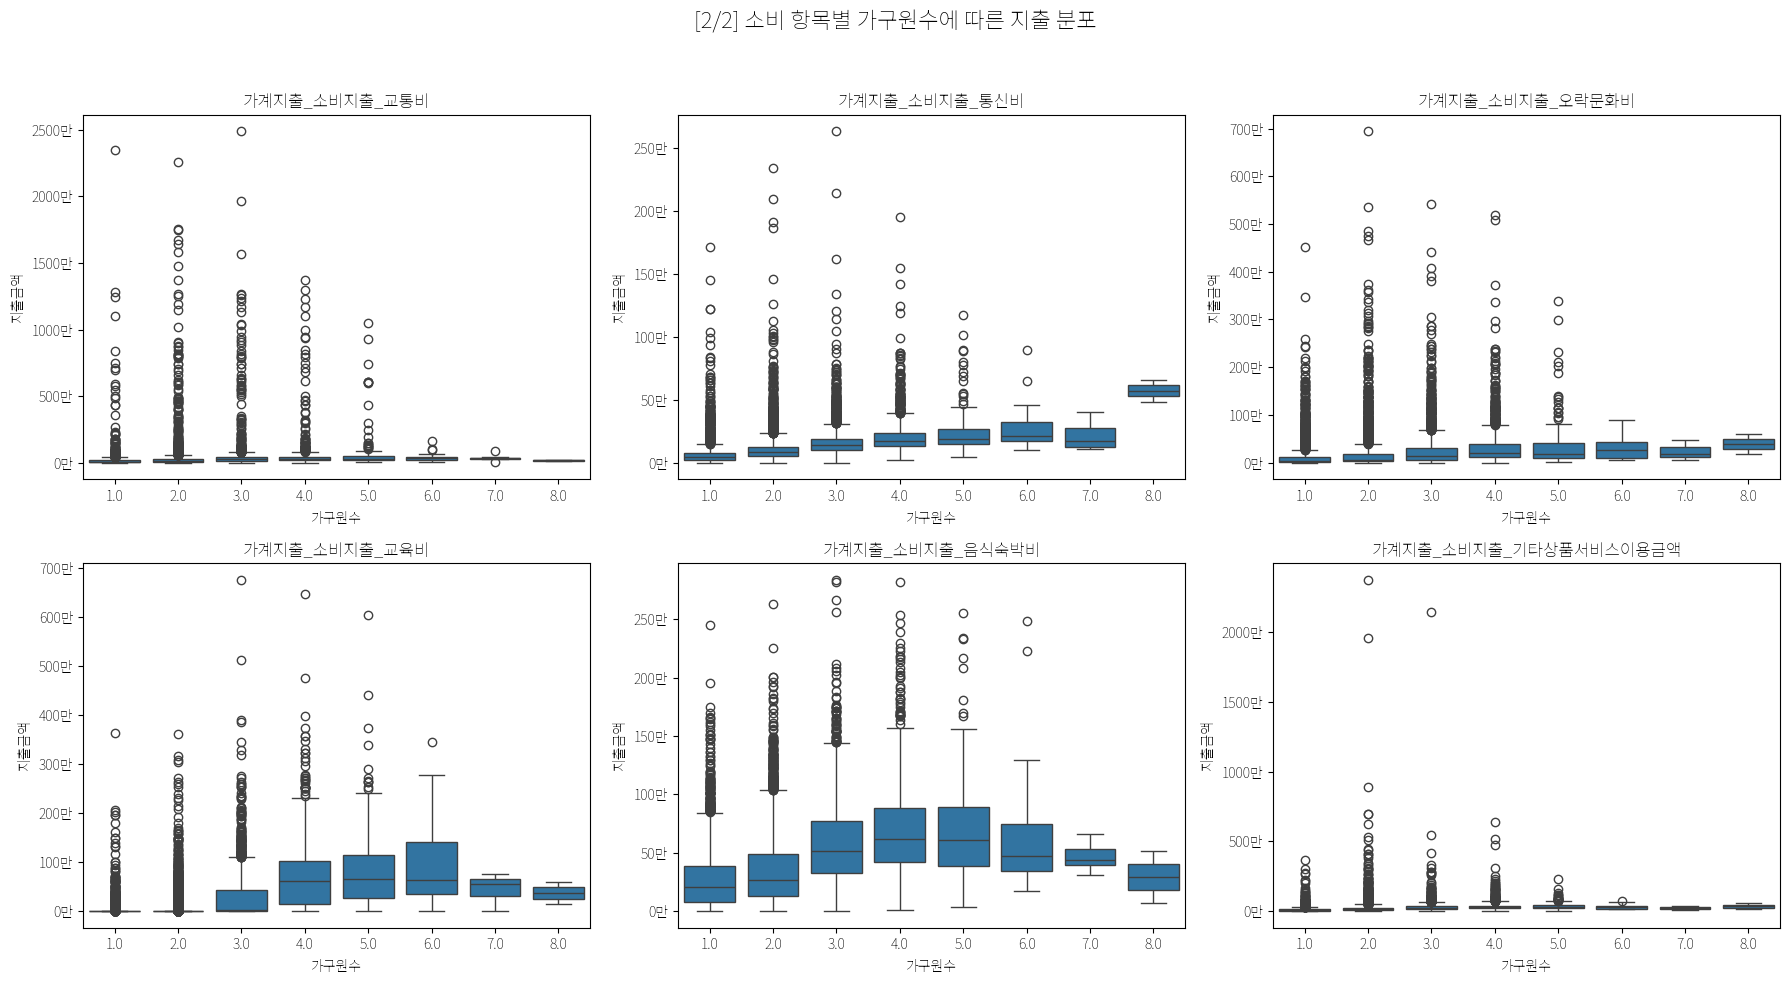

In [15]:
# Boxplot으로 outlier detection

# 첫 번째 6개 항목 (1/2)
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
axes1 = axes1.flatten()

for i, col in enumerate(item_columns[:6]):
    sns.boxplot(data=df_full, x='가구원수', y=col, ax=axes1[i])
    axes1[i].set_title(f"{col}")
    axes1[i].set_xlabel("가구원수")
    axes1[i].set_ylabel("지출금액")
    # 만원 단위로 포맷
    axes1[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))

plt.suptitle("[1/2] 소비 항목별 가구원수에 따른 지출 분포", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 두 번째 6개 항목 (2/2)
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
axes2 = axes2.flatten()

for i, col in enumerate(item_columns[6:]):
    sns.boxplot(data=df_full, x='가구원수', y=col, ax=axes2[i])
    axes2[i].set_title(f"{col}")
    axes2[i].set_xlabel("가구원수")
    axes2[i].set_ylabel("지출금액")
    # 만원 단위로 포맷
    axes2[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))

plt.suptitle("[2/2] 소비 항목별 가구원수에 따른 지출 분포", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

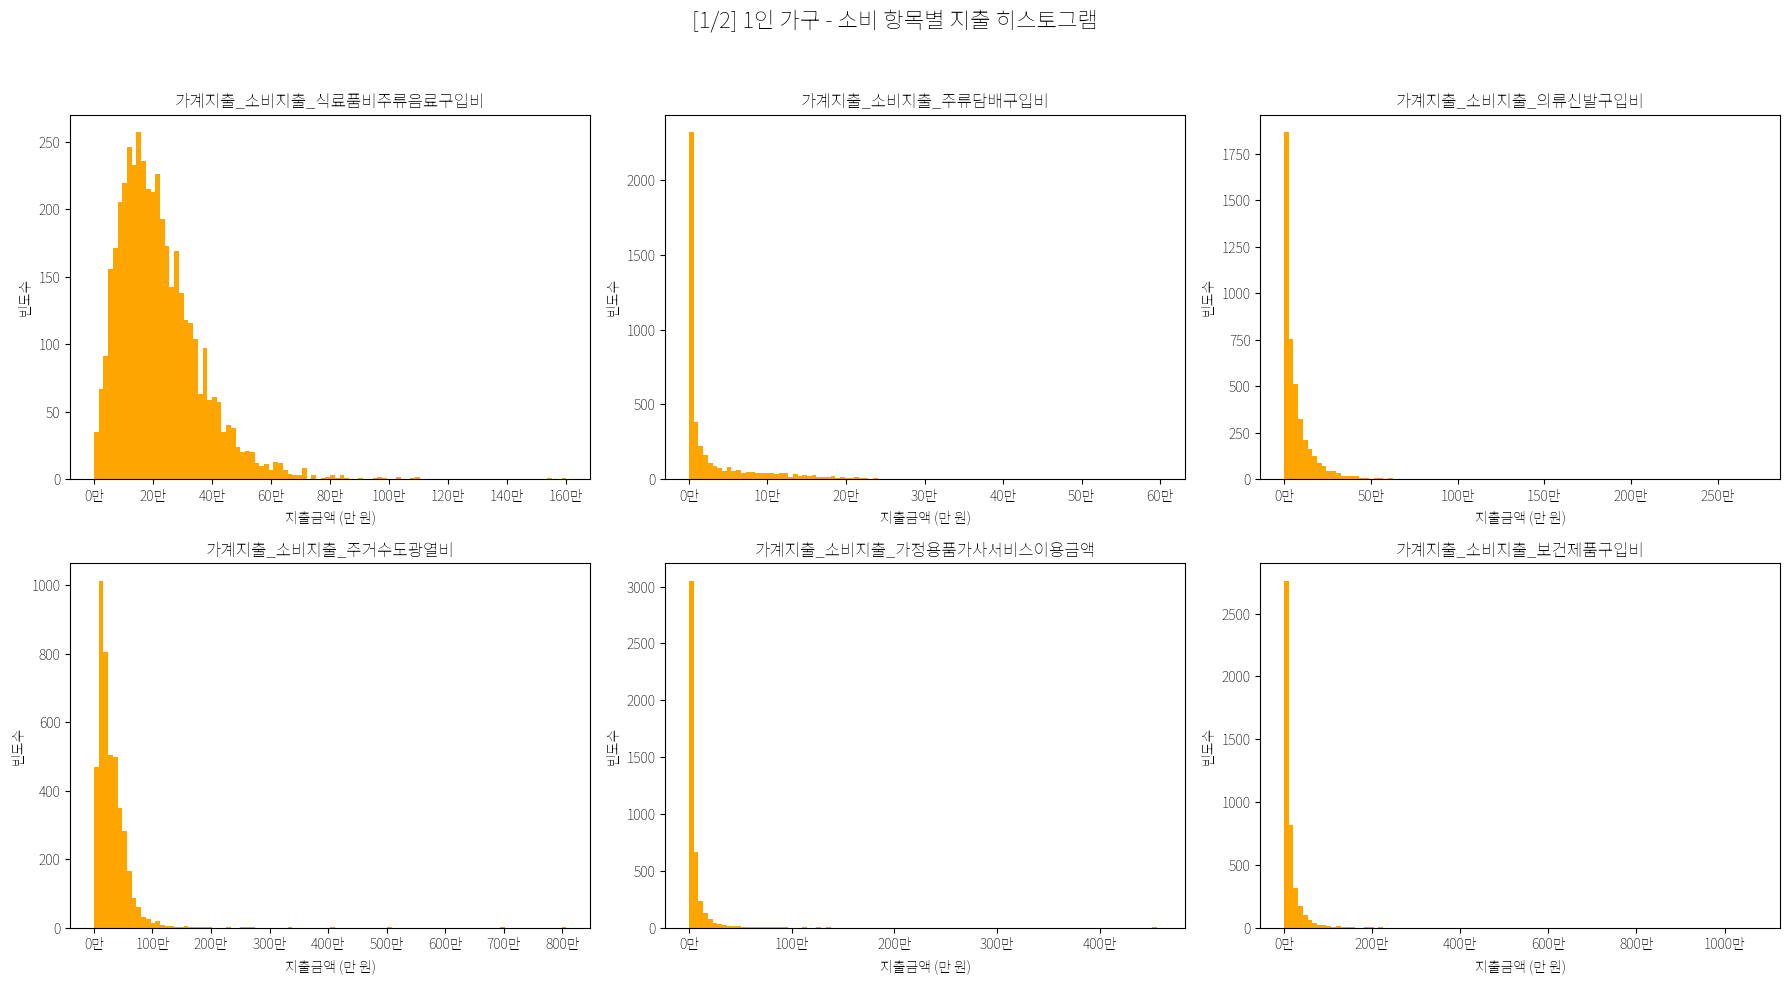

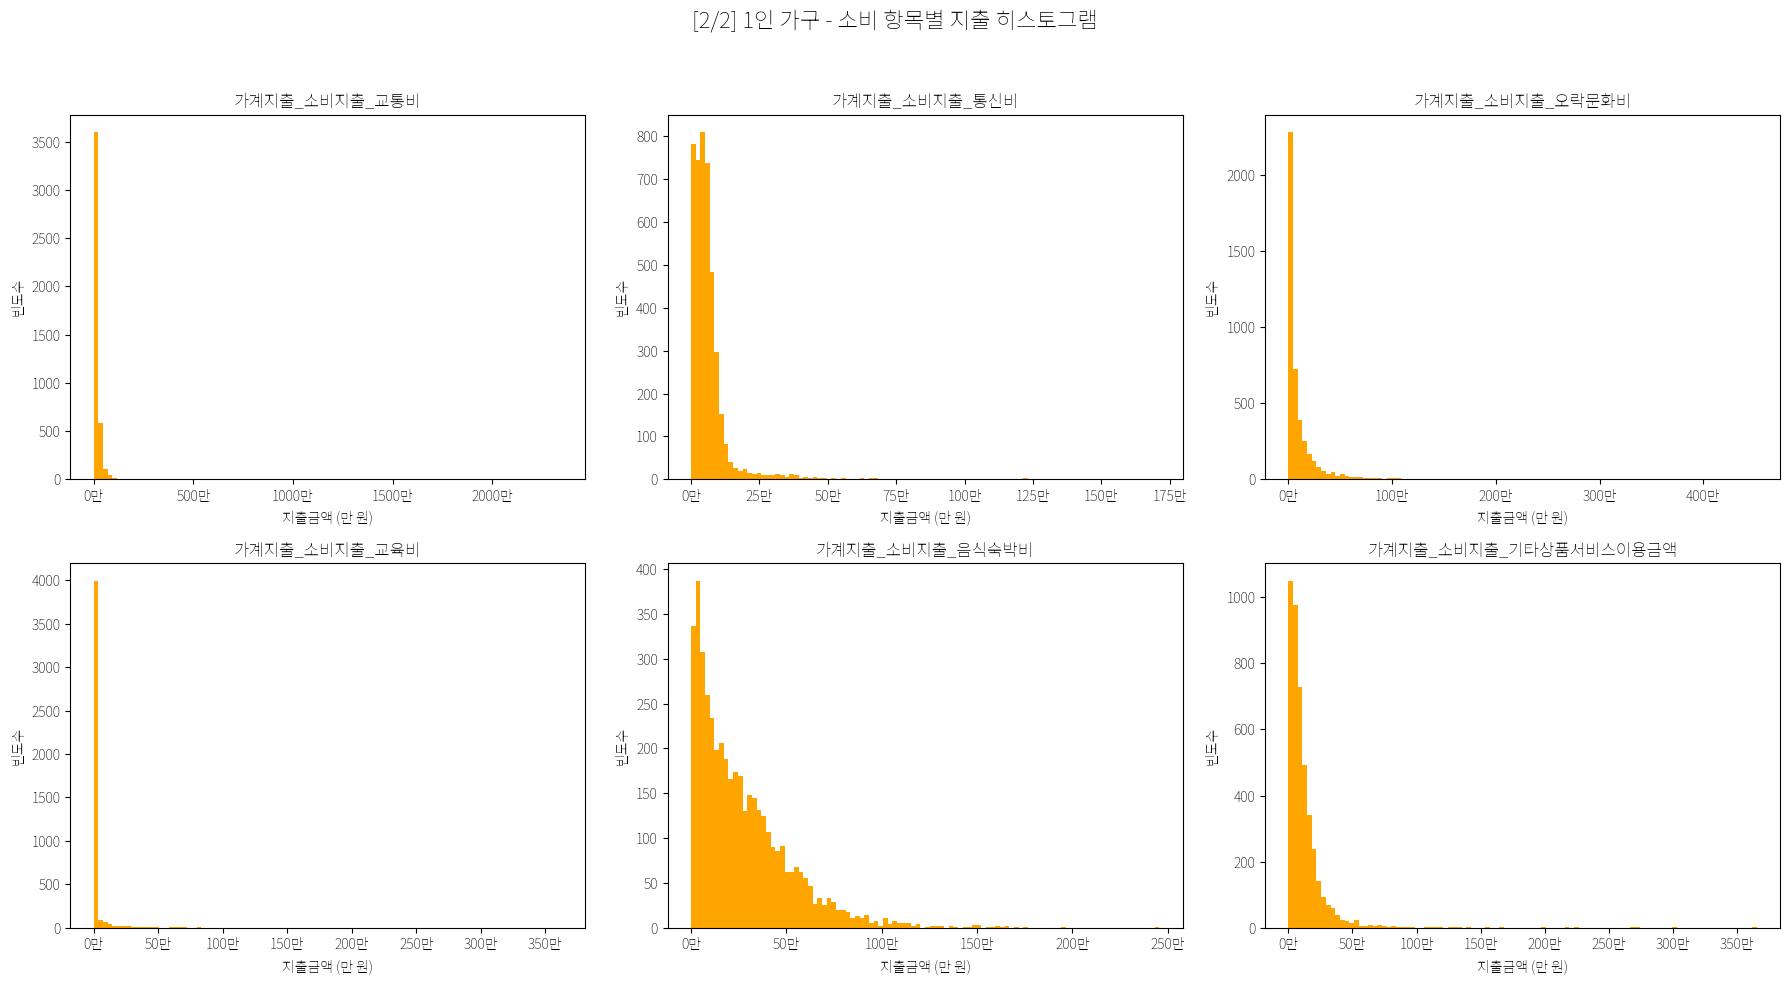

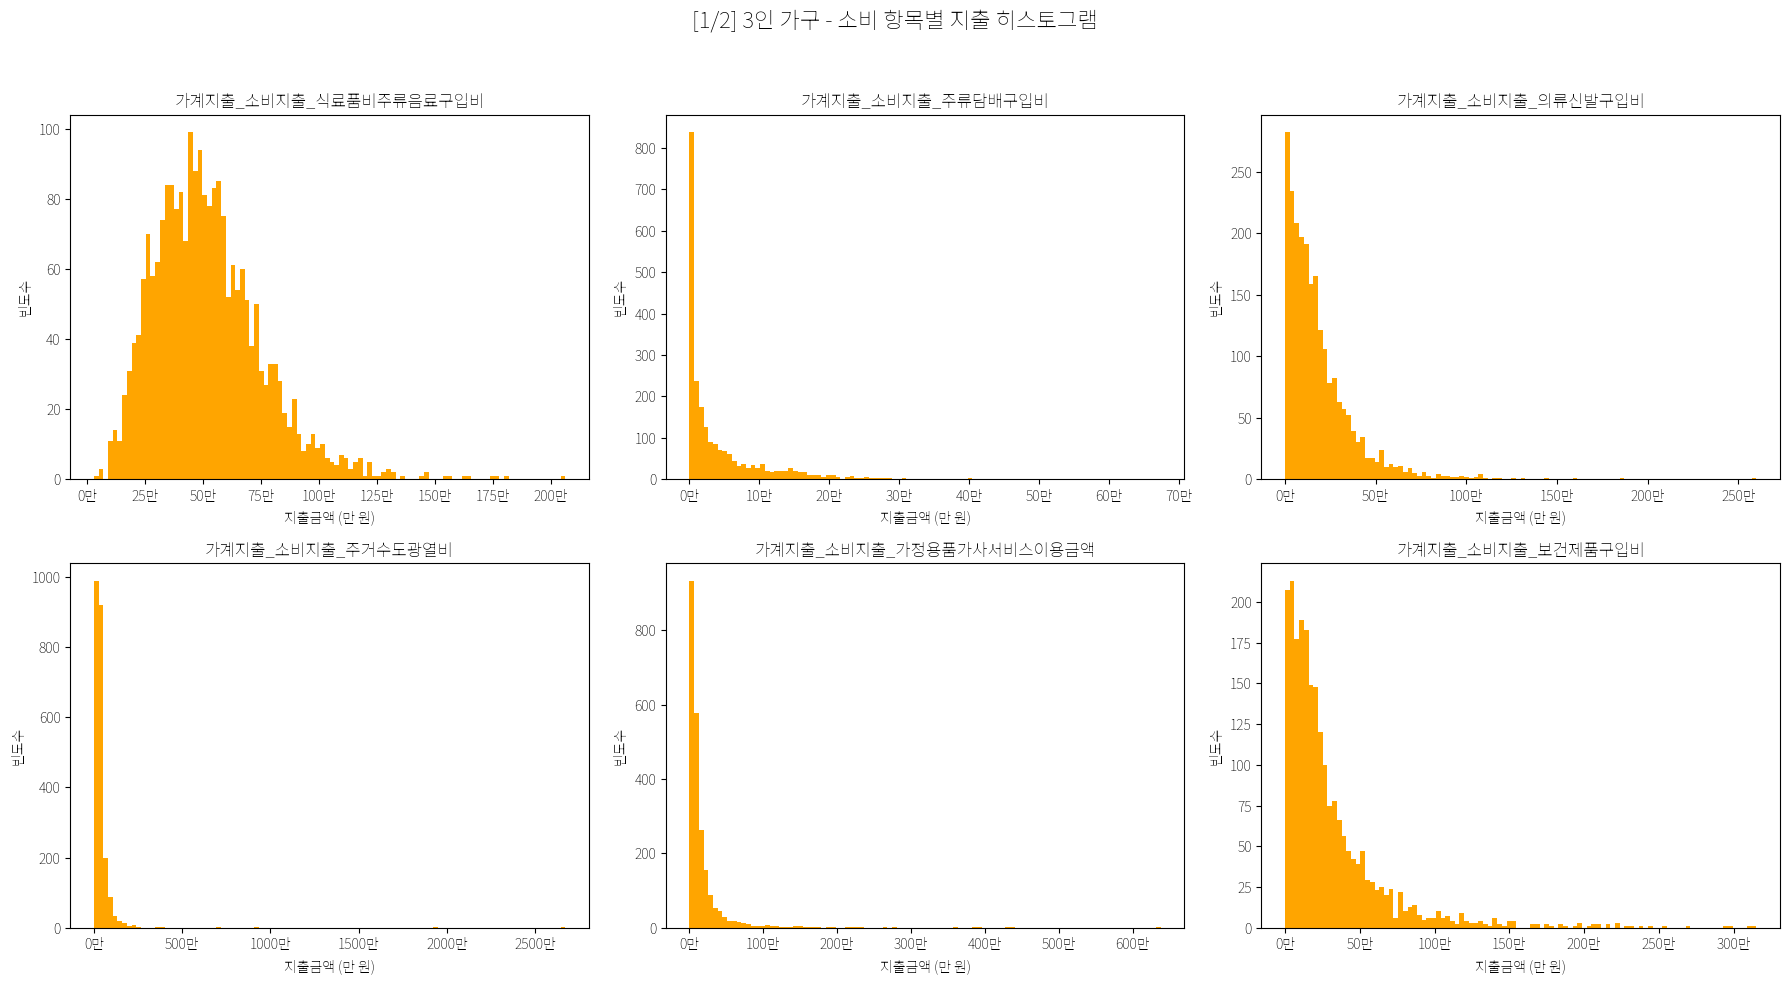

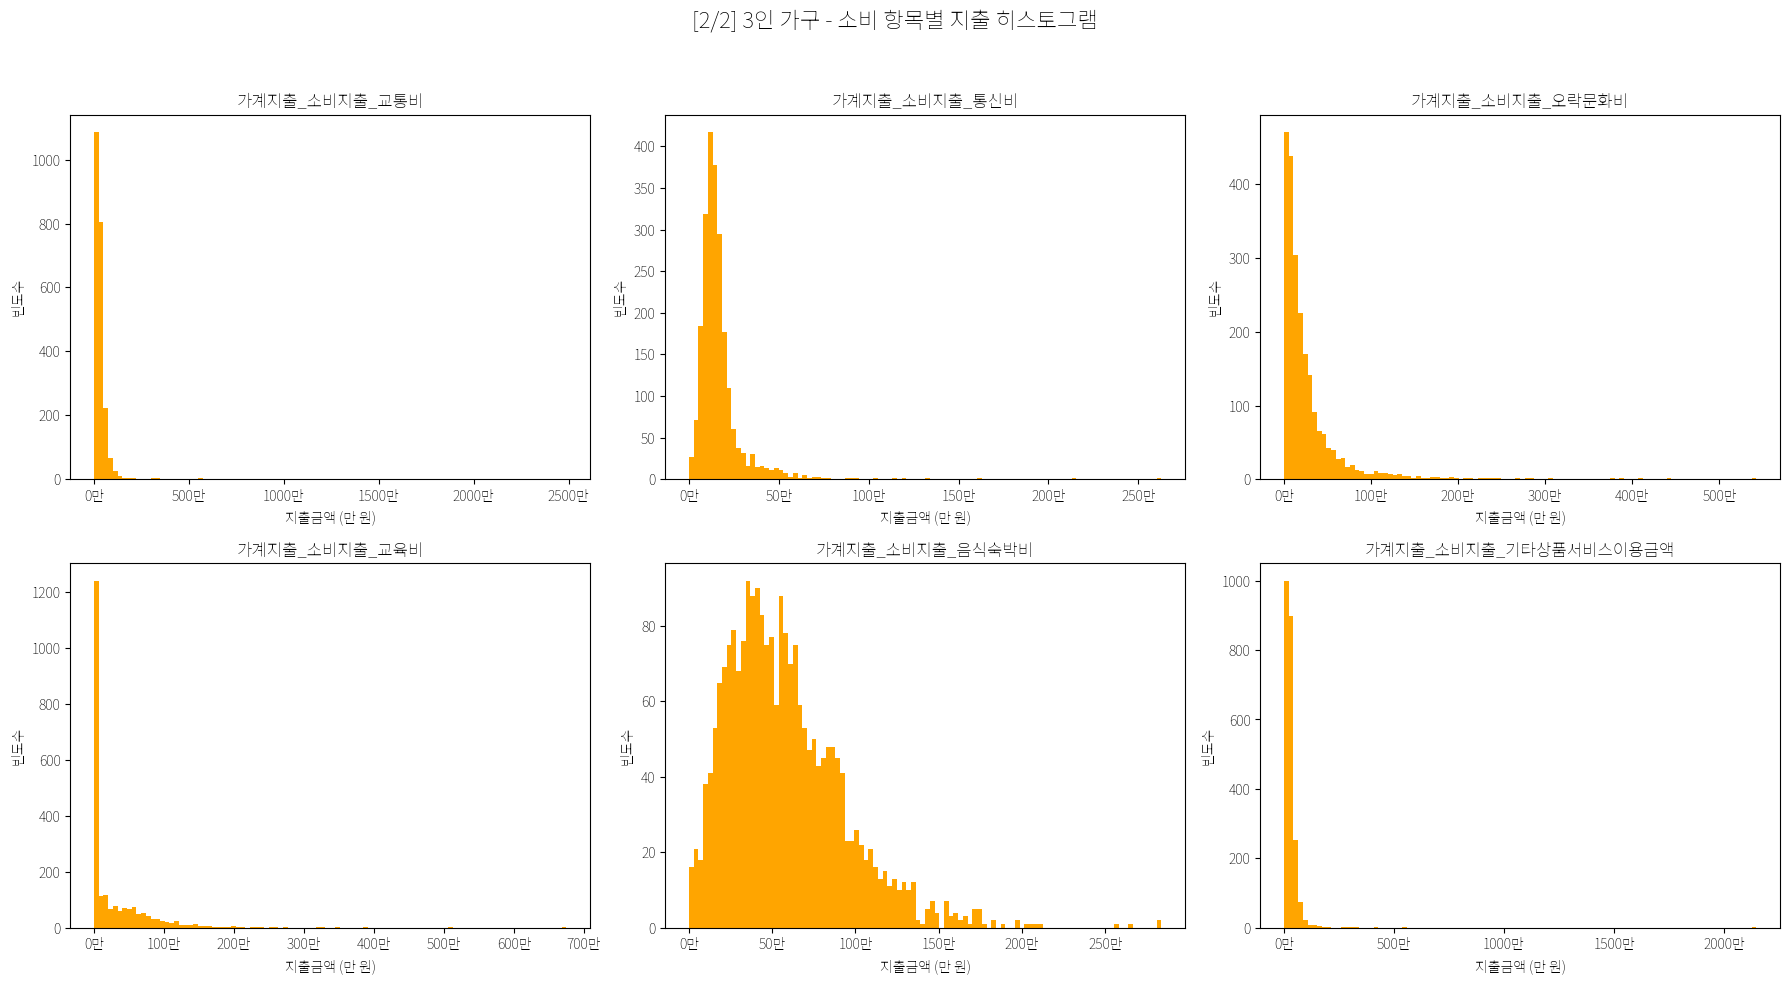

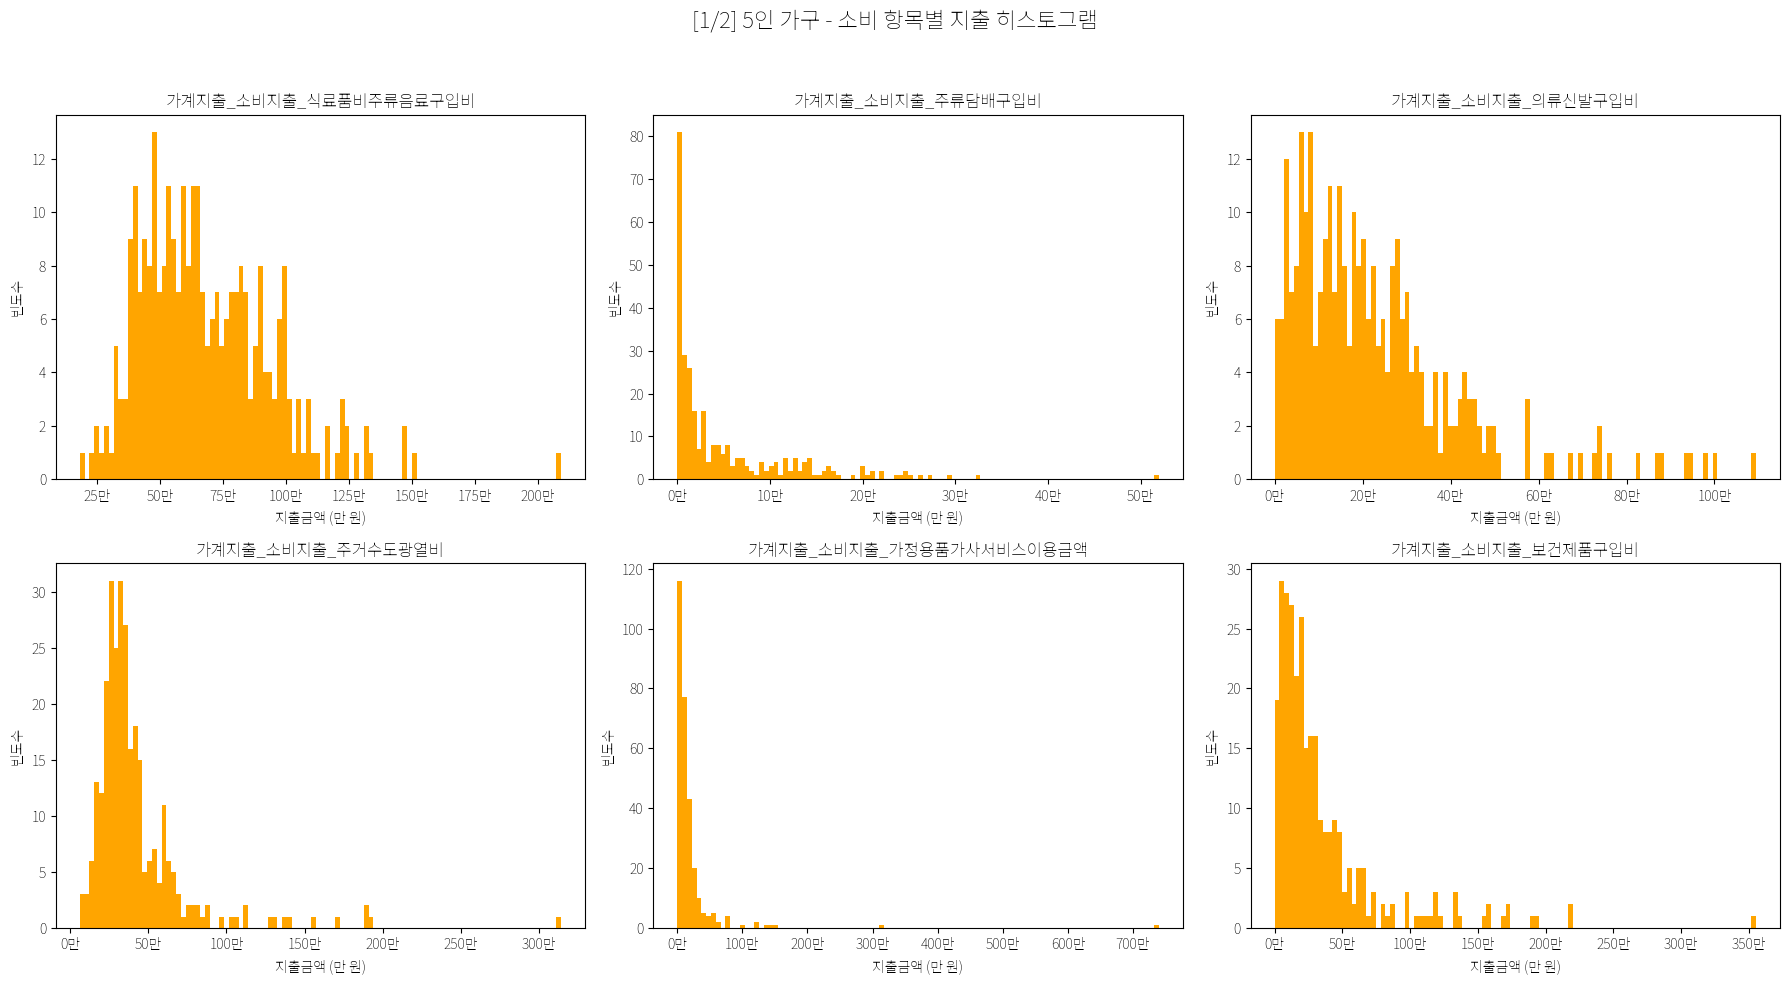

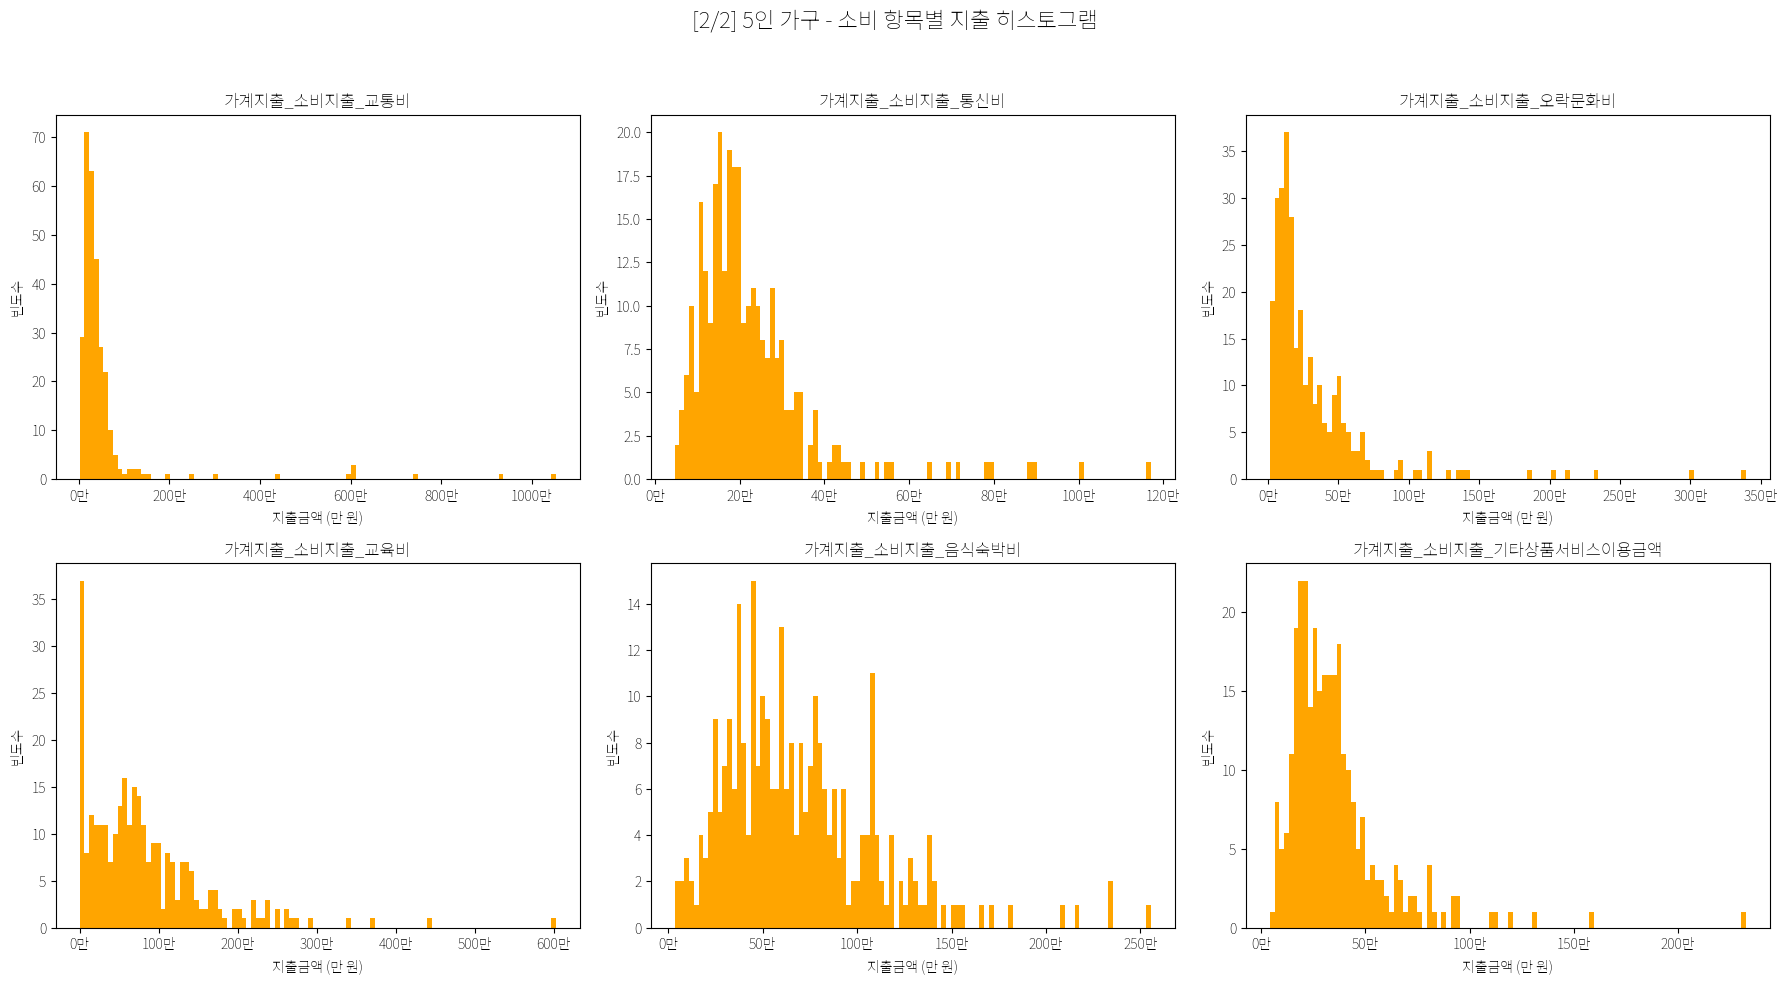

In [16]:
# Histogram

# 소비 항목 리스트
item_columns = [
    '가계지출_소비지출_식료품비주류음료구입비',
    '가계지출_소비지출_주류담배구입비',
    '가계지출_소비지출_의류신발구입비',
    '가계지출_소비지출_주거수도광열비',
    '가계지출_소비지출_가정용품가사서비스이용금액',
    '가계지출_소비지출_보건제품구입비',
    '가계지출_소비지출_교통비',
    '가계지출_소비지출_통신비',
    '가계지출_소비지출_오락문화비',
    '가계지출_소비지출_교육비',
    '가계지출_소비지출_음식숙박비',
    '가계지출_소비지출_기타상품서비스이용금액'
]

# 전체 가구원수에 대해 하면 histogram이 너무 많아지니 대략적으로 알 수 있게 1, 3, 5인으로만 진행. -> 모두 right-skewed의 성질을 가지는 것을 알 수 있음.
target_sizes = [1, 3, 5]


for size in target_sizes:
    subset = df_full[df_full['가구원수'] == size]

    # 첫 번째 6개 항목
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
    axes1 = axes1.flatten()
    for i, col in enumerate(item_columns[:6]):
        axes1[i].hist(subset[col].dropna(), bins=100, color='orange')
        axes1[i].set_title(col)
        axes1[i].set_xlabel("지출금액 (만 원)")
        axes1[i].set_ylabel("빈도수")
        axes1[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))
    plt.suptitle(f"[1/2] {size}인 가구 - 소비 항목별 지출 히스토그램", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 두 번째 6개 항목
    fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
    axes2 = axes2.flatten()
    for i, col in enumerate(item_columns[6:]):
        axes2[i].hist(subset[col].dropna(), bins=100, color='orange')
        axes2[i].set_title(col)
        axes2[i].set_xlabel("지출금액 (만 원)")
        axes2[i].set_ylabel("빈도수")
        axes2[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))
    plt.suptitle(f"[2/2] {size}인 가구 - 소비 항목별 지출 히스토그램", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [17]:
# 가구원수별로 각 항목당 outlier 몇개 있는지 알아보는 코드.
# 결과 저장
outlier_summary = []

# 각 가구원수에 대해
for size, group in df_full.groupby('가구원수'):
    for col in item_columns:
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = group[(group[col] < lower) | (group[col] > upper)]
        outlier_summary.append({
            '가구원수': int(size),
            '항목': col,
            '이상치수': len(outliers),
            '총샘플수': len(group),
            '비율(%)': round(len(outliers) / len(group) * 100, 2)
        })

# 데이터프레임 변환
outlier_df = pd.DataFrame(outlier_summary)

# 정렬
outlier_df = outlier_df.sort_values(by=['가구원수', '이상치수'], ascending=[True, False])

# 이상치 요약
outlier_df


가구원수                       항목  이상치수  총샘플수  비율(%)
9      1            가계지출_소비지출_교육비   582  4374  13.31
1      1        가계지출_소비지출_주류담배구입비   576  4374  13.17
4      1  가계지출_소비지출_가정용품가사서비스이용금액   448  4374  10.24
8      1          가계지출_소비지출_오락문화비   429  4374   9.81
5      1        가계지출_소비지출_보건제품구입비   401  4374   9.17
..   ...                      ...   ...   ...    ...
91     8            가계지출_소비지출_통신비     0     2   0.00
92     8          가계지출_소비지출_오락문화비     0     2   0.00
93     8            가계지출_소비지출_교육비     0     2   0.00
94     8          가계지출_소비지출_음식숙박비     0     2   0.00
95     8    가계지출_소비지출_기타상품서비스이용금액     0     2   0.00

[96 rows x 5 columns]

In [18]:
# outlier 처리
# 가구원수별로 그룹핑하고 너무 극단적으로 큰 값은 clipping 해주고, 전체에 log scaling. (log scaling은 그룹별로 안 해줘도 결과 똑같음.)
# Step 1: 가구원수별로 99.5% quantile 기준으로 clip
for col in item_columns:
    for size, group in df_full.groupby('가구원수'):
        threshold = group[col].quantile(0.995)
        mask = df_full['가구원수'] == size
        df_full.loc[mask, col] = df_full.loc[mask, col].clip(upper=threshold)


for col in item_columns:
    negative_values = df_full[df_full[col] < 0][col]
    if not negative_values.empty:
        print(f"컬럼 '{col}'에서 발견된 음수 값들:\n{negative_values.describe()}\n")
        
# Step 2: log1p 변환해서 "_log" 컬럼 추가
for col in item_columns:
    df_full[col + '_log'] = np.log1p(df_full[col])


# 결과와 확인하기 위해 12가지 소비 품목의 max값 각각 출력해보기.
print("\n클리핑 및 로그변환 후 원본 item_columns의 max값 (확인용):")
print(df_full[item_columns].max())


클리핑 및 로그변환 후 원본 item_columns의 max값 (확인용):
가계지출_소비지출_식료품비주류음료구입비      1550443.140
가계지출_소비지출_주류담배구입비           311189.805
가계지출_소비지출_의류신발구입비          1349508.945
가계지출_소비지출_주거수도광열비          2213982.630
가계지출_소비지출_가정용품가사서비스이용금액    2406008.280
가계지출_소비지출_보건제품구입비          3274055.500
가계지출_소비지출_교통비              9726700.800
가계지출_소비지출_통신비               957314.425
가계지출_소비지출_오락문화비            2682749.075
가계지출_소비지출_교육비              4088130.635
가계지출_소비지출_음식숙박비            2445591.240
가계지출_소비지출_기타상품서비스이용금액      2364572.460
dtype: float64


In [19]:
# Feature creation
# 가구원수가 다르면 소비 금액이 달라지는 게 당연하므로, 소비 품목 / 소비지출로 비율 구해서 새로운 열로 추가.
# 총 소비지출금액
total_column = '가계지출_소비지출금액'

# 각 항목의 비율 계산
for col in item_columns:
    ratio_col = col + '_비율'
    df_full[ratio_col] = df_full[col] / (df_full[total_column] + 1e-5)  # 0 나누기 방지용 작은 수 추가

df_full.head()

조사연월  가구구분코드  가구원수  취업인원수  노인가구여부  가구주_연령  가구주_학력코드  가구주_취업여부  \
0  202400.0     1.0   1.0    1.0     0.0    17.0       4.0       1.0   
1  202400.0     1.0   1.0    1.0     0.0    19.0       4.0       1.0   
2  202400.0     1.0   1.0    1.0     0.0    19.0       4.0       1.0   
3  202400.0     1.0   1.0    1.0     0.0    19.0       4.0       1.0   
4  202400.0     1.0   1.0    1.0     0.0    19.0       5.0       1.0   

  가구주_10차산업분류코드  거처구분코드  ...  가계지출_소비지출_의류신발구입비_비율  가계지출_소비지출_주거수도광열비_비율  \
0             I     1.0  ...              0.011099              0.381708   
1             C     1.0  ...              0.035998              0.234376   
2             C     1.0  ...              0.120325              0.206902   
3             R     1.0  ...              0.021663              0.582180   
4             G     1.0  ...              0.000000              0.384890   

   가계지출_소비지출_가정용품가사서비스이용금액_비율  가계지출_소비지출_보건제품구입비_비율  가계지출_소비지출_교통비_비율  \
0                    0.028709              0.006628          0.207132   
1                    0.017283              0.033483          0.111317   
2                    0.031597              0.022435          0.040364   
3                    0.011655              0.007928          0.035280   
4                    0.000000              0.000000          0.039740   

   가계지출_소비지출_통신비_비율  가계지출_소비지출_오락문화비_비율  가계지출_소비지출_교육비_비율  가계지출_소비지출_음식숙박비_비율  \
0          0.028816            0.028053          0.000000            0.085345   
1          0.035998            0.076032          0.000000            0.319090   
2          0.015690            0.111987          0.042225            0.260538   
3          0.001115            0.045594          0.000000            0.214312   
4          0.025382            0.013505          0.000000            0.387781   

   가계지출_소비지출_기타상품서비스이용금액_비율  
0                  0.069448  
1                  0.078761  
2                  0.078147  
3                  0.014298  
4                  0.007692  

[5 rows x 52 columns]

# Encoding

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. 산업 코드 대분류 그룹화 함수 정의
def map_industry_group(code):
    if code in ['A']:
        return '1차산업'
    elif code in ['B', 'C', 'D', 'E', 'F']:
        return '제조건설업'
    elif code in ['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']:
        return '서비스업'
    elif code in ['O', 'P', 'Q']:
        return '공공/교육/보건'
    else:
        return '기타'

df_full['산업_대분류'] = df_full['가구주_10차산업분류코드'].map(map_industry_group)

# 범주형 코드값 실제 명칭으로 매핑

def map_residence_group(code):
    if code in ['2.0']:
        return '아파트'
    elif code in ['3.0']:
        return '연립주택'
    elif code in ['4.0']:
        return '다세대주택'
    elif code in ['5.0']:
        return '비거주용건물'
    elif code in ['6.0']:
        return '오피스텔'
    elif code in ['7.0']:
        return '기타'        
    else:
        return '단독주택'

df_full['거처구분코드'] = df_full['거처구분코드'].astype(str)
df_full['거주구분_명칭'] = df_full['거처구분코드'].map(map_residence_group)

def map_household_group(code):
    if code in ['2.0']:
        return '비근로자가구'
    else:
        return '근로자가구'

df_full['가구구분코드'] = df_full['가구구분코드'].astype(str)
df_full['가구구분_명칭'] = df_full['가구구분코드'].map(map_household_group)

def map_employment_group(code):
    if code in ['2.0']:
        return '비취업'
    else:
        return '취업'
df_full['가구주_취업여부'] = df_full['가구주_취업여부'].astype(str)
df_full['가구주_취업상태'] = df_full['가구주_취업여부'].map(map_employment_group)

def map_house_group(code):
    if code in ['2.0']:
        return '무상주택'
    elif code in ['3.0']:
        return '사택'
    elif code in ['4.0']:
        return '전세'
    elif code in ['5.0']:
        return '영구임대'
    elif code in ['6.0']:
        return '보증부_월세'
    elif code in ['7.0']:
        return '보증금_없는_월세'
    else:
        return '자가'
        
df_full['입주형태코드'] = df_full['입주형태코드'].astype(str)
df_full['입주형태_명칭'] = df_full['입주형태코드'].map(map_house_group)


In [21]:

# 1. 인코딩할 범주형 컬럼 지정
categorical_features = [
    '가구구분_명칭',
    '가구주_취업상태',
    '거주구분_명칭',
    '입주형태_명칭',
    '산업_대분류'  # ← 앞서 그룹화한 것
]

# df_full에 해당 column들이 모두 존재하는지 확인
col_named = [col for col in categorical_features if col in df_full.columns]

if not col_named:
    print("Error: There isn't columns in df_Full")
else:
    # pd.get_dummies를 사용하여 원핫인코딩 (drop_first=True로 다중공선성 방지)
    # 생성되는 컬럼명은 자동으로 "원본컬럼명_카테고리명칭" 형태가 됨
    encoded_df = pd.get_dummies(df_full[col_named],
                                drop_first = True)
    # 기존 df_full에서 매핑에 사용된 컬럼들 제거
    origin_col = [
        '가구구분코드',
        '가구주_취업여부',
        '거처구분코드',
        '입주형태코드',
        '가구주_10차산업분류코드'
    ] + col_named

    # df_full에 실제로 있는 column만 drop 리스트에 포함
    final_col_to_drop = [col for col in origin_col if col in df_full.columns]

    df_full_numerical = df_full.drop(columns = final_col_to_drop)
    df_full_final_encoded = pd.concat([df_full_numerical, encoded_df], axis = 1)
    df_full = df_full_final_encoded.copy()

    df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   조사연월                         13478 non-null  float64
 1   가구원수                         13478 non-null  float64
 2   취업인원수                        13478 non-null  float64
 3   노인가구여부                       13478 non-null  float64
 4   가구주_연령                       13478 non-null  float64
 5   가구주_학력코드                     13478 non-null  float64
 6   전국전체가구_1인이상소득10분위코드          13478 non-null  float64
 7   소득구간코드                       13478 non-null  float64
 8   가계지출금액                       13478 non-null  float64
 9   가계지출_소비지출금액                  13478 non-null  float64
 10  가계지출_소비지출_식료품비주류음료구입비        13478 non-null  float64
 11  가계지출_소비지출_주류담배구입비            13478 non-null  float64
 12  가계지출_소비지출_의류신발구입비            13478 non-null  float64
 13  가계지출_소비지출_주거수도광열

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 69 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   조사연월                         float64
 1   가구원수                         float64
 2   취업인원수                        float64
 3   노인가구여부                       float64
 4   가구주_연령                       float64
 5   가구주_학력코드                     float64
 6   전국전체가구_1인이상소득10분위코드          float64
 7   소득구간코드                       float64
 8   가계지출금액                       float64
 9   가계지출_소비지출금액                  float64
 10  가계지출_소비지출_식료품비주류음료구입비        float64
 11  가계지출_소비지출_주류담배구입비            float64
 12  가계지출_소비지출_의류신발구입비            float64
 13  가계지출_소비지출_주거수도광열비            float64
 14  가계지출_소비지출_가정용품가사서비스이용금액      float64
 15  가계지출_소비지출_보건제품구입비            float64
 16  가계지출_소비지출_교통비                float64
 17  가계지출_소비지출_통신비                float64
 18  가계지출_소비지출_오락문화비              float64
 19  가계지출

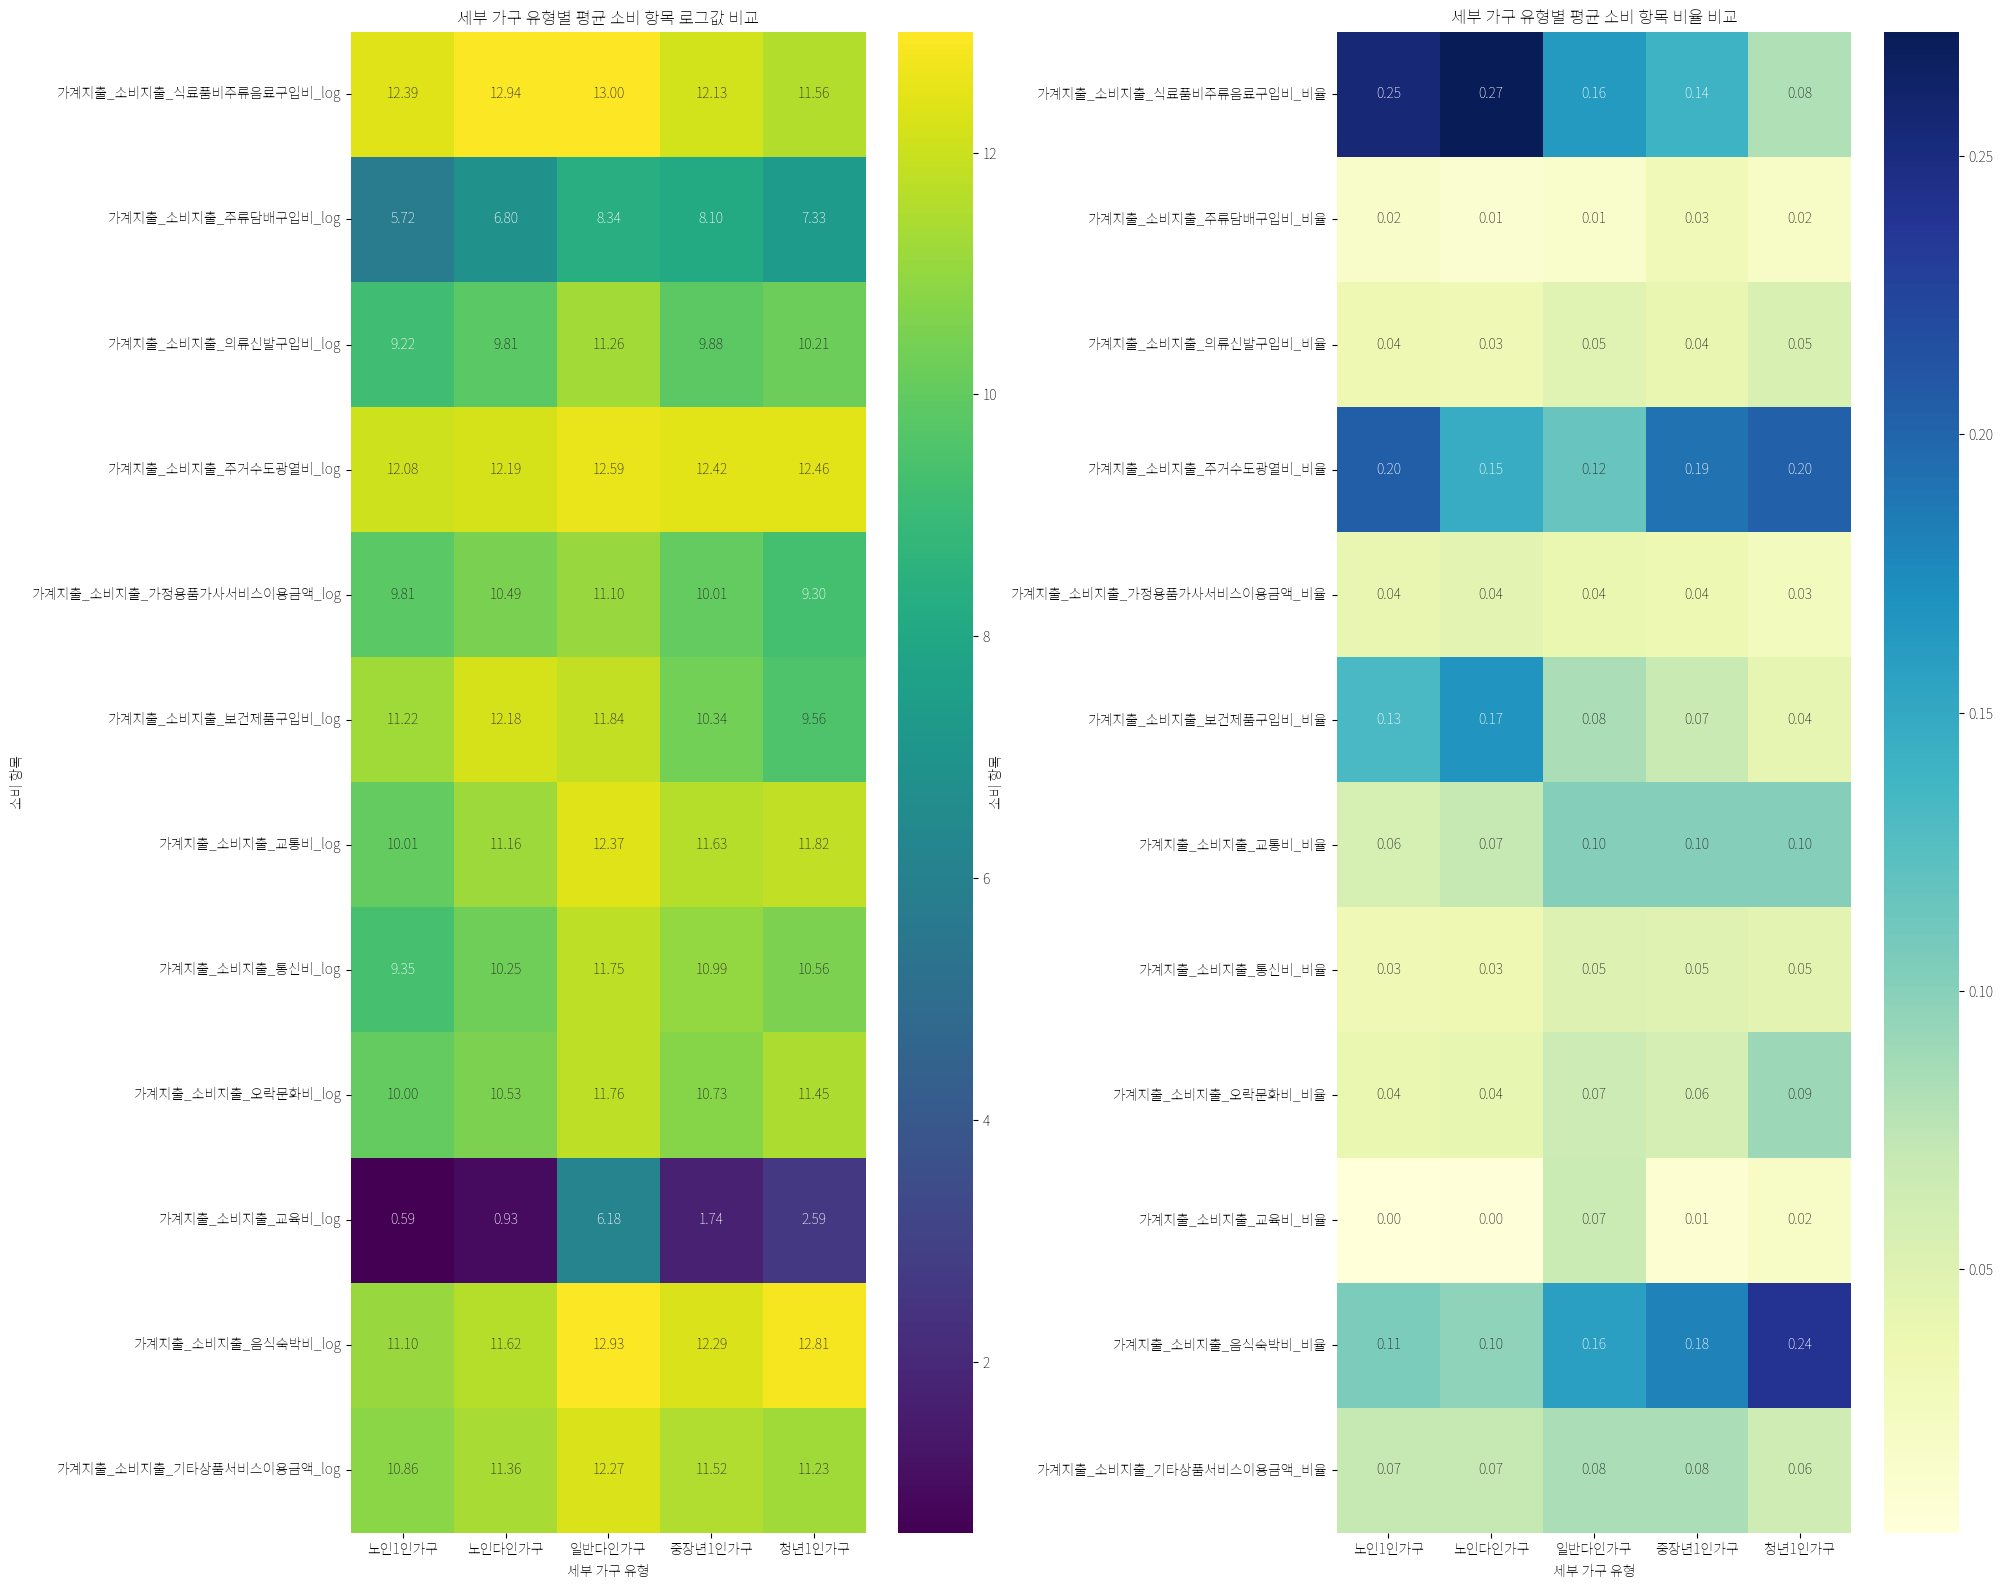

In [22]:
def get_detailed_household_type_eda(row):
    members = row['가구원수']
    age_group = row['가구주_연령'] # 문자열로 변환하여 안전하게 처리
    is_senior_household = row['노인가구여부'] == 1

    if members == 1:
        if age_group < 40: # 40대 이전의 나이대 사람들을 청년으로 설정
            return '청년1인가구'
        elif age_group < 60: # 60대 이전의 나이대 사람들을 중장년으로 설정
            return '중장년1인가구'
        elif is_senior_household or age_group >= 60: # 노인가구여부 우선 고려
            return '노인1인가구'
        else:
            return '기타1인가구' # 혹시 모를 경우
    elif members > 1:
        if is_senior_household:
            return '노인다인가구'
        else:
            return '일반다인가구'
    return '기타가구유형'

df_full['세부가구유형'] = df_full.apply(get_detailed_household_type_eda, axis=1)

analysis_cols_log = [f"{col}_log" for col in item_columns]
analysis_cols_ratio = [f"{col}_비율" for col in item_columns]

group_means_log = df_full.groupby('세부가구유형')[analysis_cols_log].mean()
group_means_ratio = df_full.groupby('세부가구유형')[analysis_cols_ratio].mean()

df_encoded_household_type = pd.get_dummies(df_full['세부가구유형'], 
                                           prefix='세부가구유형', 
                                           drop_first=True) # 또는 False

# 기존 df_full에 인코딩된 컬럼들을 병합하고, 원본 '세부가구유형' 컬럼은 제거합니다.
df_full_with_ohe = pd.concat([df_full.drop(columns=['세부가구유형']), df_encoded_household_type], axis=1)

# df_full 변수를 업데이트
df_full = df_full_with_ohe.copy()

df_full.info(verbose=True, max_cols=10) # 일부 컬럼만 출력하여 확인

ohe_cols = [col for col in df_full.columns if col.startswith('세부가구유형_')]

# 히트맵으로 시각화
fig, axes = plt.subplots(1, 2, figsize = (20, 16))

sns.heatmap(group_means_log.T, annot = True, fmt = ".2f", cmap = "viridis", ax = axes[0])
axes[0].set_title("세부 가구 유형별 평균 소비 항목 로그값 비교")
axes[0].set_ylabel("소비 항목")
axes[0].set_xlabel("세부 가구 유형")

sns.heatmap(group_means_ratio.T, annot = True, fmt = ".2f", cmap = "YlGnBu", ax = axes[1])
axes[1].set_title("세부 가구 유형별 평균 소비 항목 비율 비교")
axes[1].set_ylabel("소비 항목")
axes[1].set_xlabel("세부 가구 유형")

plt.tight_layout()
plt.show()


In [23]:
columns_to_drop = ['기구주_10차산업분류코드', '조사연월']

cols_to_drop = [col for col in columns_to_drop if col in df_full.columns]
df = df_full.drop(columns = cols_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13478 entries, 0 to 13477
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   가구원수                         13478 non-null  float64
 1   취업인원수                        13478 non-null  float64
 2   노인가구여부                       13478 non-null  float64
 3   가구주_연령                       13478 non-null  float64
 4   가구주_학력코드                     13478 non-null  float64
 5   전국전체가구_1인이상소득10분위코드          13478 non-null  float64
 6   소득구간코드                       13478 non-null  float64
 7   가계지출금액                       13478 non-null  float64
 8   가계지출_소비지출금액                  13478 non-null  float64
 9   가계지출_소비지출_식료품비주류음료구입비        13478 non-null  float64
 10  가계지출_소비지출_주류담배구입비            13478 non-null  float64
 11  가계지출_소비지출_의류신발구입비            13478 non-null  float64
 12  가계지출_소비지출_주거수도광열비            13478 non-null  float64
 13  가계지출_소비지출_가정용품가사

## 분류 분석 목표 EDA: 타겟 변수 정의 및 피쳐 관계 탐색

- 1인 가구의 경우 배달음식을 시켜먹는 비율이 높을 것이라고 예상
- target 변수를 음식숙박비 비율로 설정 후 EDA 진행

In [24]:
# 1인가구 데이터만 필터링
df_single = df[df['가구원수'] == 1].copy()

# 타겟으로 삼을 소비 항목 컬럼 선택
target_consumption = '가계지출_소비지출_음식숙박비_log'

if target_consumption in df_single.columns:
    # 1인 가구 내에서 해당 소비 비율의 상위 30% 기준점 찾기
    threshold = df_single[target_consumption].quantile(0.70)

    # 타겟 변수 생성: 기준점 이상이면 고지출(1), 아니면 0
    df_single['y_음식숙박_고지출'] = (df_single[target_consumption] >= threshold).astype(int)
    
    print(df_single['y_음식숙박_고지출'].value_counts(normalize=True))

y_음식숙박_고지출
0    0.700046
1    0.299954
Name: proportion, dtype: float64


--- 최종 demographic_features 리스트 ---
['가구구분_명칭_비근로자가구', '가구주_연령', '가구주_취업상태_취업', '거주구분_명칭_다세대주택', '거주구분_명칭_단독주택', '거주구분_명칭_비거주용건물', '거주구분_명칭_아파트', '거주구분_명칭_연립주택', '거주구분_명칭_오피스텔', '산업_대분류_공공/교육/보건', '산업_대분류_기타', '산업_대분류_서비스업', '산업_대분류_제조건설업', '입주형태_명칭_보증금_없는_월세', '입주형태_명칭_보증부_월세', '입주형태_명칭_사택', '입주형태_명칭_영구임대', '입주형태_명칭_자가', '입주형태_명칭_전세', '전국전체가구_1인이상소득10분위코드']


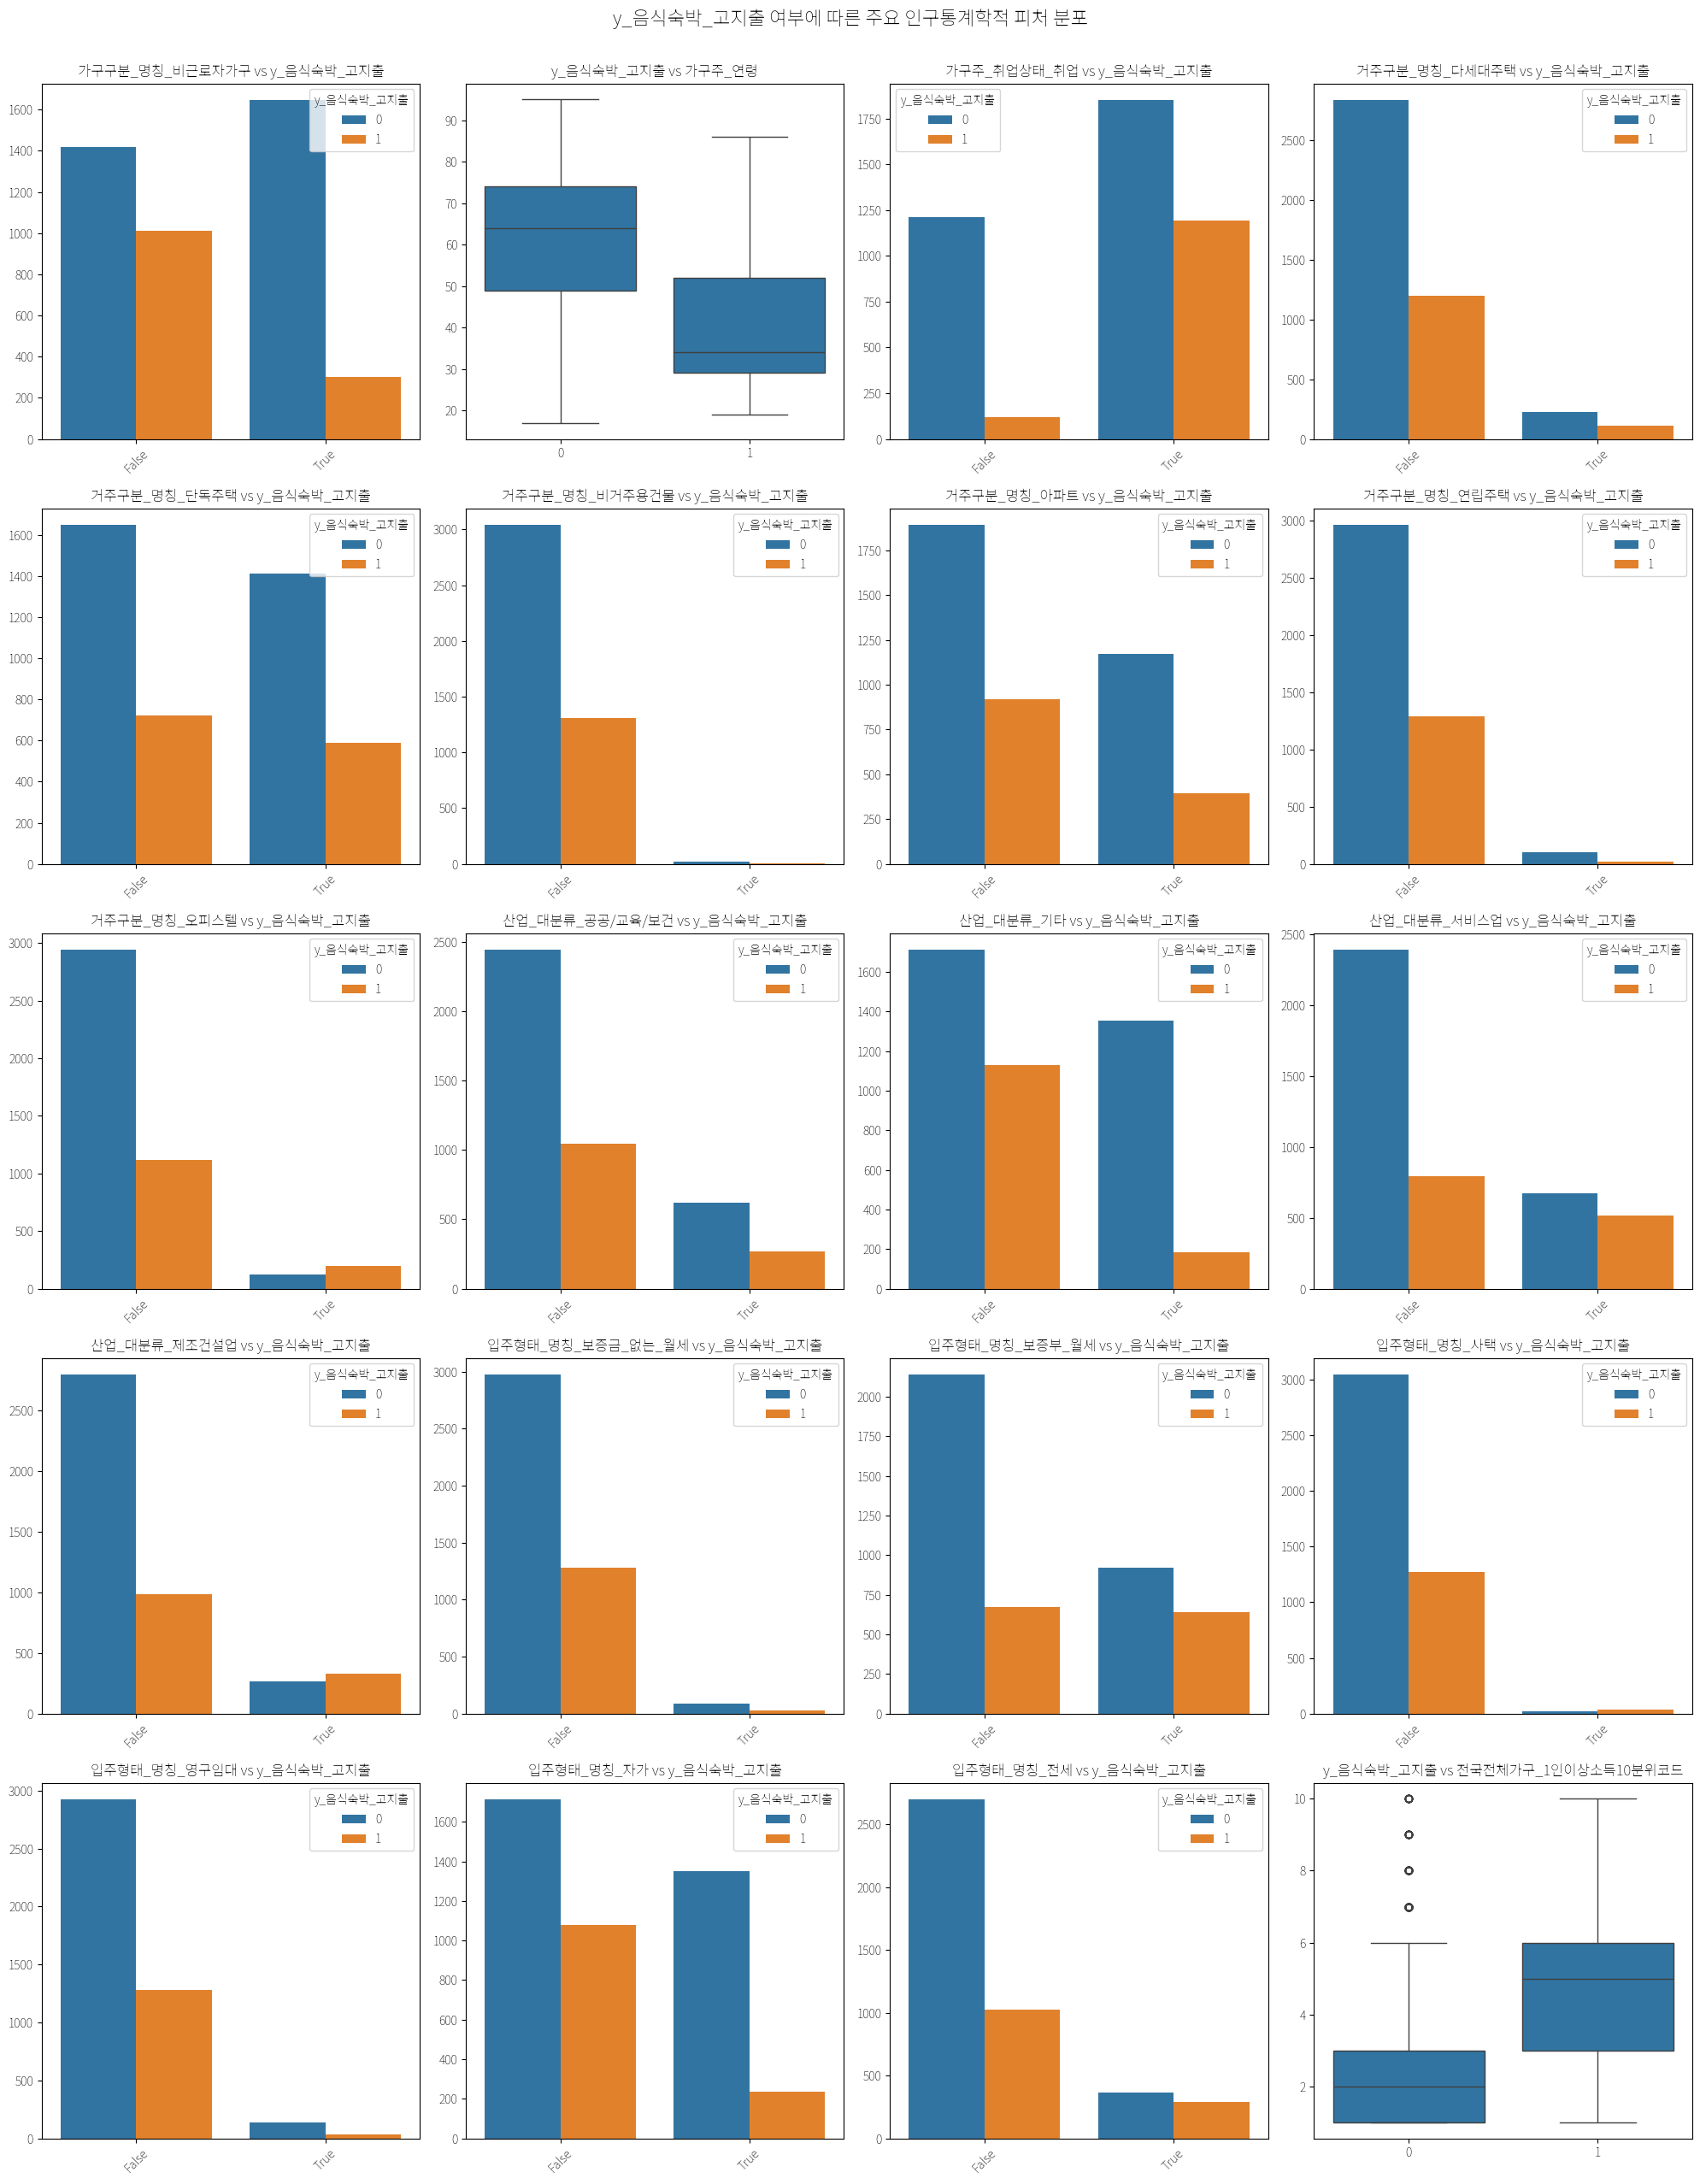

In [25]:
# feature를 선정하기 전 인류 통께학에 사용될 가능성이 있는 feature들을 정리

household_ohe_col = [col for col in df_single.columns if col.startswith('가구구분_명칭_')]
employment_ohe_col = [col for col in df_single.columns if col.startswith('가구주_취업상태_')]
residence_ohe_col = [col for col in df_single.columns if col.startswith('거주구분_명칭_')]
house_ohe_col = [col for col in df_single.columns if col.startswith('입주형태_명칭_')]
industry_ohe_col = [col for col in df_single.columns if col.startswith('산업_대분류_')]


# 타겟 변수가 df_single에 제대로 생성되었는지 확인 후 진행
if 'y_음식숙박_고지출' in df_single.columns:
    y_target_csf_single = 'y_음식숙박_고지출'

    # A. 인구통계학적 feature vs target
    demographic_features = [
        '가구주_연령', '전국전체가구_1인이상소득10분위코드'
    ]

    original_named = [
    '가구구분_명칭',
    '가구주_취업상태', 
    '거주구분_명칭',   
    '입주형태_명칭',
    '산업_대분류'
    ]

    for original_col in original_named:
        ohe_cols = [col for col in df_single.columns if col.startswith(original_col + '_')]
        demographic_features.extend(ohe_cols)

    demographic_features = sorted(list(set(col for col in demographic_features if col in df_single.columns)))

    print("--- 최종 demographic_features 리스트 ---")
    print(demographic_features) # 리스트 내용 전체 확인
    
    # y_target_csf 변수 확인
if 'y_음식숙박_고지출' in df_single.columns:
    y_target_csf_single = 'y_음식숙박_고지출'
else:
    print(f"경고: 타겟 변수 '{y_target_csf_single}'가 df_single에 없습니다. EDA를 진행할 수 없습니다.")
    # 여기서 중단하거나 기본값 설정 등의 처리가 필요할 수 있음.
    # 여기서는 일단 y_target_csf가 있다고 가정하고 진행.
    # 만약 이전에 다른 이름으로 타겟 변수를 만드셨다면 그 이름을 사용해야함.

# 그래프를 그릴 피처들만 필터링 (df_single에 실제로 존재하는 컬럼들)
features_to_plot = [f for f in demographic_features if f in df_single.columns]

if not features_to_plot:
    print("알림: 그래프를 그릴 피처가 df_single에 없습니다.")
else:
    # 5x4 subplot 설정 (총 20개 그래프)
    num_features = len(features_to_plot)
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols # 피처 개수에 맞춰 행 수 자동 계산

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5)) # figsize는 전체 그림 크기
    axes = axes.flatten() # 다차원 배열의 axes를 1차원으로 펴서 사용하기 쉽게 만듭니다.

    for i, feature in enumerate(features_to_plot):
        ax = axes[i] # 현재 그래프를 그릴 subplot 선택
        
        # feature가 문자열인지 먼저 확인
        if not isinstance(feature, str):
            ax.set_title(f"부적절한 피처: {feature}")
            ax.axis('off') # 부적절한 피처는 그래프 그리지 않음
            continue

        current_column_series = df_single[feature]
        is_numeric = pd.api.types.is_numeric_dtype(current_column_series)
        nunique_count = current_column_series.nunique()
        
        if nunique_count > 5 and is_numeric:
            sns.boxplot(data=df_single, x=y_target_csf_single, y=feature, ax=ax)
            ax.set_title(f'{y_target_csf_single} vs {feature}') # 축약된 제목
        else: # 범주형 또는 유니크값이 적은 숫자형
            sns.countplot(data=df_single, x=feature, hue=y_target_csf_single, ax=ax)
            ax.set_title(f'{feature} vs {y_target_csf_single}') # 축약된 제목
            ax.tick_params(axis='x', rotation=45) # x축 레이블 회전 (필요시)
        
        ax.set_xlabel('') # 개별 x축 레이블은 생략하거나 간결하게
        ax.set_ylabel('') # 개별 y축 레이블은 생략하거나 간결하게

    for j in range(num_features, nrows * ncols):
        fig.delaxes(axes[j]) # 또는 axes[j].axis('off')

    plt.tight_layout() # 전체 레이아웃 조정
    plt.suptitle(f'{y_target_csf_single} 여부에 따른 주요 인구통계학적 피처 분포', fontsize=16, y=1.02) # 전체 제목
    plt.show()



--- '가구구분_명칭_비근로자가구' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출             0         1
가구구분_명칭_비근로자가구                    
False           0.583848  0.416152
True            0.844890  0.155110


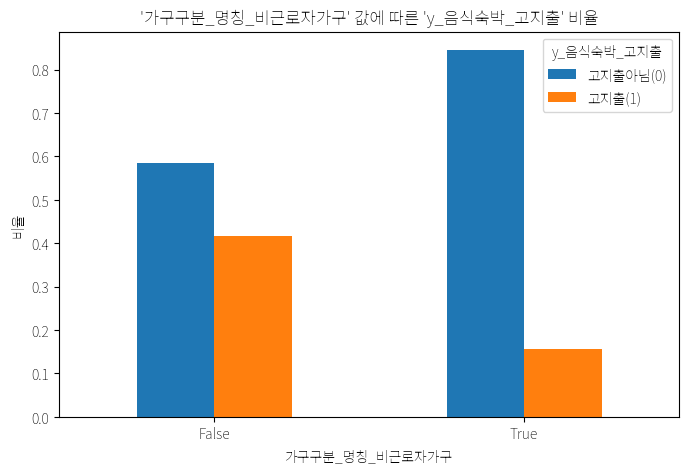


--- '가구주_취업상태_취업' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출          0         1
가구주_취업상태_취업                    
False        0.910661  0.089339
True         0.607824  0.392176


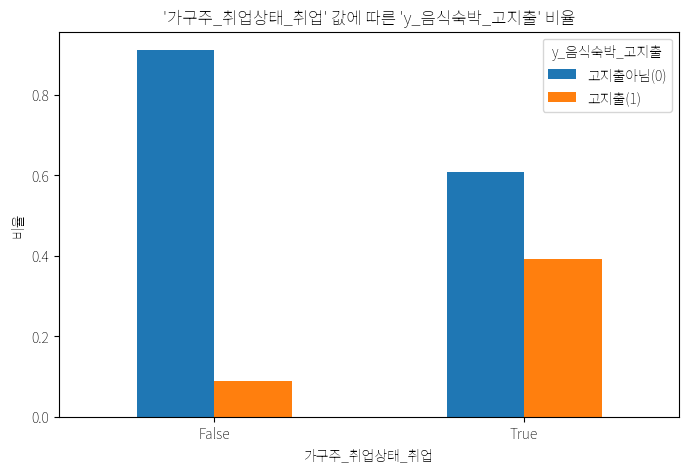


--- '거주구분_명칭_다세대주택' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출            0         1
거주구분_명칭_다세대주택                    
False          0.702354  0.297646
True           0.672566  0.327434


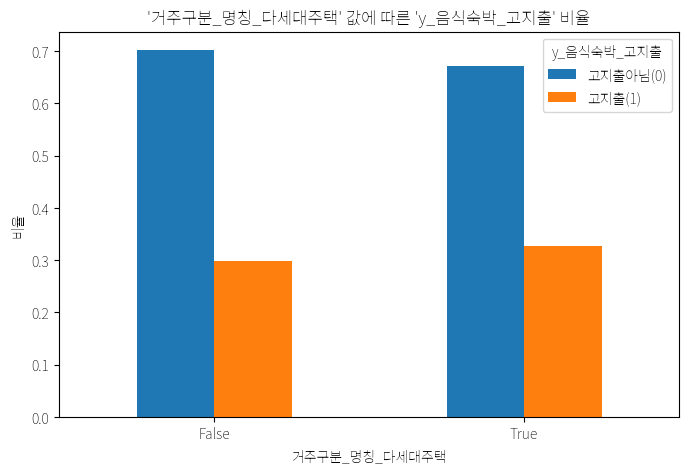


--- '거주구분_명칭_단독주택' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출           0         1
거주구분_명칭_단독주택                    
False         0.695359  0.304641
True          0.705589  0.294411


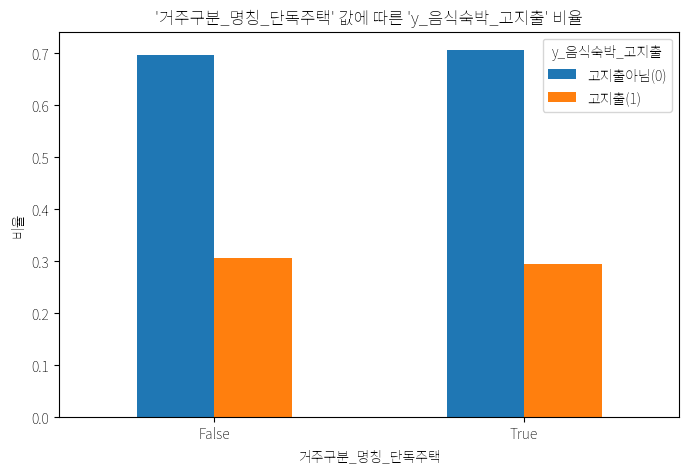


--- '거주구분_명칭_비거주용건물' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출             0         1
거주구분_명칭_비거주용건물                    
False           0.699103  0.300897
True            0.851852  0.148148


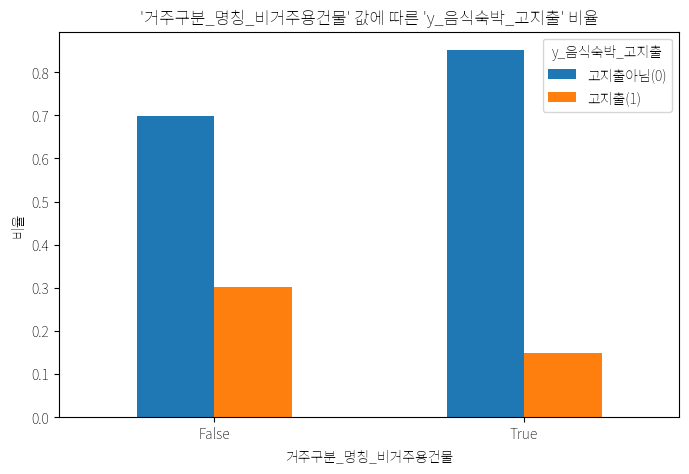


--- '거주구분_명칭_아파트' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출          0         1
거주구분_명칭_아파트                    
False        0.672714  0.327286
True         0.749200  0.250800


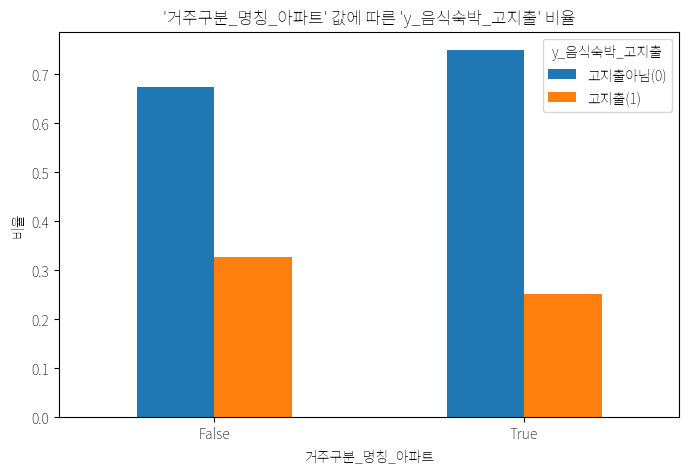


--- '거주구분_명칭_연립주택' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출           0         1
거주구분_명칭_연립주택                    
False         0.696072  0.303928
True          0.837398  0.162602


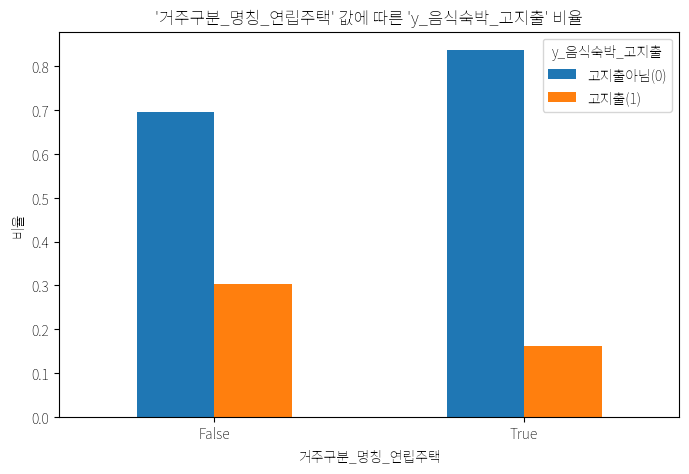


--- '거주구분_명칭_오피스텔' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출           0         1
거주구분_명칭_오피스텔                    
False         0.724606  0.275394
True          0.386792  0.613208


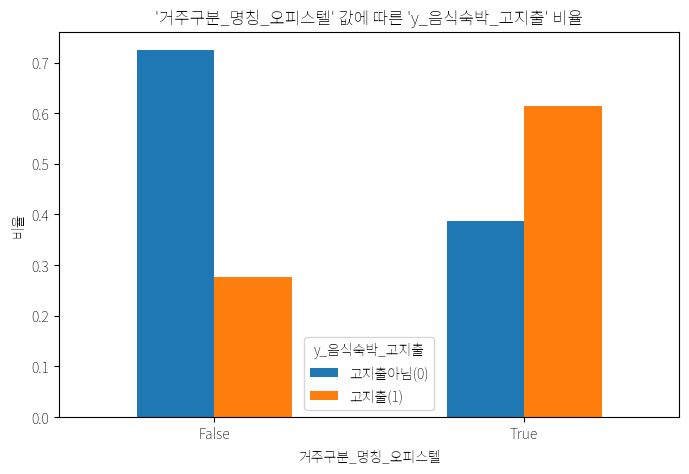


--- '산업_대분류_공공/교육/보건' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출              0         1
산업_대분류_공공/교육/보건                    
False            0.700803  0.299197
True             0.697072  0.302928


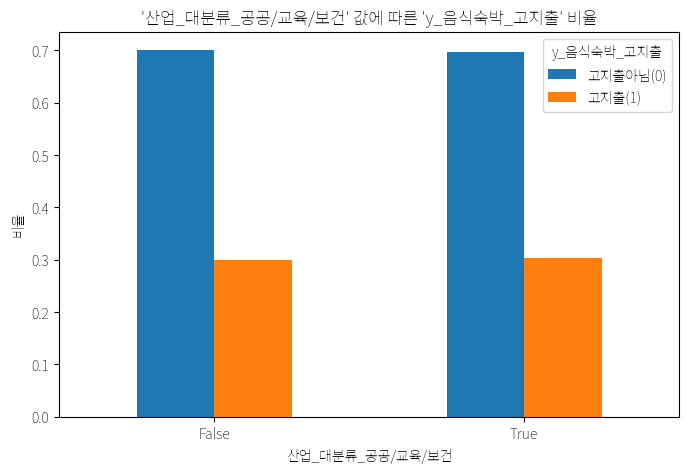


--- '산업_대분류_기타' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출         0         1
산업_대분류_기타                     
False       0.602537  0.397463
True        0.880208  0.119792


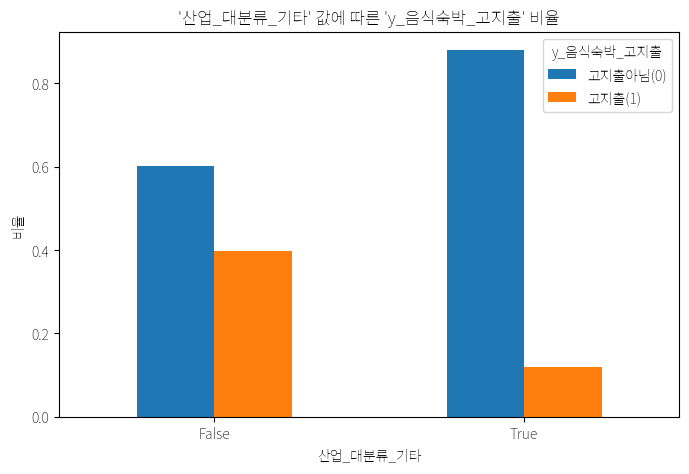


--- '산업_대분류_서비스업' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출          0         1
산업_대분류_서비스업                    
False        0.750078  0.249922
True         0.566022  0.433978


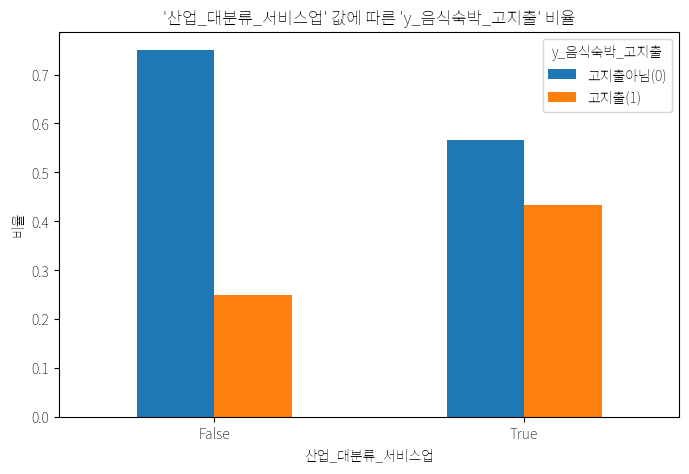


--- '산업_대분류_제조건설업' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출           0         1
산업_대분류_제조건설업                    
False         0.739947  0.260053
True          0.446128  0.553872


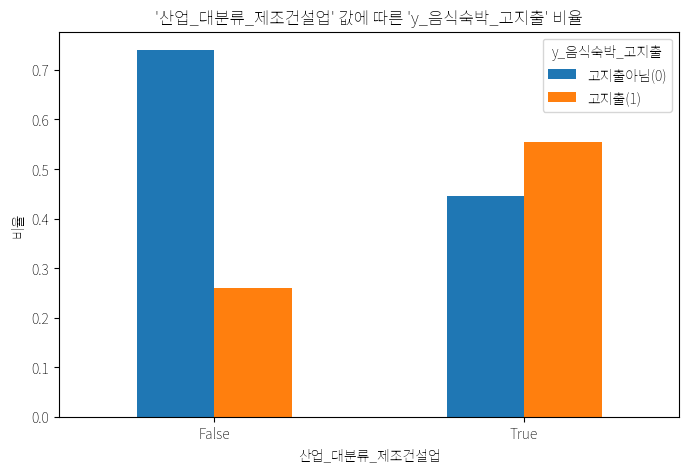


--- '입주형태_명칭_보증금_없는_월세' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출                0         1
입주형태_명칭_보증금_없는_월세                    
False              0.698637  0.301363
True               0.750000  0.250000


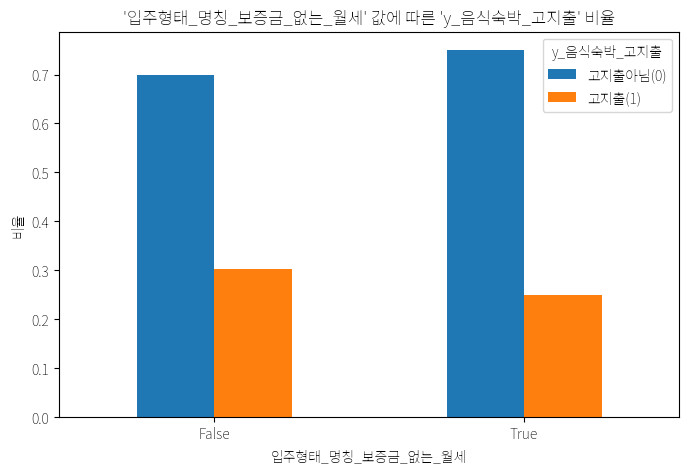


--- '입주형태_명칭_보증부_월세' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출             0         1
입주형태_명칭_보증부_월세                    
False           0.760939  0.239061
True            0.590531  0.409469


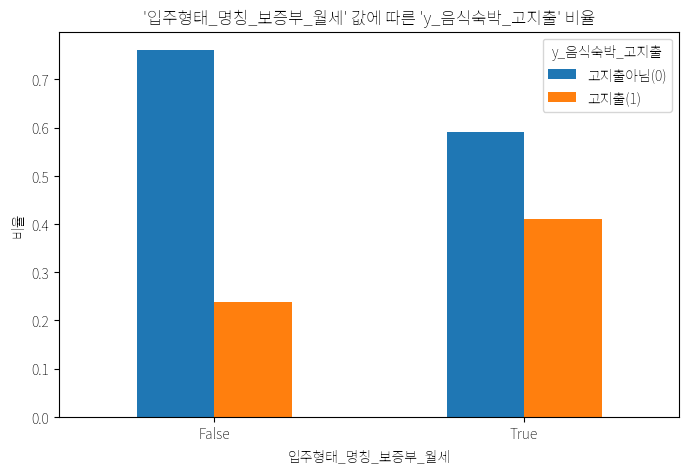


--- '입주형태_명칭_사택' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출         0         1
입주형태_명칭_사택                    
False       0.704698  0.295302
True        0.320755  0.679245


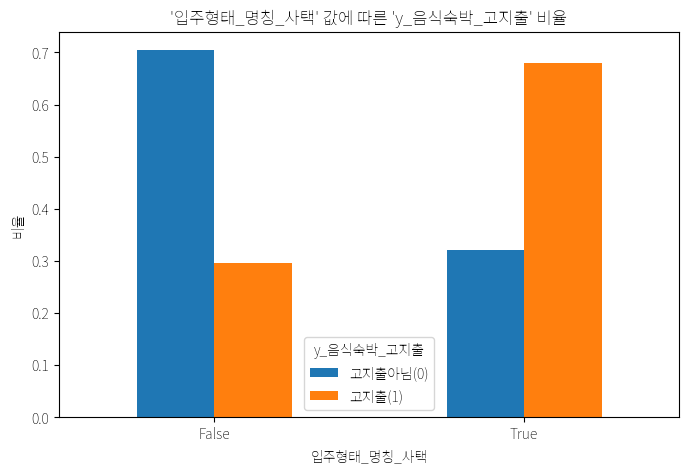


--- '입주형태_명칭_영구임대' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출           0         1
입주형태_명칭_영구임대                    
False         0.695621  0.304379
True          0.808140  0.191860


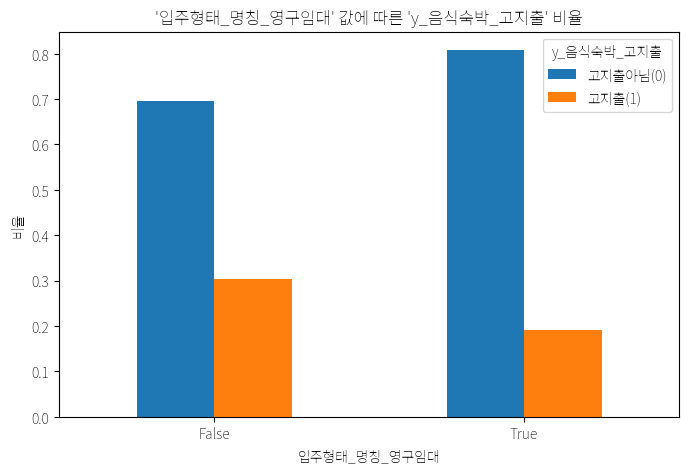


--- '입주형태_명칭_자가' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출         0         1
입주형태_명칭_자가                    
False       0.613620  0.386380
True        0.852273  0.147727


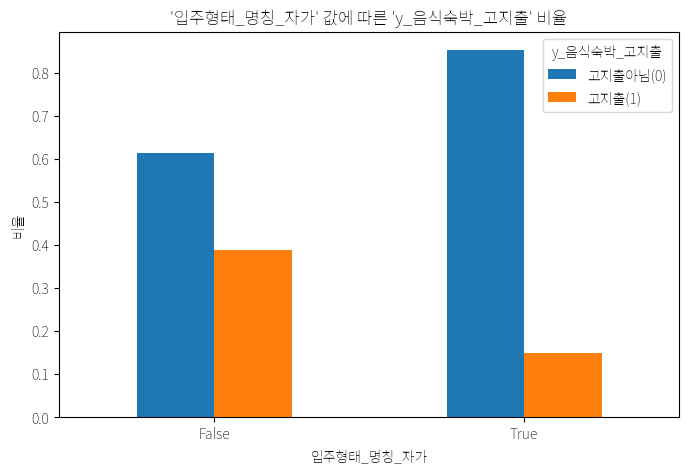


--- '입주형태_명칭_전세' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출         0         1
입주형태_명칭_전세                    
False       0.724879  0.275121
True        0.558282  0.441718


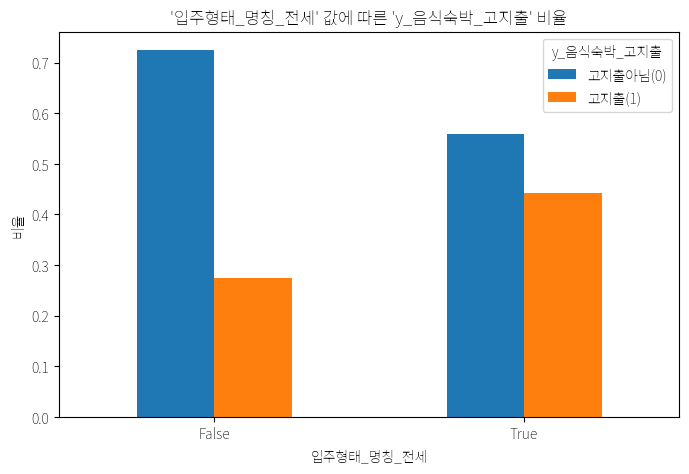


--- '전국전체가구_1인이상소득10분위코드' 값에 따른 'y_음식숙박_고지출' 비율 ---
y_음식숙박_고지출                  0         1
전국전체가구_1인이상소득10분위코드                    
1.0                  0.922442  0.077558
2.0                  0.831475  0.168525
3.0                  0.740955  0.259045
4.0                  0.579048  0.420952
5.0                  0.477723  0.522277
6.0                  0.418006  0.581994
7.0                  0.328042  0.671958
8.0                  0.336449  0.663551
9.0                  0.305556  0.694444
10.0                 0.250000  0.750000


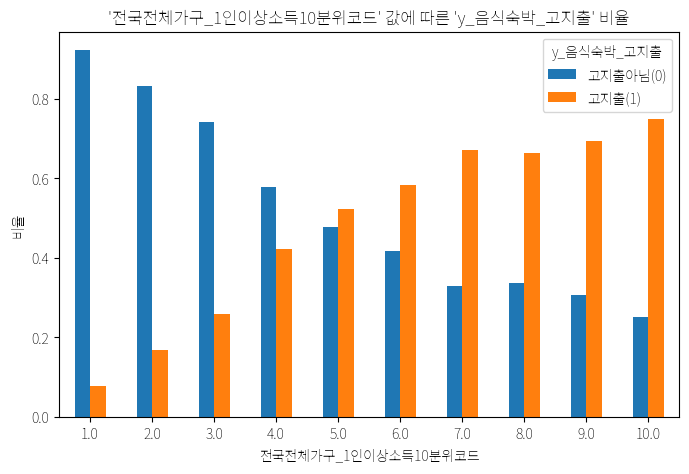

In [26]:
features_to_plot.remove("가구주_연령")
for feature_name in features_to_plot:
    if feature_name in df_single.columns and y_target_csf_single in df_single.columns:
        cross_tab_prop = pd.crosstab(index=df_single[feature_name], 
                                     columns=df_single[y_target_csf_single], 
                                     normalize='index') # 행 기준 비율 계산
        print(f"\n--- '{feature_name}' 값에 따른 '{y_target_csf_single}' 비율 ---")
        print(cross_tab_prop)
    
        # 시각화 (막대그래프로 비율 보기)
        cross_tab_prop.plot(kind='bar', stacked=False, figsize=(8,5))
        plt.title(f"'{feature_name}' 값에 따른 '{y_target_csf_single}' 비율")
        plt.ylabel("비율")
        plt.xticks(rotation=0)
        plt.legend(title=y_target_csf_single, labels=['고지출아님(0)', '고지출(1)']) # 레이블 순서 확인 필요
        plt.show()

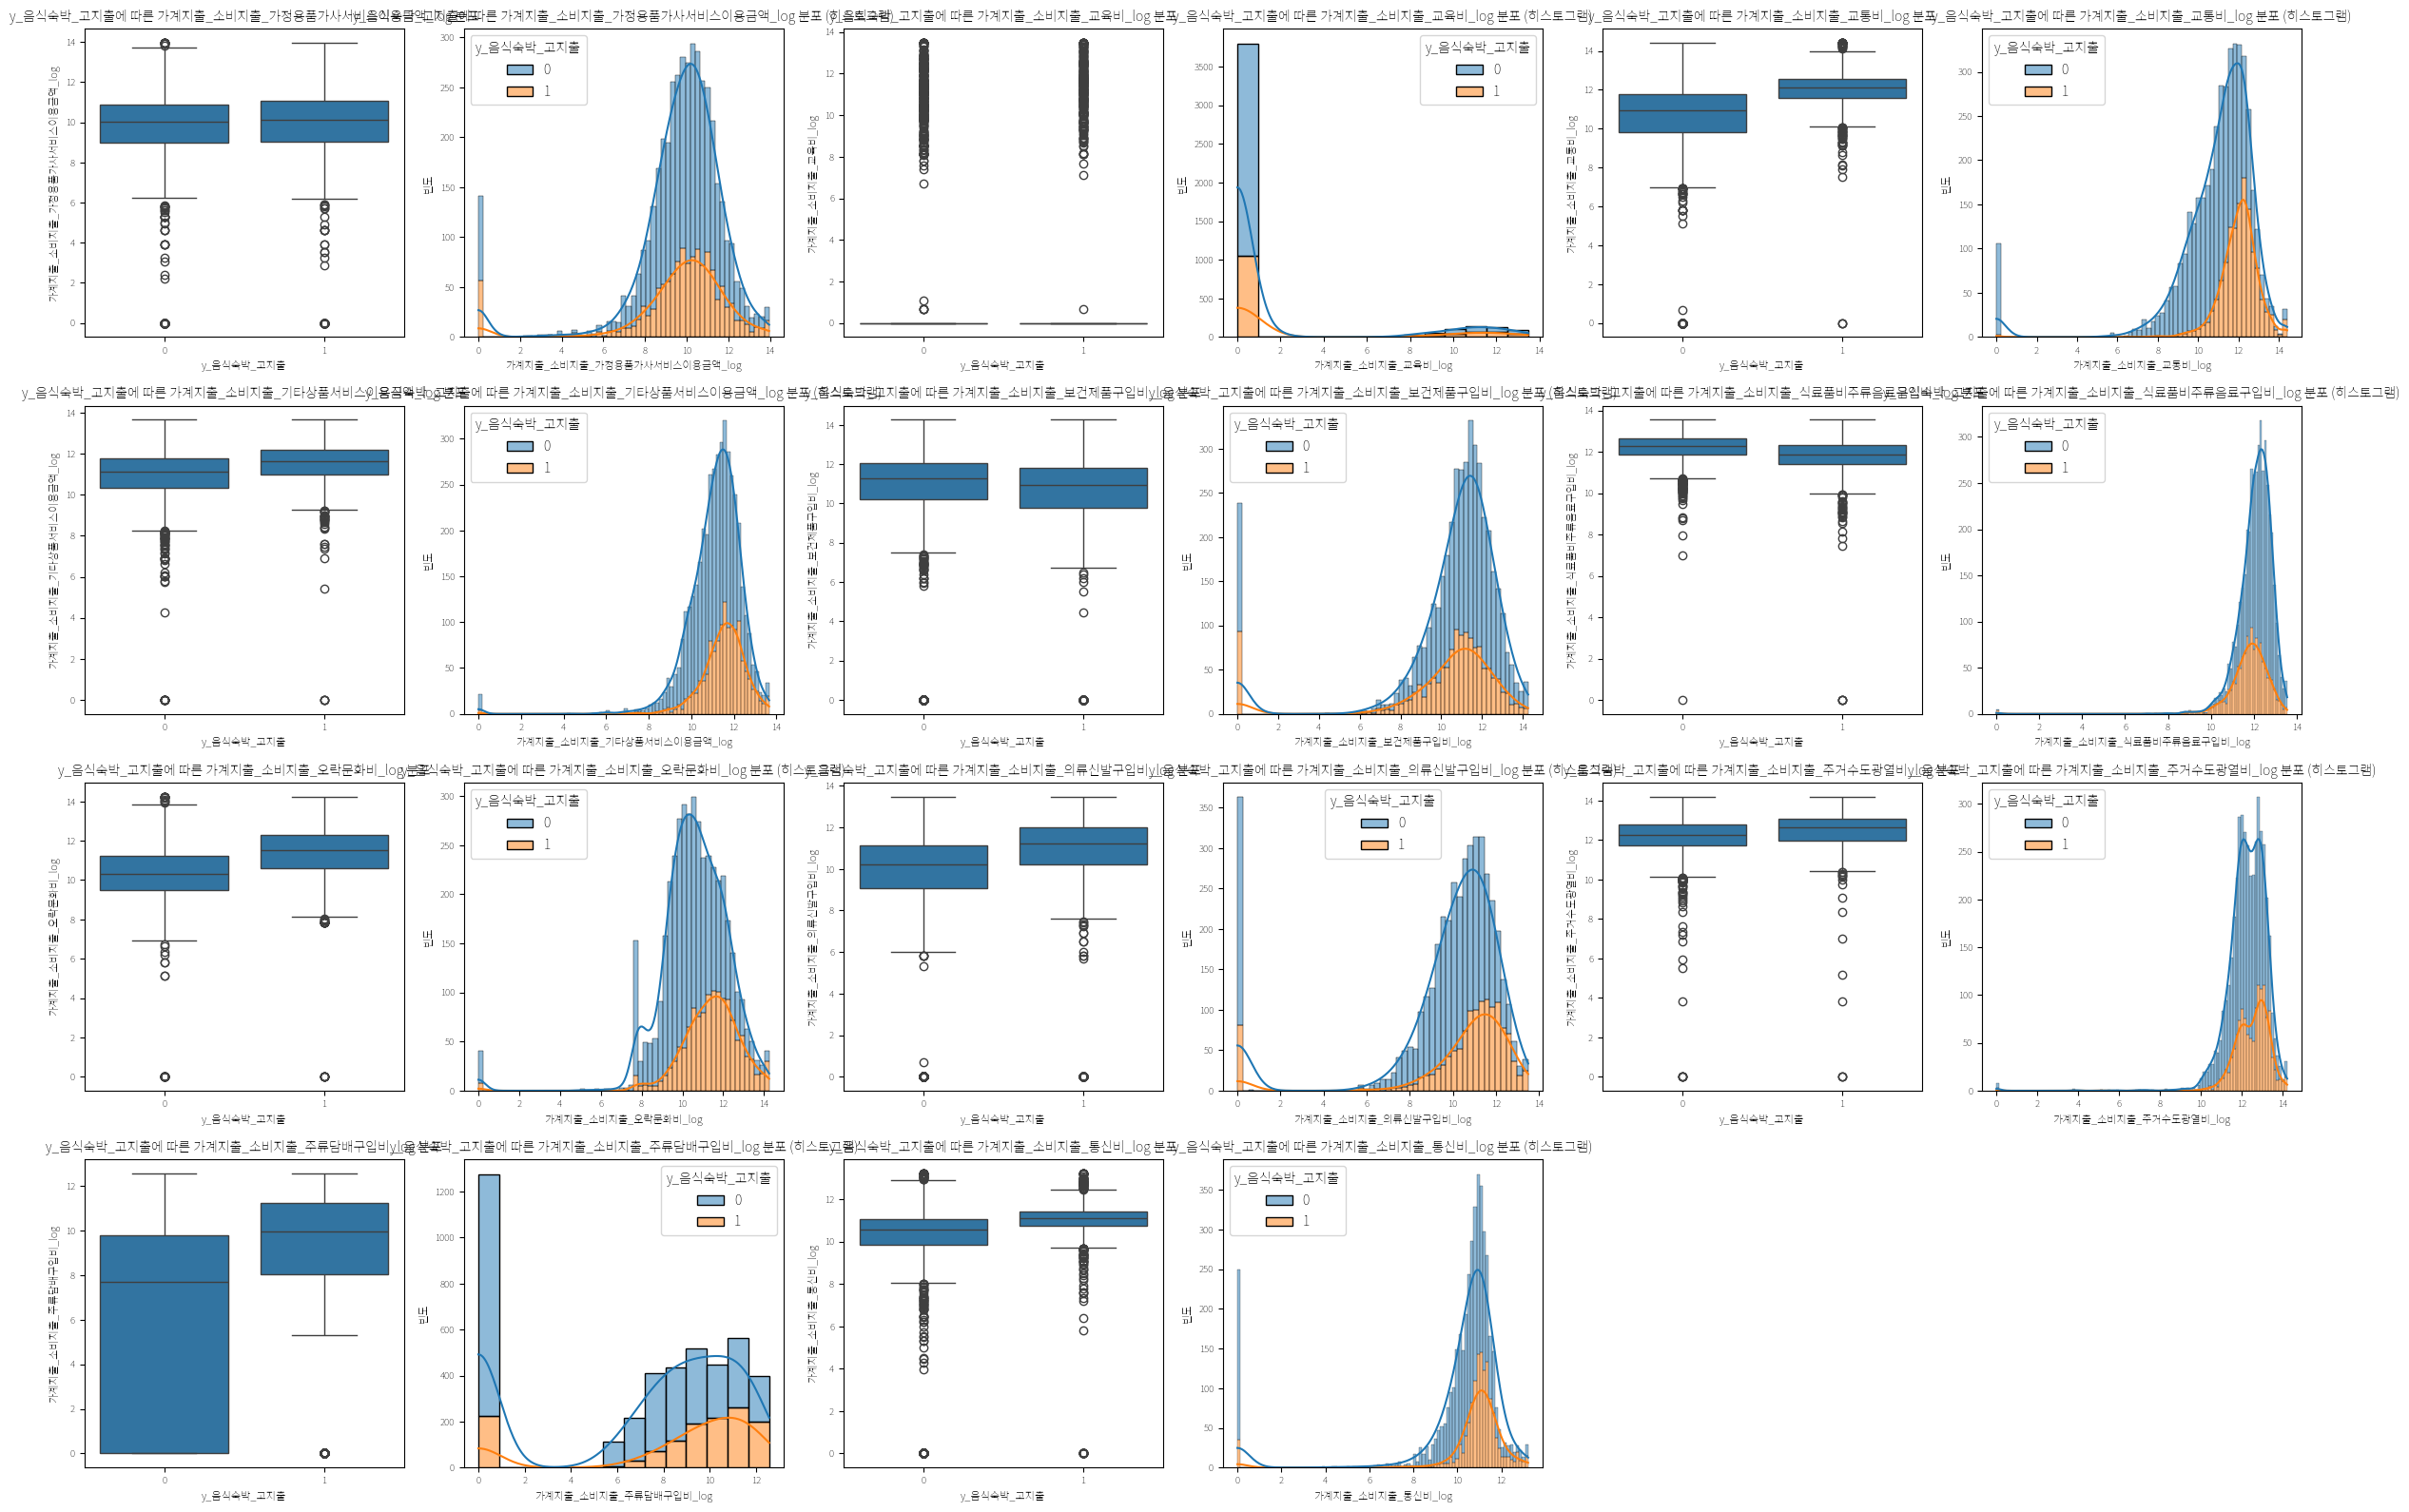

In [27]:
ratio_feature = []

for feature in item_columns:
    ratio_col = [col for col in df_single.columns if col.startswith(feature + '_log')]
    ratio_feature.extend(ratio_col)

ratio_feature = sorted(list(set(col for col in ratio_feature if col in df_single.columns)))
ratio_feature.remove('가계지출_소비지출_음식숙박비_log')

num_features = len(ratio_feature)
if num_features == 0:
    print("Warning: ratio_feature 리스트가 비어있습니다. 그래프를 생성할 수 없습니다.")
else:
    # 총 필요한 서브플롯 개수 (각 feature당 2개의 그래프)
    total_plots_needed = num_features * 2
    
    fig, axes = plt.subplots(4, 6, figsize=(24, 16)) 
    
    axes_flat = axes.flatten() 
    
    plot_idx = 0 # 현재 그리고 있는 서브플롯의 인덱스 (axes_flat 기준)

    for feature in ratio_feature:
        if feature in df_single.columns:
            # 박스플롯 그리기
            if plot_idx < len(axes_flat): # 서브플롯 공간이 남아있는 경우에만 그리기
                sns.boxplot(data=df_single, x=y_target_csf_single, y=feature, ax=axes_flat[plot_idx])
                axes_flat[plot_idx].set_title(f'{y_target_csf_single}에 따른 {feature} 분포', fontsize=10)
                axes_flat[plot_idx].set_xlabel(y_target_csf_single, fontsize=8)
                axes_flat[plot_idx].set_ylabel(feature, fontsize=8)
                axes_flat[plot_idx].tick_params(axis='x', labelsize=7)
                axes_flat[plot_idx].tick_params(axis='y', labelsize=7)
                plot_idx += 1
            else:
                print(f"Warning: '{feature}'의 박스플롯을 그릴 서브플롯 공간이 부족합니다.")
                break # 더 이상 그릴 공간이 없으면 루프 종료

            # 히스토그램 그리기
            if plot_idx < len(axes_flat): # 서브플롯 공간이 남아있는 경우에만 그리기
                sns.histplot(data=df_single, x=feature, hue=y_target_csf_single, kde=True, multiple="stack", ax=axes_flat[plot_idx])
                axes_flat[plot_idx].set_title(f'{y_target_csf_single}에 따른 {feature} 분포 (히스토그램)', fontsize=10)
                axes_flat[plot_idx].set_xlabel(feature, fontsize=8)
                axes_flat[plot_idx].set_ylabel('빈도', fontsize=8)
                axes_flat[plot_idx].tick_params(axis='x', labelsize=7)
                axes_flat[plot_idx].tick_params(axis='y', labelsize=7)
                plot_idx += 1
            else:
                print(f"Warning: '{feature}'의 히스토그램을 그릴 서브플롯 공간이 부족합니다.")
                break # 더 이상 그릴 공간이 없으면 루프 종료
        
        if plot_idx >= len(axes_flat): # 모든 서브플롯을 다 사용했으면 루프 종료
            break
            
    # 남는 서브플롯 비활성화 (축 숨기기)
    for i in range(plot_idx, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout() # 그래프들이 겹치지 않게 자동으로 레이아웃 조정
    plt.show()

In [28]:
# 노인가구 데이터만 필터링
df_senior = df[df['노인가구여부'] == 1].copy()

# 타겟으로 삼을 소비 항목 컬럼 선택
target_medical = '가계지출_소비지출_보건제품구입비_log'

if target_medical in df_senior.columns:
    # 1인 가구 내에서 해당 소비 비율의 상위 30% 기준점 찾기
    threshold = df_senior[target_medical].quantile(0.70)

    # 타겟 변수 생성: 기준점 이상이면 고지출(1), 아니면 0
    df_senior['y_보건제품구입_고지출'] = (df_senior[target_medical] >= threshold).astype(int)
    
    print(df_senior['y_보건제품구입_고지출'].value_counts(normalize=True))

y_보건제품구입_고지출
0    0.699792
1    0.300208
Name: proportion, dtype: float64


--- 최종 demographic_features 리스트 ---
['가구구분_명칭_비근로자가구', '가구주_연령', '가구주_취업상태_취업', '거주구분_명칭_다세대주택', '거주구분_명칭_단독주택', '거주구분_명칭_비거주용건물', '거주구분_명칭_아파트', '거주구분_명칭_연립주택', '거주구분_명칭_오피스텔', '산업_대분류_공공/교육/보건', '산업_대분류_기타', '산업_대분류_서비스업', '산업_대분류_제조건설업', '입주형태_명칭_보증금_없는_월세', '입주형태_명칭_보증부_월세', '입주형태_명칭_사택', '입주형태_명칭_영구임대', '입주형태_명칭_자가', '입주형태_명칭_전세', '전국전체가구_1인이상소득10분위코드']


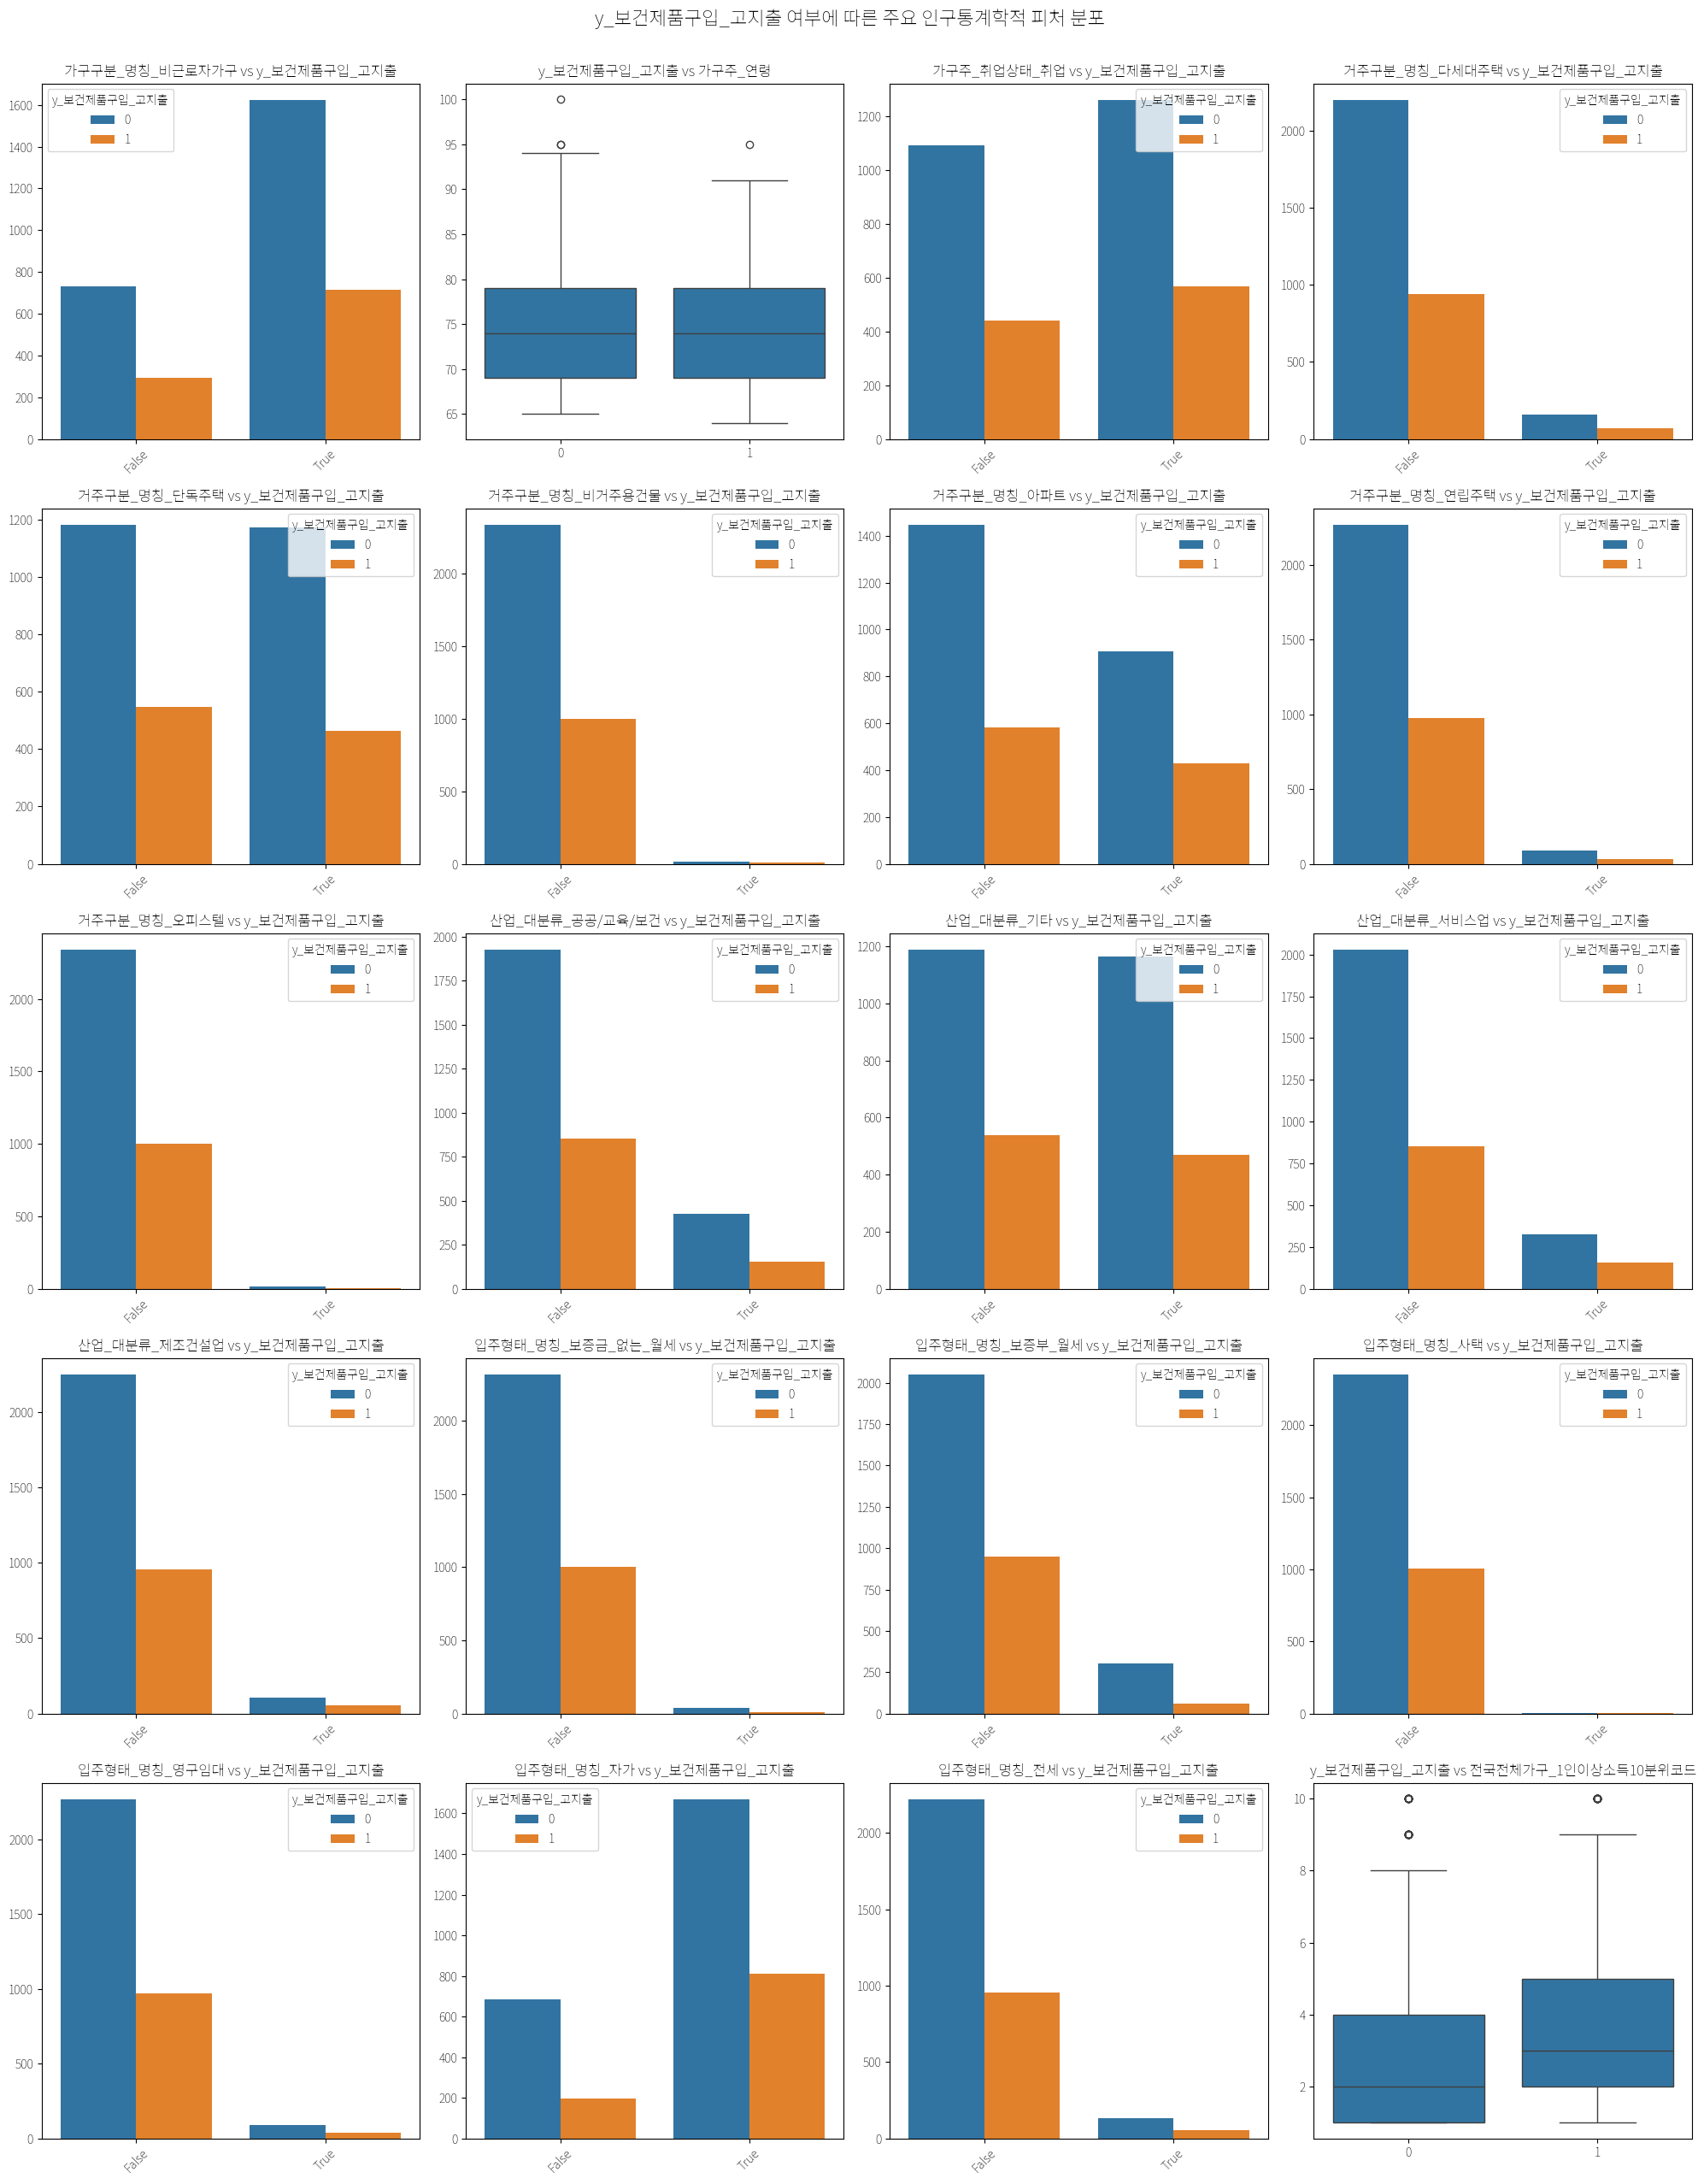

In [29]:
# 타겟 변수가 df_single에 제대로 생성되었는지 확인 후 진행
if 'y_보건제품구입_고지출' in df_senior.columns:
    y_target_csf_senior = 'y_보건제품구입_고지출'

    # A. 인구통계학적 feature vs target
    demographic_features = [
        '가구주_연령', '전국전체가구_1인이상소득10분위코드'
    ]

    original_named = [
    '가구구분_명칭',
    '가구주_취업상태', 
    '거주구분_명칭',   
    '입주형태_명칭',
    '산업_대분류'
    ]

    for original_col in original_named:
        ohe_cols = [col for col in df_senior.columns if col.startswith(original_col + '_')]
        demographic_features.extend(ohe_cols)

    demographic_features = sorted(list(set(col for col in demographic_features if col in df_senior.columns)))

    print("--- 최종 demographic_features 리스트 ---")
    print(demographic_features) # 리스트 내용 전체 확인
    
    # y_target_csf 변수 확인
if 'y_보건제품구입_고지출' in df_senior.columns:
    y_target_csf_senior = 'y_보건제품구입_고지출'
else:
    print(f"경고: 타겟 변수 '{y_target_csf_senior}'가 df_single에 없습니다. EDA를 진행할 수 없습니다.")
    # 여기서 중단하거나 기본값 설정 등의 처리가 필요할 수 있음.
    # 여기서는 일단 y_target_csf가 있다고 가정하고 진행.
    # 만약 이전에 다른 이름으로 타겟 변수를 만드셨다면 그 이름을 사용해야함.

# 그래프를 그릴 피처들만 필터링 (df_single에 실제로 존재하는 컬럼들)
features_to_plot = [f for f in demographic_features if f in df_senior.columns]

if not features_to_plot:
    print("알림: 그래프를 그릴 피처가 df_single에 없습니다.")
else:
    # 5x4 subplot 설정 (총 20개 그래프)
    num_features = len(features_to_plot)
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols # 피처 개수에 맞춰 행 수 자동 계산

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 5)) # figsize는 전체 그림 크기
    axes = axes.flatten() # 다차원 배열의 axes를 1차원으로 펴서 사용하기 쉽게 만듭니다.

    for i, feature in enumerate(features_to_plot):
        ax = axes[i] # 현재 그래프를 그릴 subplot 선택
        
        # feature가 문자열인지 먼저 확인
        if not isinstance(feature, str):
            ax.set_title(f"부적절한 피처: {feature}")
            ax.axis('off') # 부적절한 피처는 그래프 그리지 않음
            continue

        current_column_series = df_senior[feature]
        is_numeric = pd.api.types.is_numeric_dtype(current_column_series)
        nunique_count = current_column_series.nunique()
        
        if nunique_count > 5 and is_numeric:
            sns.boxplot(data=df_senior, x=y_target_csf_senior, y=feature, ax=ax)
            ax.set_title(f'{y_target_csf_senior} vs {feature}') # 축약된 제목
        else: # 범주형 또는 유니크값이 적은 숫자형
            sns.countplot(data=df_senior, x=feature, hue=y_target_csf_senior, ax=ax)
            ax.set_title(f'{feature} vs {y_target_csf_senior}') # 축약된 제목
            ax.tick_params(axis='x', rotation=45) # x축 레이블 회전 (필요시)
        
        ax.set_xlabel('') # 개별 x축 레이블은 생략하거나 간결하게
        ax.set_ylabel('') # 개별 y축 레이블은 생략하거나 간결하게

    for j in range(num_features, nrows * ncols):
        fig.delaxes(axes[j]) # 또는 axes[j].axis('off')

    plt.tight_layout() # 전체 레이아웃 조정
    plt.suptitle(f'{y_target_csf_senior} 여부에 따른 주요 인구통계학적 피처 분포', fontsize=16, y=1.02) # 전체 제목
    plt.show()



--- '가구구분_명칭_비근로자가구' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출           0         1
가구구분_명칭_비근로자가구                    
False           0.712891  0.287109
True            0.694052  0.305948


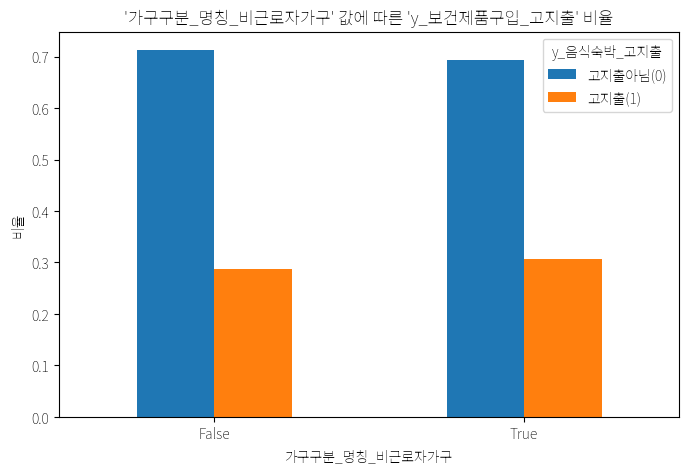


--- '가구주_취업상태_취업' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
가구주_취업상태_취업                     
False         0.712981  0.287019
True          0.688731  0.311269


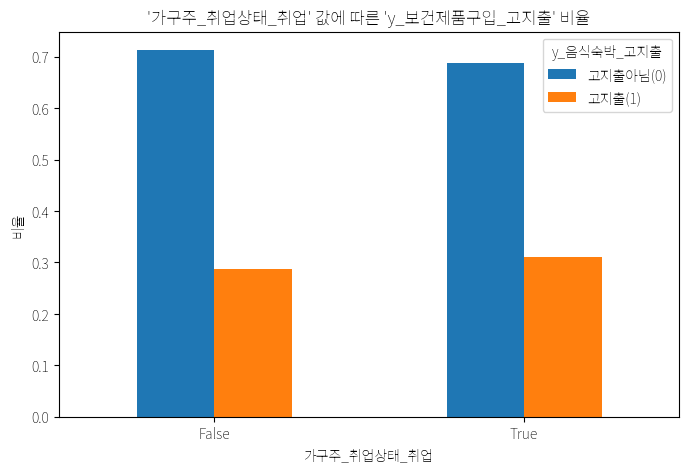


--- '거주구분_명칭_다세대주택' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출          0         1
거주구분_명칭_다세대주택                    
False          0.700383  0.299617
True           0.691630  0.308370


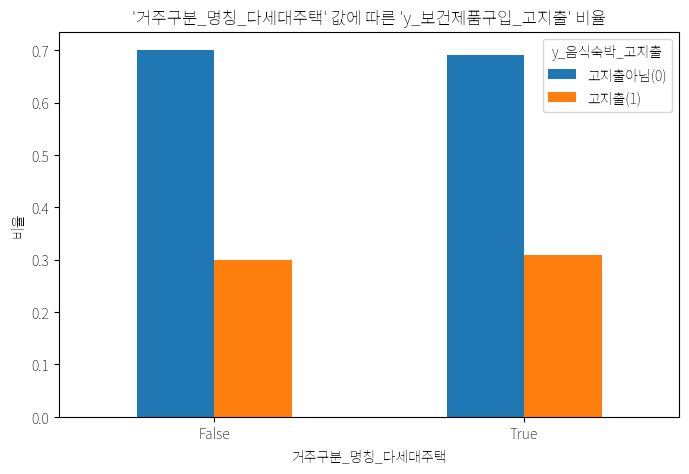


--- '거주구분_명칭_단독주택' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
거주구분_명칭_단독주택                    
False         0.683266  0.316734
True          0.717258  0.282742


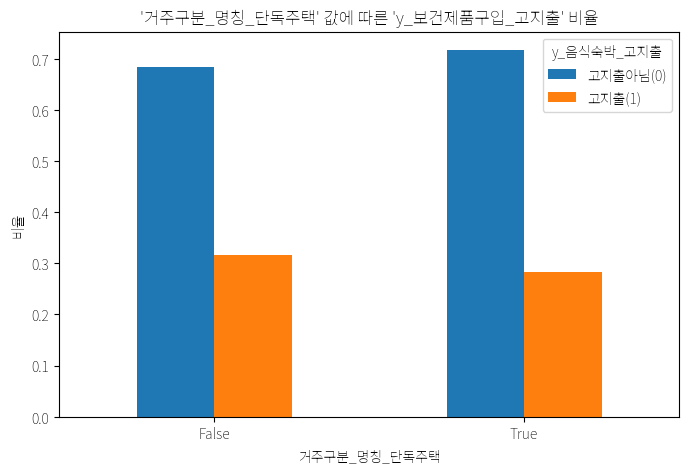


--- '거주구분_명칭_비거주용건물' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출          0        1
거주구분_명칭_비거주용건물                  
False           0.70054  0.29946
True            0.60000  0.40000


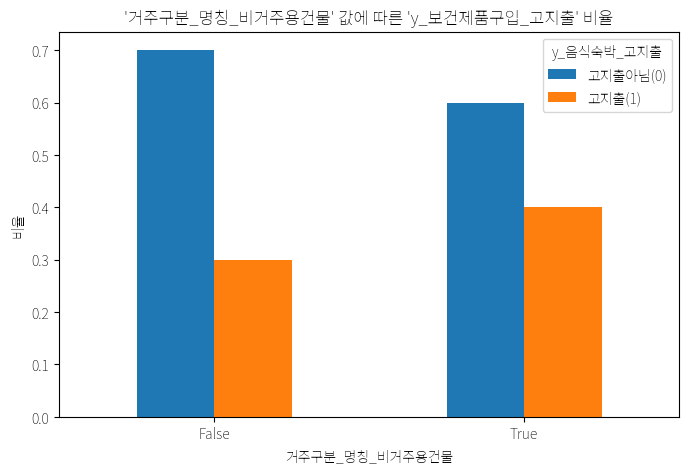


--- '거주구분_명칭_아파트' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
거주구분_명칭_아파트                     
False         0.713228  0.286772
True          0.679401  0.320599


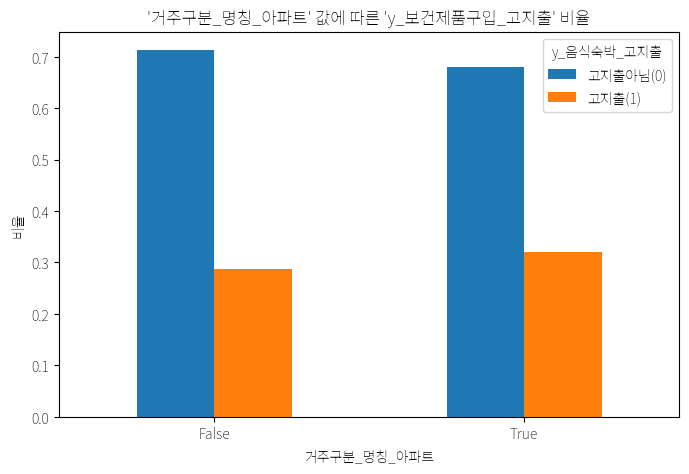


--- '거주구분_명칭_연립주택' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
거주구분_명칭_연립주택                    
False         0.698858  0.301142
True          0.725000  0.275000


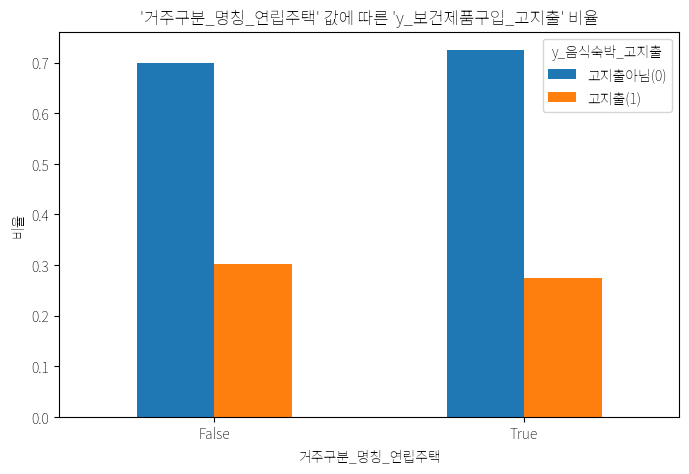


--- '거주구분_명칭_오피스텔' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
거주구분_명칭_오피스텔                    
False         0.699880  0.300120
True          0.684211  0.315789


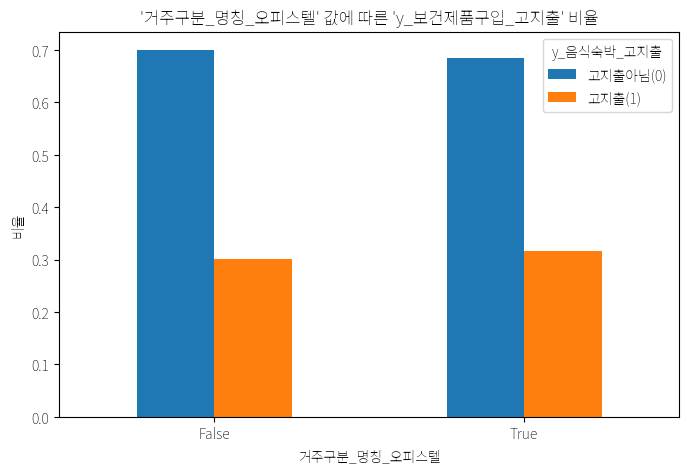


--- '산업_대분류_공공/교육/보건' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출            0         1
산업_대분류_공공/교육/보건                    
False            0.692695  0.307305
True             0.733677  0.266323


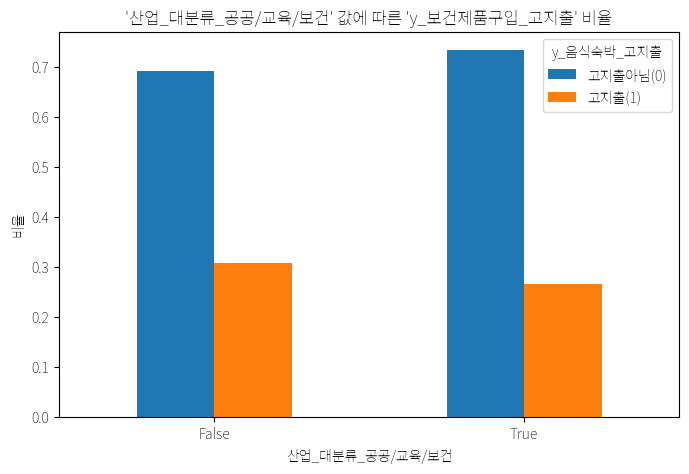


--- '산업_대분류_기타' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
산업_대분류_기타                       
False         0.687898  0.312102
True          0.712362  0.287638


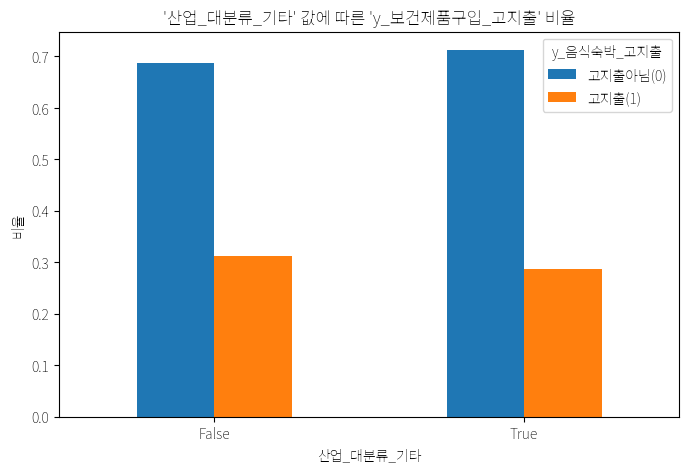


--- '산업_대분류_서비스업' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
산업_대분류_서비스업                     
False         0.703922  0.296078
True          0.675000  0.325000


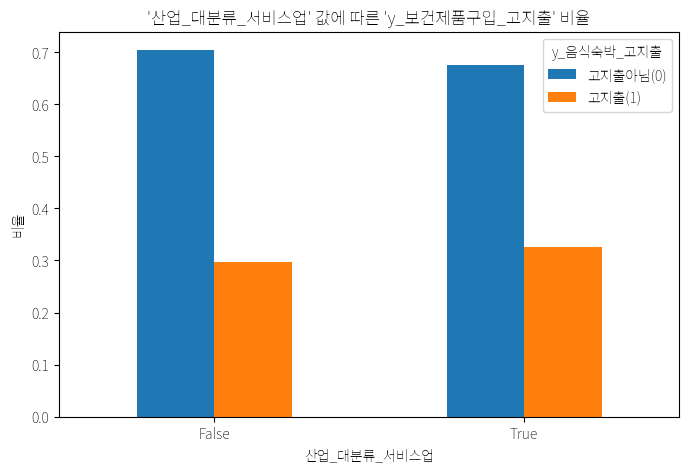


--- '산업_대분류_제조건설업' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
산업_대분류_제조건설업                    
False         0.702094  0.297906
True          0.654321  0.345679


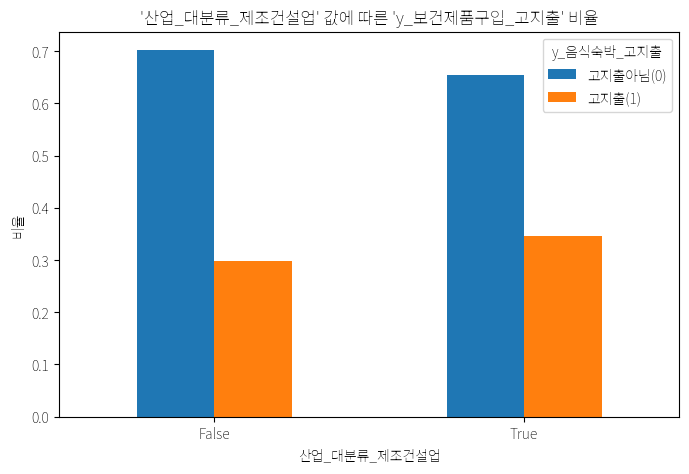


--- '입주형태_명칭_보증금_없는_월세' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출              0         1
입주형태_명칭_보증금_없는_월세                    
False              0.698159  0.301841
True               0.812500  0.187500


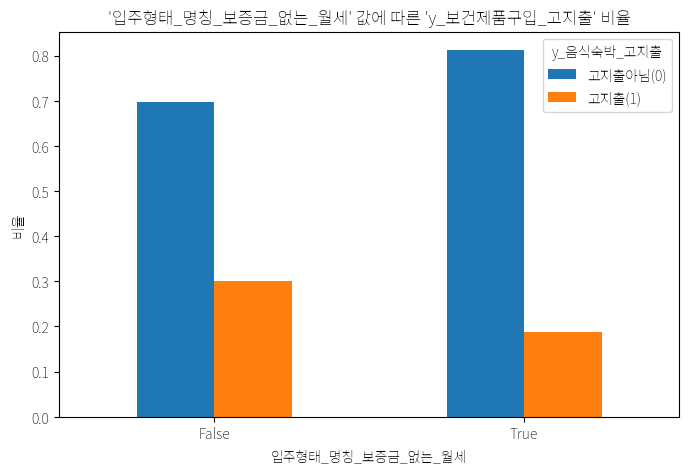


--- '입주형태_명칭_보증부_월세' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출           0         1
입주형태_명칭_보증부_월세                    
False           0.683912  0.316088
True            0.830137  0.169863


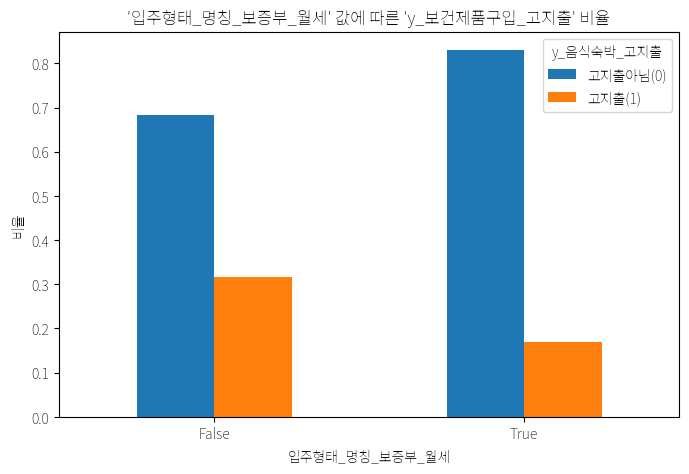


--- '입주형태_명칭_사택' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
입주형태_명칭_사택                      
False         0.699911  0.300089
True          0.500000  0.500000


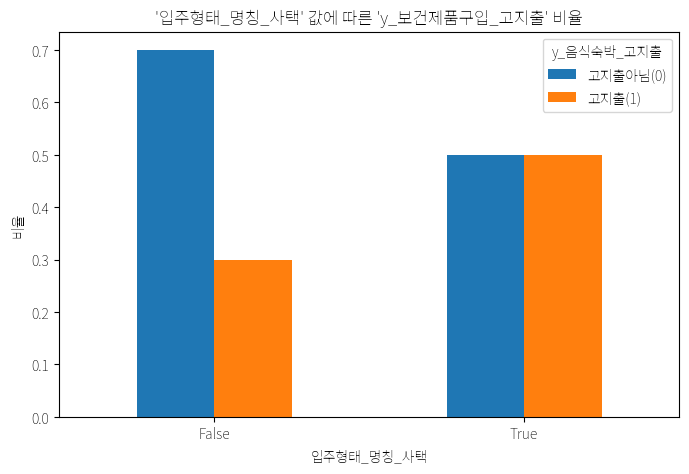


--- '입주형태_명칭_영구임대' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
입주형태_명칭_영구임대                    
False         0.700155  0.299845
True          0.690476  0.309524


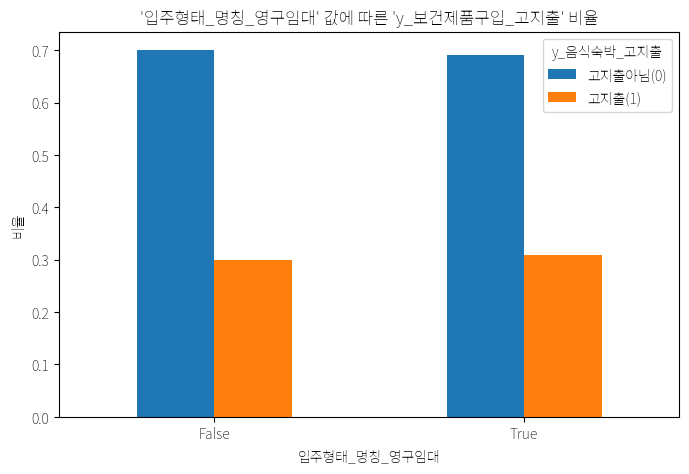


--- '입주형태_명칭_자가' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
입주형태_명칭_자가                      
False         0.776390  0.223610
True          0.672581  0.327419


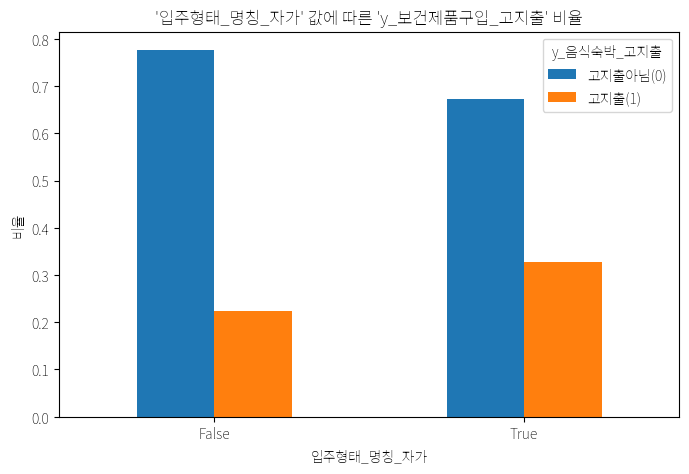


--- '입주형태_명칭_전세' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출         0         1
입주형태_명칭_전세                      
False         0.698458  0.301542
True          0.722826  0.277174


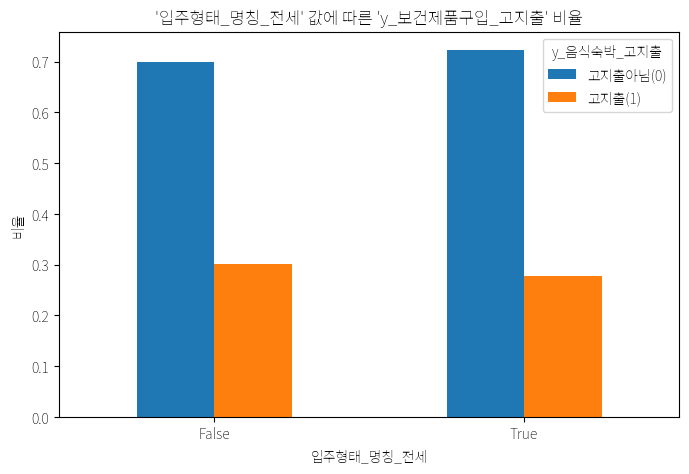


--- '전국전체가구_1인이상소득10분위코드' 값에 따른 'y_보건제품구입_고지출' 비율 ---
y_보건제품구입_고지출                0         1
전국전체가구_1인이상소득10분위코드                    
1.0                  0.829699  0.170301
2.0                  0.718750  0.281250
3.0                  0.643264  0.356736
4.0                  0.675362  0.324638
5.0                  0.603922  0.396078
6.0                  0.562500  0.437500
7.0                  0.500000  0.500000
8.0                  0.623377  0.376623
9.0                  0.370370  0.629630
10.0                 0.411765  0.588235


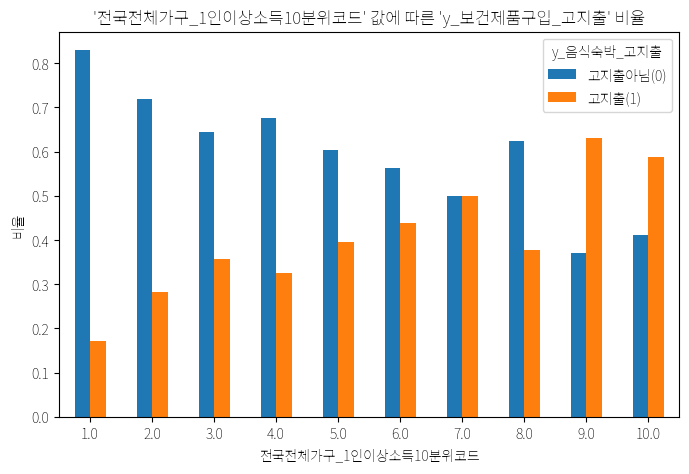

In [30]:
features_to_plot.remove("가구주_연령")
for feature_name in features_to_plot:
    if feature_name in df_senior.columns and y_target_csf_senior in df_senior.columns:
        cross_tab_prop = pd.crosstab(index=df_senior[feature_name], 
                                     columns=df_senior[y_target_csf_senior], 
                                     normalize='index') # 행 기준 비율 계산
        print(f"\n--- '{feature_name}' 값에 따른 '{y_target_csf_senior}' 비율 ---")
        print(cross_tab_prop)
    
        # 시각화 (막대그래프로 비율 보기)
        cross_tab_prop.plot(kind='bar', stacked=False, figsize=(8,5))
        plt.title(f"'{feature_name}' 값에 따른 '{y_target_csf_senior}' 비율")
        plt.ylabel("비율")
        plt.xticks(rotation=0)
        plt.legend(title=y_target_csf_single, labels=['고지출아님(0)', '고지출(1)']) # 레이블 순서 확인 필요
        plt.show()

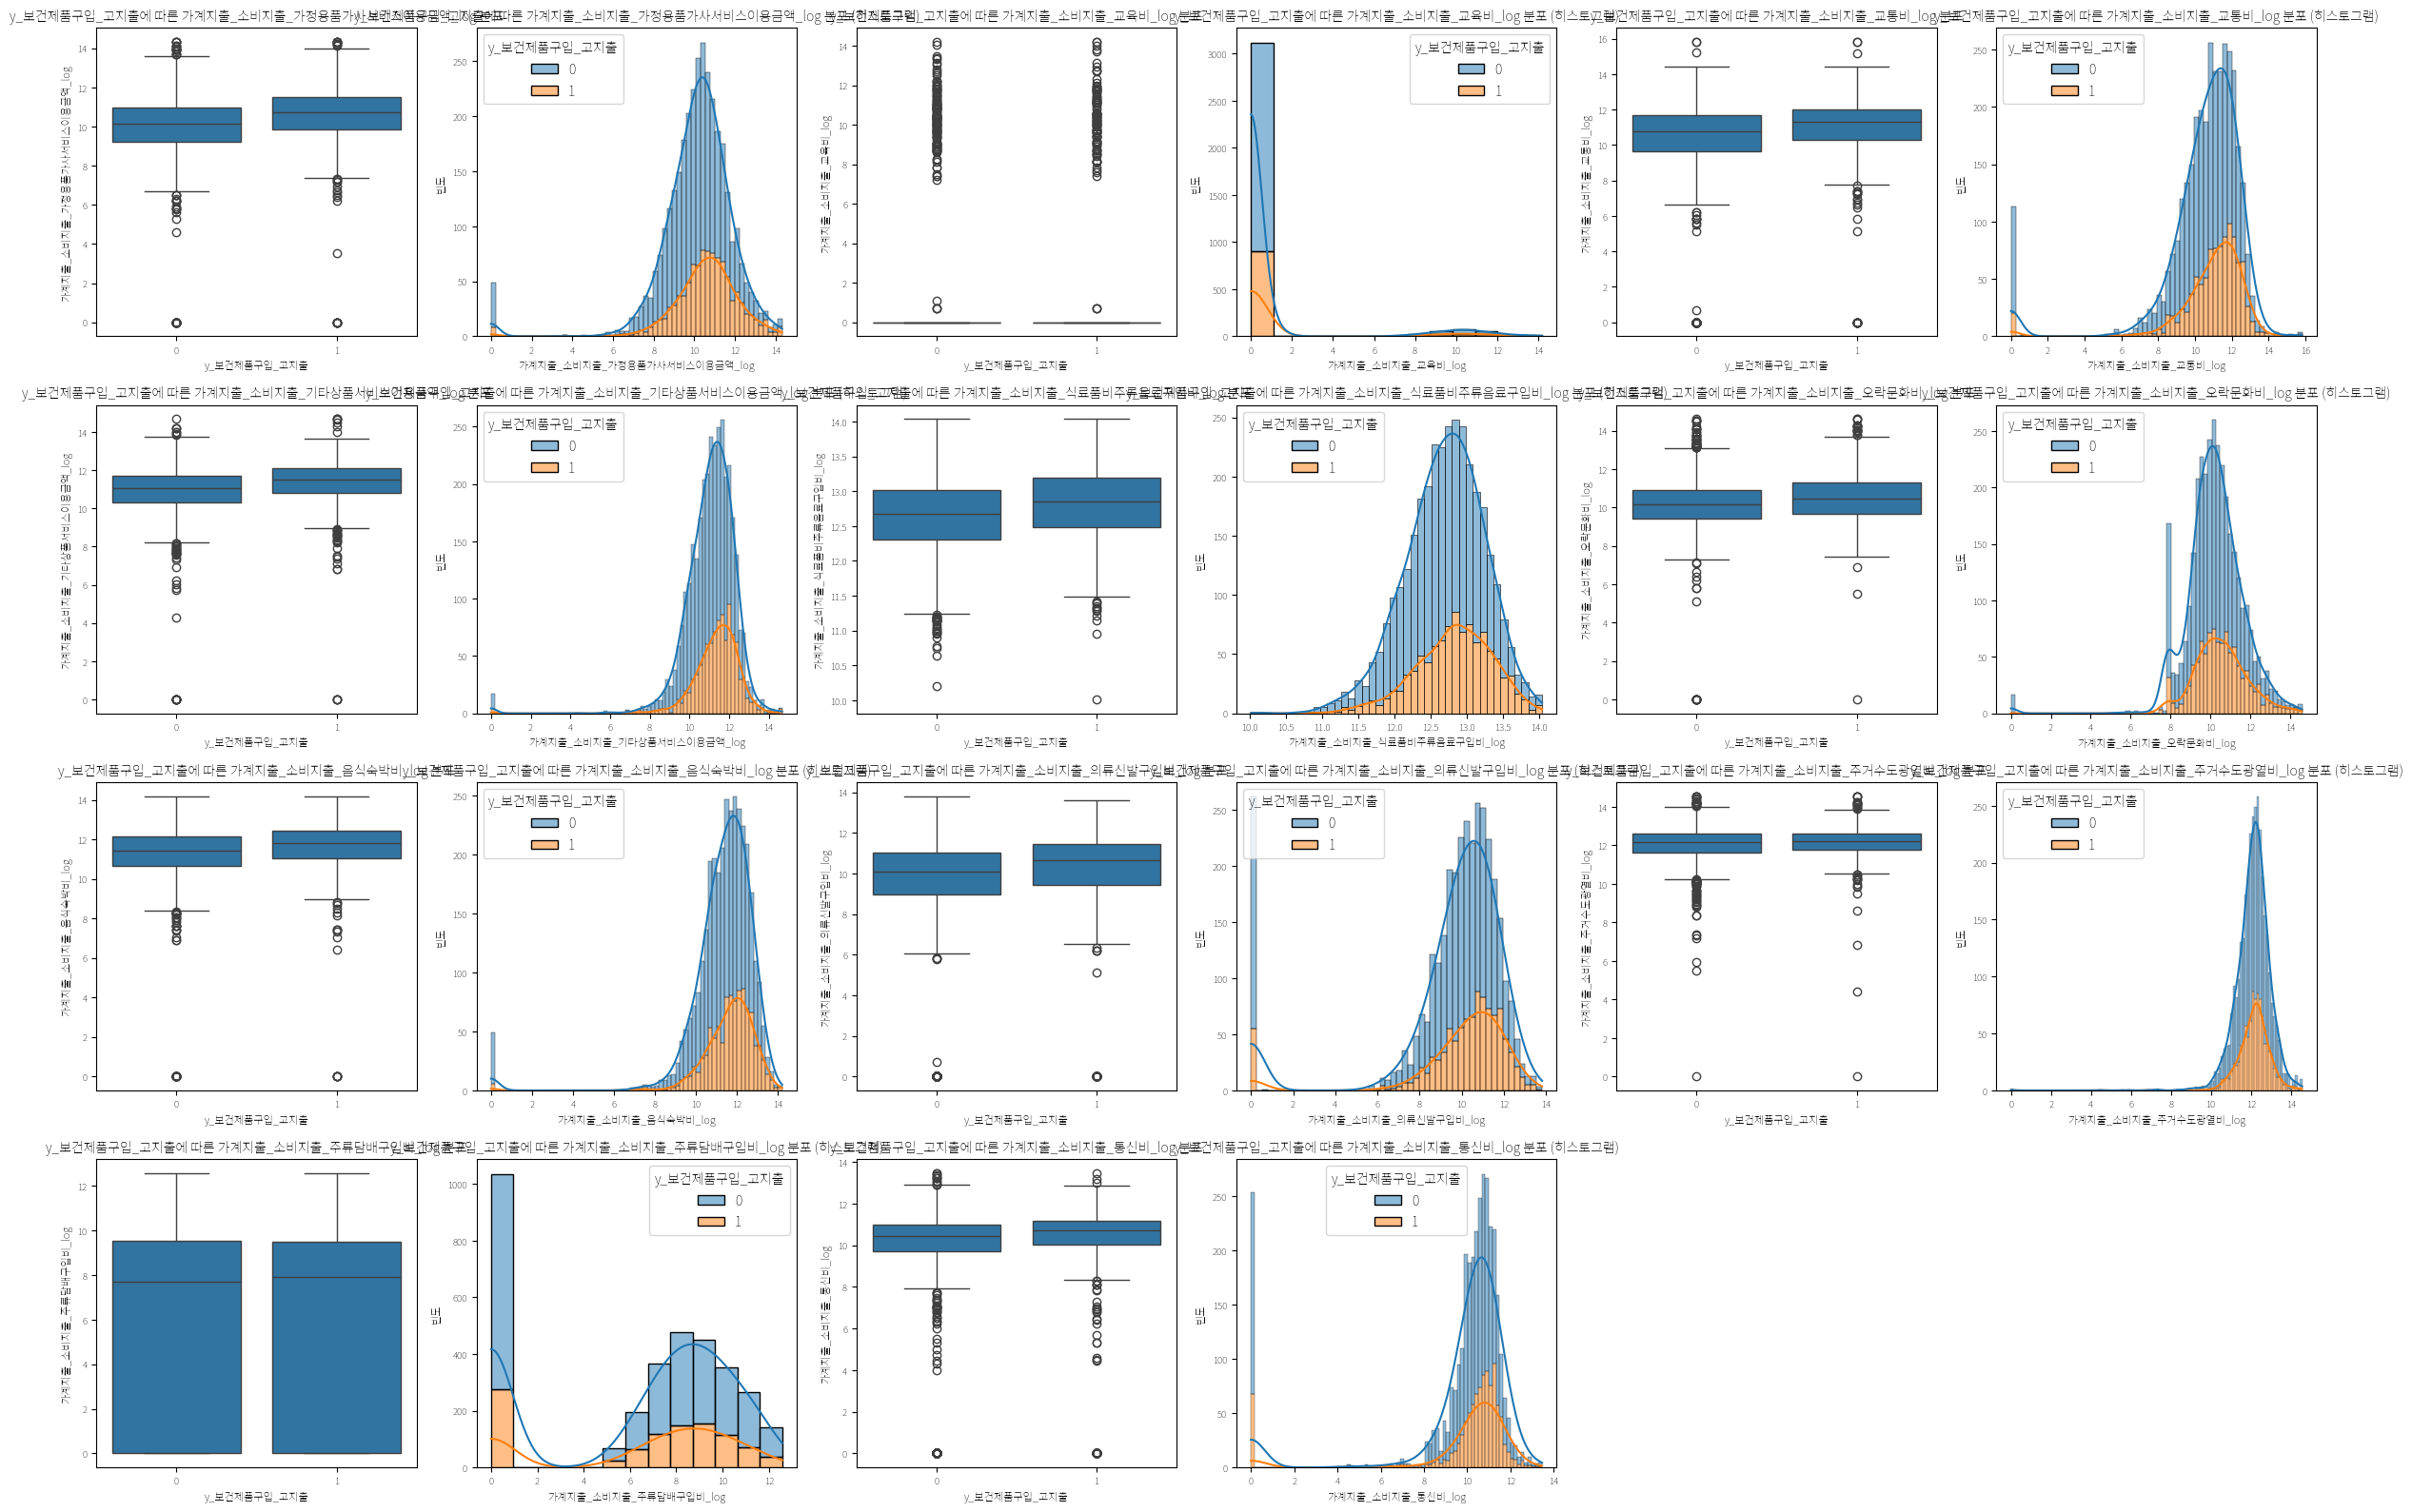

In [31]:
ratio_feature = []

for feature in item_columns:
    ratio_col = [col for col in df_senior.columns if col.startswith(feature + '_log')]
    ratio_feature.extend(ratio_col)

ratio_feature = sorted(list(set(col for col in ratio_feature if col in df_senior.columns)))
ratio_feature.remove('가계지출_소비지출_보건제품구입비_log')

num_features = len(ratio_feature)
if num_features == 0:
    print("Warning: ratio_feature 리스트가 비어있습니다. 그래프를 생성할 수 없습니다.")
else:
    # 총 필요한 서브플롯 개수 (각 feature당 2개의 그래프)
    total_plots_needed = num_features * 2
    
    fig, axes = plt.subplots(4, 6, figsize=(24, 16)) 
    
    axes_flat = axes.flatten() 
    
    plot_idx = 0 # 현재 그리고 있는 서브플롯의 인덱스 (axes_flat 기준)

    for feature in ratio_feature:
        if feature in df_senior.columns:
            # 박스플롯 그리기
            if plot_idx < len(axes_flat): # 서브플롯 공간이 남아있는 경우에만 그리기
                sns.boxplot(data=df_senior, x=y_target_csf_senior, y=feature, ax=axes_flat[plot_idx])
                axes_flat[plot_idx].set_title(f'{y_target_csf_senior}에 따른 {feature} 분포', fontsize=10)
                axes_flat[plot_idx].set_xlabel(y_target_csf_senior, fontsize=8)
                axes_flat[plot_idx].set_ylabel(feature, fontsize=8)
                axes_flat[plot_idx].tick_params(axis='x', labelsize=7)
                axes_flat[plot_idx].tick_params(axis='y', labelsize=7)
                plot_idx += 1
            else:
                print(f"Warning: '{feature}'의 박스플롯을 그릴 서브플롯 공간이 부족합니다.")
                break # 더 이상 그릴 공간이 없으면 루프 종료

            # 히스토그램 그리기
            if plot_idx < len(axes_flat): # 서브플롯 공간이 남아있는 경우에만 그리기
                sns.histplot(data=df_senior, x=feature, hue=y_target_csf_senior, kde=True, multiple="stack", ax=axes_flat[plot_idx])
                axes_flat[plot_idx].set_title(f'{y_target_csf_senior}에 따른 {feature} 분포 (히스토그램)', fontsize=10)
                axes_flat[plot_idx].set_xlabel(feature, fontsize=8)
                axes_flat[plot_idx].set_ylabel('빈도', fontsize=8)
                axes_flat[plot_idx].tick_params(axis='x', labelsize=7)
                axes_flat[plot_idx].tick_params(axis='y', labelsize=7)
                plot_idx += 1
            else:
                print(f"Warning: '{feature}'의 히스토그램을 그릴 서브플롯 공간이 부족합니다.")
                break # 더 이상 그릴 공간이 없으면 루프 종료
        
        if plot_idx >= len(axes_flat): # 모든 서브플롯을 다 사용했으면 루프 종료
            break
            
    # 남는 서브플롯 비활성화 (축 숨기기)
    for i in range(plot_idx, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout() # 그래프들이 겹치지 않게 자동으로 레이아웃 조정
    plt.show()

- 지금까지의 EDA 종합
   - 인구통계학 feature:
      - count plot의 경우 클래스 간 비율 차이가 뚜렷한 feature를 선택
      - box plot의 경우 두 그룹간 박스의 위치가 뚜렷하게 다른 feature를 선택
   - 소비 지출 관련 feature:
      - box plot & histogram 둘 다 종합해서 box plot의 셩우 두 그룹간 박스의 위치가 뚜렷하게 다른 feature/histogram의 경우 두 그룹의 분포 중심 or 모양이 뚜렷하게 다른 feature를 선택

In [32]:
# EDA 과정을 통해 분석에 필요 없을 것 같은 feature들을 선별 후 drop

features_exclude = [
    '가구원수',
    '소득구간코드',
    '거주구분_명칭_다세대주택',
    '거주구분_명칭_단독주택',
    '산업_대분류_공공/교육/보건', 
    '입주형태_명칭_보증금_없는_월세',
    '소비지출_교육비_log',
    target_consumption
]

drop_to = item_columns + ['가계지출금액', '가구주_학력코드']

for feature in item_columns:
    drop_to_col = [col for col in df_single.columns if col.startswith(feature + '_비율')]
    drop_to.extend(drop_to_col)

cols_to_drop = [y_target_csf_single] + features_exclude + drop_to

final_col = [col for col in cols_to_drop if col in df_single.columns]

X_single = df_single.drop(columns = final_col)
y_single = df_single[y_target_csf_single]

# 데이터 분할
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, test_size = 0.3, random_state = 42, stratify = y_single)
print(f"X_train_single shape: {X_train_single.shape}, X_test_single shape: {X_test_single.shape}")

# Feature Scailing
# 원핫인코딩은 이미 마쳤기 때문에 숫자형 범주의 데이터에만 scaler 적용
numeric_col = X_train_single.select_dtypes(include = np.number).columns.tolist()
col_to_scale_single = [col for col in numeric_col if '_log' in col]

scaler = StandardScaler()
X_train_single_scaled = X_train_single.copy()
X_test_single_scaled = X_test_single.copy()

X_train_single_scaled[col_to_scale_single] = scaler.fit_transform(X_train_single[col_to_scale_single])
X_test_single_scaled[col_to_scale_single] = scaler.transform(X_test_single[col_to_scale_single])

X_train_single shape: (3061, 35), X_test_single shape: (1313, 35)


In [33]:
print(drop_to)

['가계지출_소비지출_식료품비주류음료구입비', '가계지출_소비지출_주류담배구입비', '가계지출_소비지출_의류신발구입비', '가계지출_소비지출_주거수도광열비', '가계지출_소비지출_가정용품가사서비스이용금액', '가계지출_소비지출_보건제품구입비', '가계지출_소비지출_교통비', '가계지출_소비지출_통신비', '가계지출_소비지출_오락문화비', '가계지출_소비지출_교육비', '가계지출_소비지출_음식숙박비', '가계지출_소비지출_기타상품서비스이용금액', '가계지출금액', '가구주_학력코드', '가계지출_소비지출_식료품비주류음료구입비_비율', '가계지출_소비지출_주류담배구입비_비율', '가계지출_소비지출_의류신발구입비_비율', '가계지출_소비지출_주거수도광열비_비율', '가계지출_소비지출_가정용품가사서비스이용금액_비율', '가계지출_소비지출_보건제품구입비_비율', '가계지출_소비지출_교통비_비율', '가계지출_소비지출_통신비_비율', '가계지출_소비지출_오락문화비_비율', '가계지출_소비지출_교육비_비율', '가계지출_소비지출_음식숙박비_비율', '가계지출_소비지출_기타상품서비스이용금액_비율']


In [34]:
X_train_single.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3061 entries, 9062 to 1912
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   취업인원수                        3061 non-null   float64
 1   노인가구여부                       3061 non-null   float64
 2   가구주_연령                       3061 non-null   float64
 3   전국전체가구_1인이상소득10분위코드          3061 non-null   float64
 4   가계지출_소비지출금액                  3061 non-null   float64
 5   도시읍면부구분코드                    3061 non-null   float64
 6   가계지출_소비지출_식료품비주류음료구입비_log    3061 non-null   float64
 7   가계지출_소비지출_주류담배구입비_log        3061 non-null   float64
 8   가계지출_소비지출_의류신발구입비_log        3061 non-null   float64
 9   가계지출_소비지출_주거수도광열비_log        3061 non-null   float64
 10  가계지출_소비지출_가정용품가사서비스이용금액_log  3061 non-null   float64
 11  가계지출_소비지출_보건제품구입비_log        3061 non-null   float64
 12  가계지출_소비지출_교통비_log            3061 non-null   float64
 13  가계지출_소비지출_통신비_log   

- feature가 여전히 많기 때문에 중복될 수 있는 가격 feature들 중 _log 만 제외하고 모두 제거하는 것으로 결정. 또한 가계지출금액과 가계지출_소비지출금액은 분석에 사용될 가능성이 있기 때문에 우리가 관심있는 소비지출금액만 남겨놓고 가계지출금액을 제거

## Modeling 진행

In [35]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [36]:
if X_train_single is not None:
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    # A. 로지스틱 회귀
    print("="*50)
    print("\nLogistic Regression\n")
    param_grid_lr = [
        {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']},
        {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs', 'saga']}
    ]
    # saga는 max_iter를 춘분히 늘려주는 것이 좋음
    grid_lr = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 1000), param_grid_lr, cv = kf, scoring = 'f1', n_jobs = -1)
    grid_lr.fit(X_train_single, y_train_single)
    best_lr = grid_lr.best_estimator_
    print(f"최적의 파라미터 (Logistic Regression): {grid_lr.best_params_}")
    print(f"교차 검증 F1 Score (Logistic Regression): {grid_lr.best_score_:.4f}")

    y_pred_lr = best_lr.predict(X_test_single)
    print("\n테스트 세트 평가 (Logistic Regression): ")
    print(confusion_matrix(y_test_single, y_pred_lr))
    print(classification_report(y_test_single, y_pred_lr))
    if hasattr(best_lr, "predict_proba"):
        y_pred_proba_lr = best_lr.predict_proba(X_test_single)[:, 1]
        print(f"ROC AUC: {roc_auc_score(y_test_single, y_pred_proba_lr):.4f}")



Logistic Regression

최적의 파라미터 (Logistic Regression): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
교차 검증 F1 Score (Logistic Regression): 0.7030

테스트 세트 평가 (Logistic Regression): 
[[821  98]
 [129 265]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       919
           1       0.73      0.67      0.70       394

    accuracy                           0.83      1313
   macro avg       0.80      0.78      0.79      1313
weighted avg       0.82      0.83      0.83      1313

ROC AUC: 0.8893


In [37]:
if X_train_single is not None:
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
# B. 의사결정 트리
    print("="*50)
    print("\nDecision Tree\n")
    param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
    }
    grid_dt = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid_dt, cv = kf, scoring = 'f1', n_jobs = -1)
    grid_dt.fit(X_train_single, y_train_single)
    best_dt = grid_dt.best_estimator_
    print(f"최적의 파라미터 (Decision Tree): {grid_dt.best_params_}")
    print(f"교차 검증 F1 Score (Decision Tree): {grid_dt.best_score_:.4f}")

    y_pred_dt = best_dt.predict(X_test_single)
    print("\n테스트 세트 평가 (Decision Tree): ")
    print(confusion_matrix(y_test_single, y_pred_dt))
    print(classification_report(y_test_single, y_pred_dt))
    y_pred_proba_dt = best_dt.predict_proba(X_test_single)[:, 1]
    print(f"ROC AUC: {roc_auc_score(y_test_single, y_pred_proba_dt):.4f}")

    importances_dt = pd.Series(best_dt.feature_importances_, index = X_train_single.columns)
    print("\nDecision Tree - Top 10 importance feature: ")
    print(importances_dt.nlargest(10))


Decision Tree

최적의 파라미터 (Decision Tree): {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}
교차 검증 F1 Score (Decision Tree): 0.6995

테스트 세트 평가 (Decision Tree): 
[[801 118]
 [130 264]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       919
           1       0.69      0.67      0.68       394

    accuracy                           0.81      1313
   macro avg       0.78      0.77      0.77      1313
weighted avg       0.81      0.81      0.81      1313

ROC AUC: 0.8668

Decision Tree - Top 10 importance feature: 
가계지출_소비지출금액                  0.513511
가구주_연령                       0.232370
가계지출_소비지출_식료품비주류음료구입비_log    0.044633
가계지출_소비지출_주거수도광열비_log        0.039605
전국전체가구_1인이상소득10분위코드          0.038941
가계지출_소비지출_보건제품구입비_log        0.030738
가계지출_소비지출_주류담배구입비_log        0.025769
입주형태_명칭_자가                   0.016965
가계지출_소비지출_교통비_log            0.015839
가계지출_소비지출_통신비_log            0.012914
dtype: floa

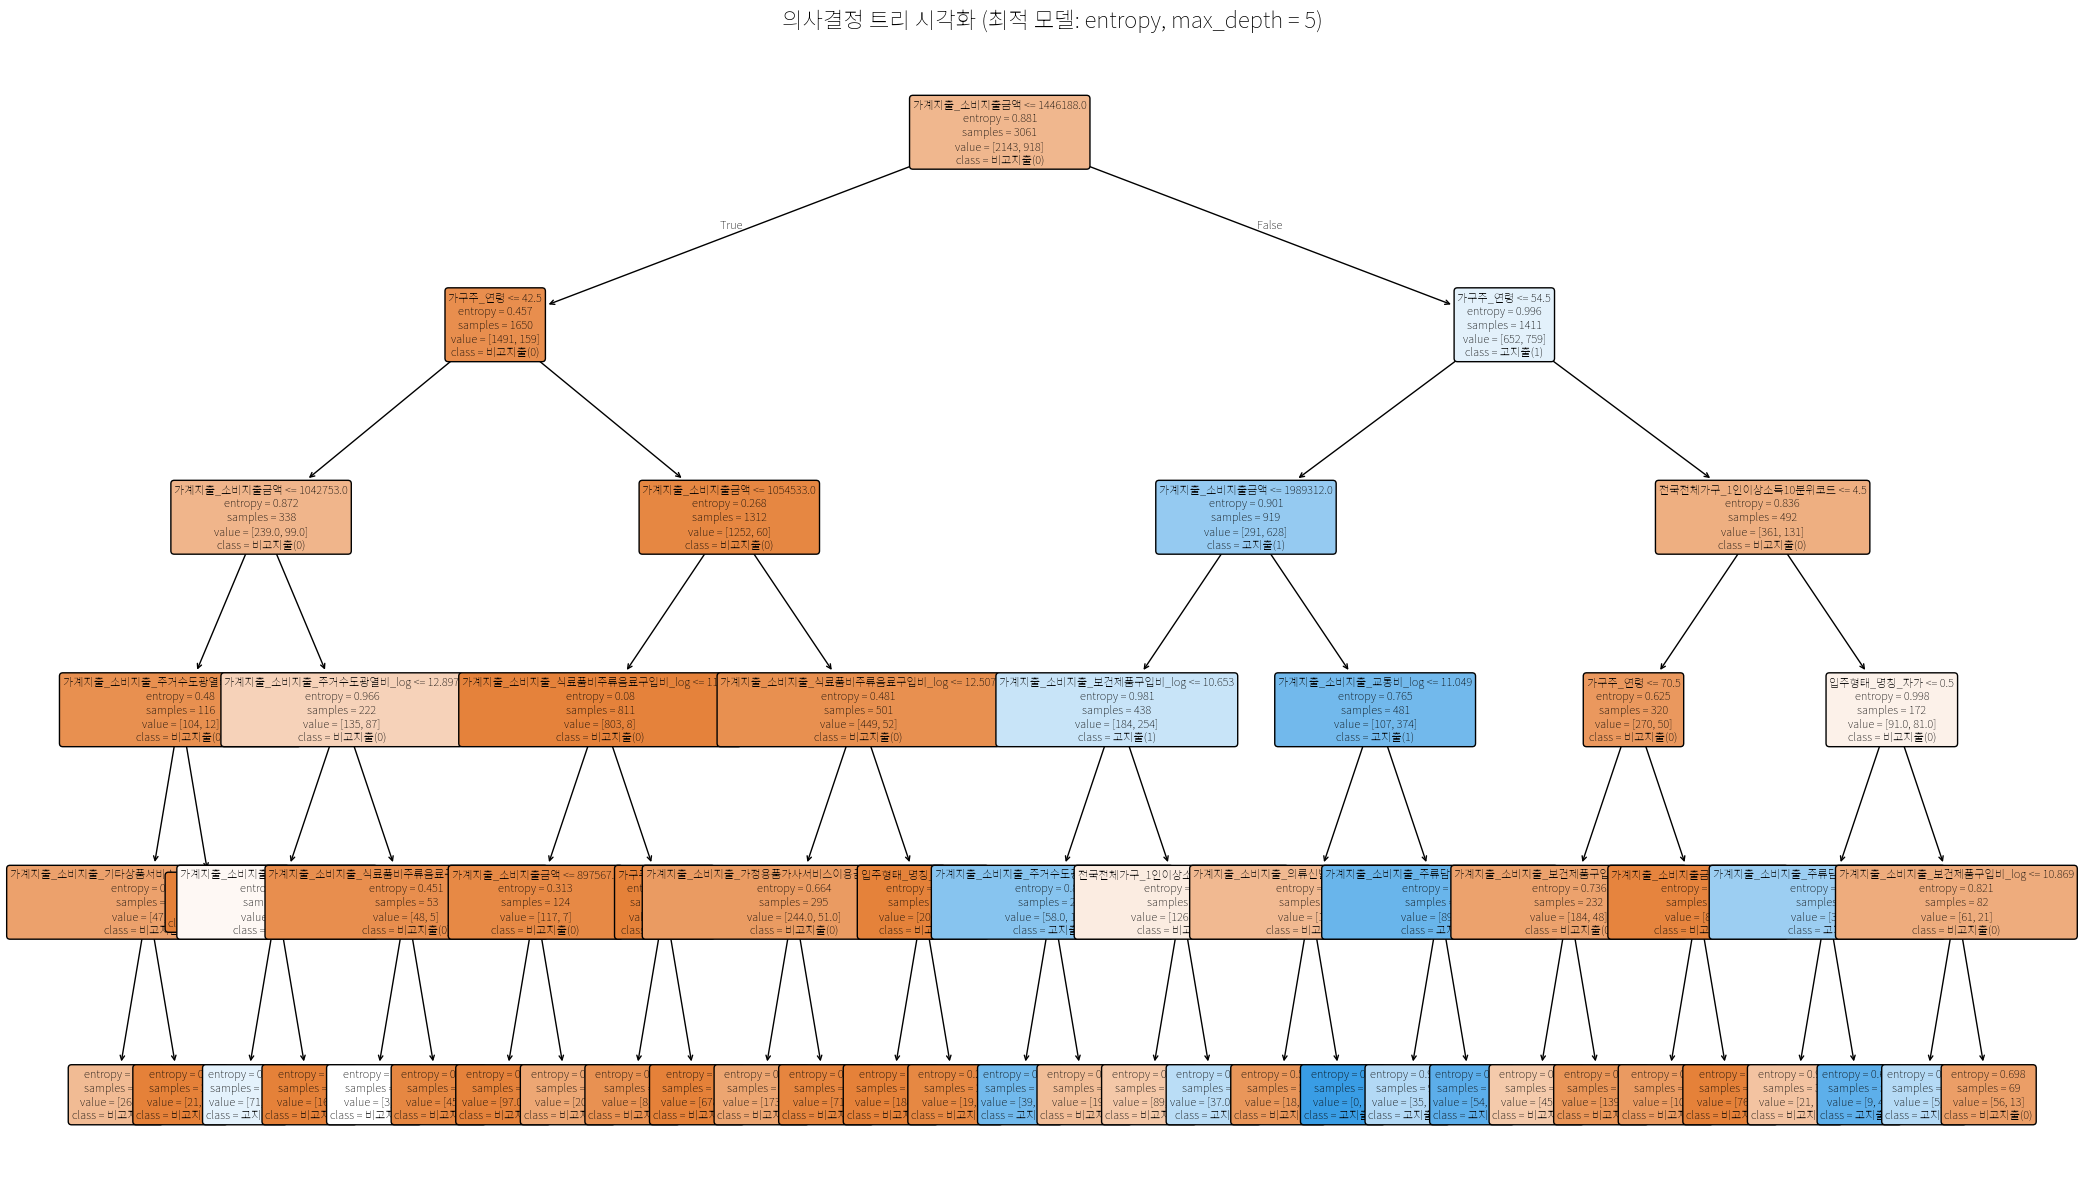

In [38]:
from sklearn.tree import plot_tree

feature_plot = X_train_single.columns.tolist()
class_plot = ['비고지출(0)', '고지출(1)']

plt.figure(figsize = (25, 15))

plot_tree(
    decision_tree = best_dt,
    feature_names = feature_plot,
    class_names = class_plot,
    filled = True,
    rounded = True,
    fontsize = 8,
    max_depth = 5
)

plt.title(f"의사결정 트리 시각화 (최적 모델: {grid_dt.best_params_['criterion']}, max_depth = {grid_dt.best_params_['max_depth']})", fontsize = 16)
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24180\620812005.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_features_dt.values, y = top_features_dt.index, palette = 'mako')


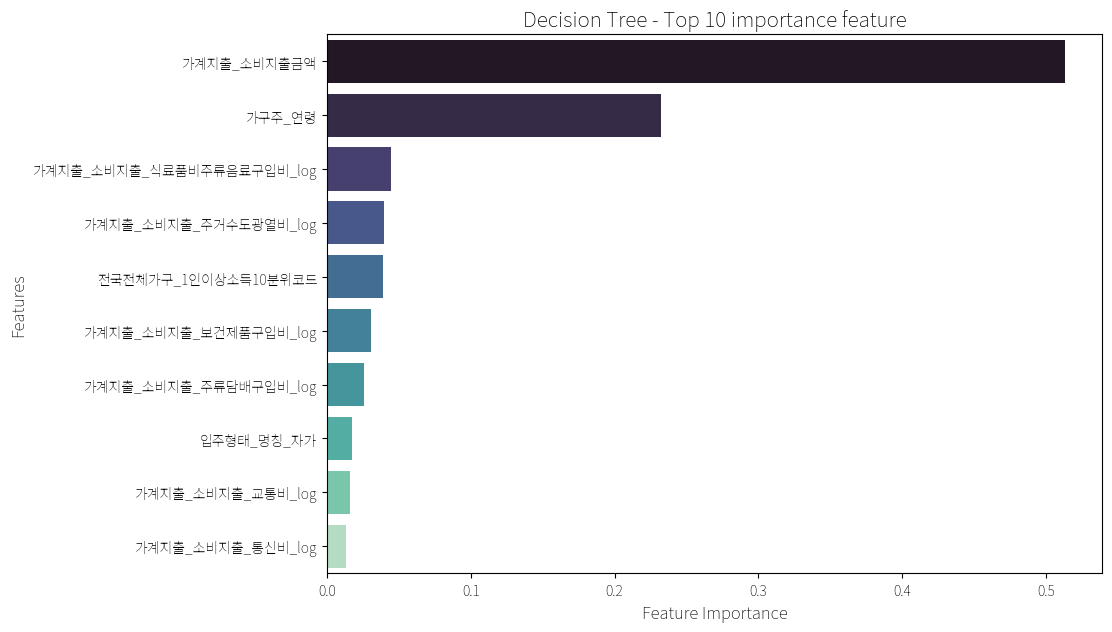

In [39]:
importances_dt = pd.Series(best_dt.feature_importances_, index=X_train_single.columns)
top_features_dt = importances_dt.nlargest(10)

plt.figure(figsize = (10, 7))
sns.barplot(x = top_features_dt.values, y = top_features_dt.index, palette = 'mako')
plt.title('Decision Tree - Top 10 importance feature', fontsize = 15)
plt.xlabel('Feature Importance', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.show()

In [40]:
if X_train_single is not None:
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    # C. KNN Classifier
    print("="*50)
    print("\nKNN Classifier\n")
    param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
    }
    grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv = kf, scoring = 'f1', n_jobs = -1)
    grid_knn.fit(X_train_single, y_train_single)
    best_knn = grid_knn.best_estimator_
    print(f"최적 파라미터 (KNN): {grid_knn.best_params_}")
    print(f"교차 검증 F1 Score (KNN): {grid_knn.best_score_:.4f}")

    y_pred_knn = best_knn.predict(X_test_single)
    print("\n테스트 세트 평가 (KNN): ")
    print(confusion_matrix(y_test_single, y_pred_knn))
    print(classification_report(y_test_single, y_pred_knn))
    if hasattr(best_knn, "predict_proba"):
        y_pred_proba_knn = best_knn.predict_proba(X_test_single)[:, 1]
        print(f"ROC AUC: {roc_auc_score(y_test_single, y_pred_proba_knn):.4f}")


KNN Classifier

최적 파라미터 (KNN): {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
교차 검증 F1 Score (KNN): 0.5613

테스트 세트 평가 (KNN): 
[[761 158]
 [188 206]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       919
           1       0.57      0.52      0.54       394

    accuracy                           0.74      1313
   macro avg       0.68      0.68      0.68      1313
weighted avg       0.73      0.74      0.73      1313

ROC AUC: 0.7926


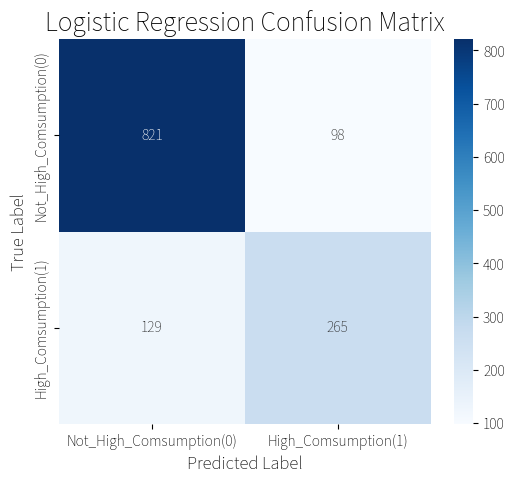

In [41]:
# 가장 성능이 좋았던 모델인 Logistic Regression의 confusion matrix를 히트맵으로 시각화

cm_lr = confusion_matrix(y_test_single, y_pred_lr)

plt.figure(figsize = (6, 5))
sns.heatmap(cm_lr, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['Not_High_Comsumption(0)', 'High_Comsumption(1)'], yticklabels = ['Not_High_Comsumption(0)', 'High_Comsumption(1)'])
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.title('Logistic Regression Confusion Matrix', fontsize = 18)
plt.show()

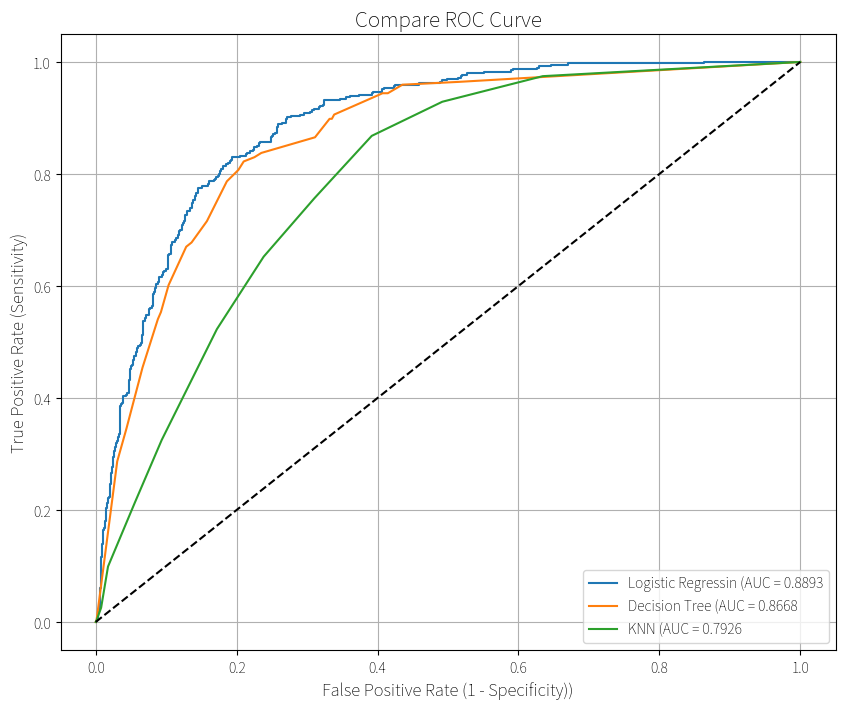

In [45]:
# 모델의 최적 추정기를 저장할 딕셔너리 생성
best_estimators_clf = {}

# DecisionTreeClassifier라는 key로 best_dt 모델 객테를 딕셔너리에 저장
model_name_lr = 'LogisticRegression'
best_estimators_clf[model_name_dt] = best_lr

# DecisionTreeClassifier라는 key로 best_dt 모델 객테를 딕셔너리에 저장
model_name_dt = 'DecisionTreeClassifier'
best_estimators_clf[model_name_dt] = best_dt

# DecisionTreeClassifier라는 key로 best_dt 모델 객테를 딕셔너리에 저장
model_name_knn = 'KNeighborsClassifier'
best_estimators_clf[model_name_dt] = best_knn

models_for_roc = {
    'Logistic Regression': best_estimators_clf.get('LogisticRegression'),
    'Decision Tree': best_estimators_clf.get('DecisionTreeClassifier'),
    'KNN': best_estimators_clf.get('KNeighborsClassifier')
}

plt.figure(figsize = (10, 8))

# Logistic Regression
# fpr, tpr값 계산
fpr_lr, tpr_lr, _ = roc_curve(y_test_single, y_pred_proba_lr)

#auc 값 계산
auc_lr = roc_auc_score(y_test_single, y_pred_proba_lr)

plt.plot(fpr_lr, tpr_lr, label = f'Logistic Regressin (AUC = {auc_lr:.4f}')

# Decision Tree
# fpr, tpr값 계산
fpr_dt, tpr_dt, _ = roc_curve(y_test_single, y_pred_proba_dt)

#auc 값 계산
auc_dt = roc_auc_score(y_test_single, y_pred_proba_dt)

plt.plot(fpr_dt, tpr_dt, label = f'Decision Tree (AUC = {auc_dt:.4f}')

# KNN
# fpr, tpr값 계산
fpr_knn, tpr_knn, _ = roc_curve(y_test_single, y_pred_proba_knn)

#auc 값 계산
auc_knn = roc_auc_score(y_test_single, y_pred_proba_knn)

plt.plot(fpr_knn, tpr_knn, label = f'KNN (AUC = {auc_knn:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1 - Specificity))', fontsize = 12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 12)
plt.title('Compare ROC Curve', fontsize = 15)
plt.legend(fontsize = 10)
plt.grid(True)
plt.show()